## Load libraries and files

In [1]:
!pyenv local 3.6.15
# Install any of the following packages with pip if you don't
# have them installed already
# Install stmpy package with the command "pip3 install getstmpy"
import stmpy
import stmpy.driftcorr as dfc
import h5py
import scipy as sp
%pylab inline
from decimal import Decimal, getcontext

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Pre-define functions to do data recovery

from pylbfgs import owlqn

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T
#     print(shape(x2))
#     x2 = x2 * np.hanning(nx)[:, None] * np.hanning(nx)[None, :]
    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx


def dct2(x):
#     x, y = np.shape(x)
#     w = np.hanning(x)[:, None] * np.hanning(x)[None, :]
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
#     return stmpy.tools.ifft(x)
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

## The 40 nm topo

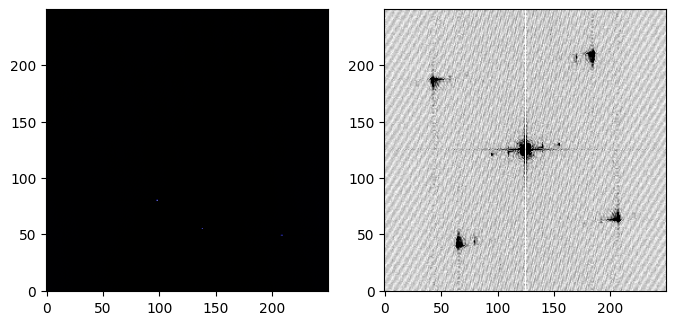

In [3]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo001.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

# part 1
## (drift correct then reconstruction)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

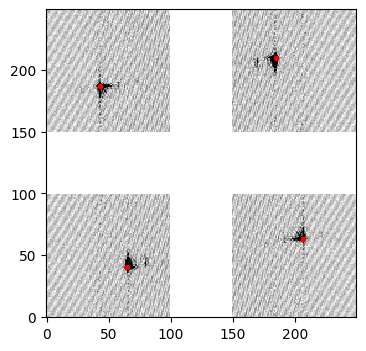

In [4]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[207,  63],
       [ 43, 187],
       [ 65,  40],
       [185, 210]])

The coordinates of the Q vectors are:
array([[ 83, -61],
       [-81,  63],
       [-59, -84],
       [ 61,  86]])


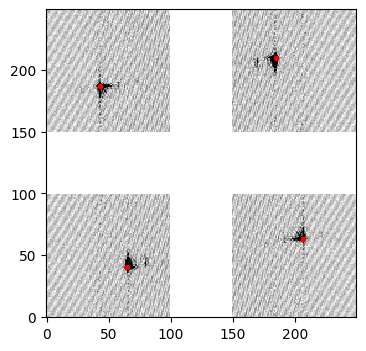

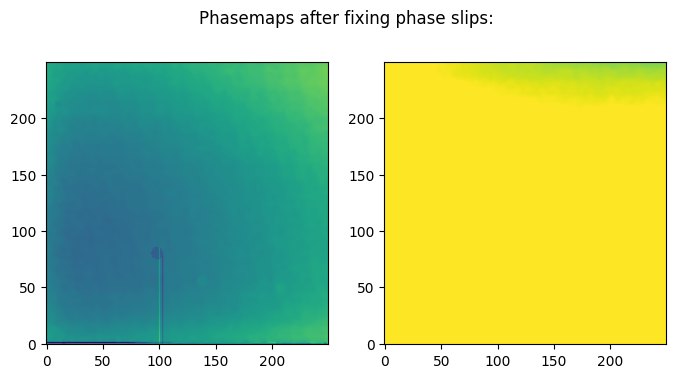

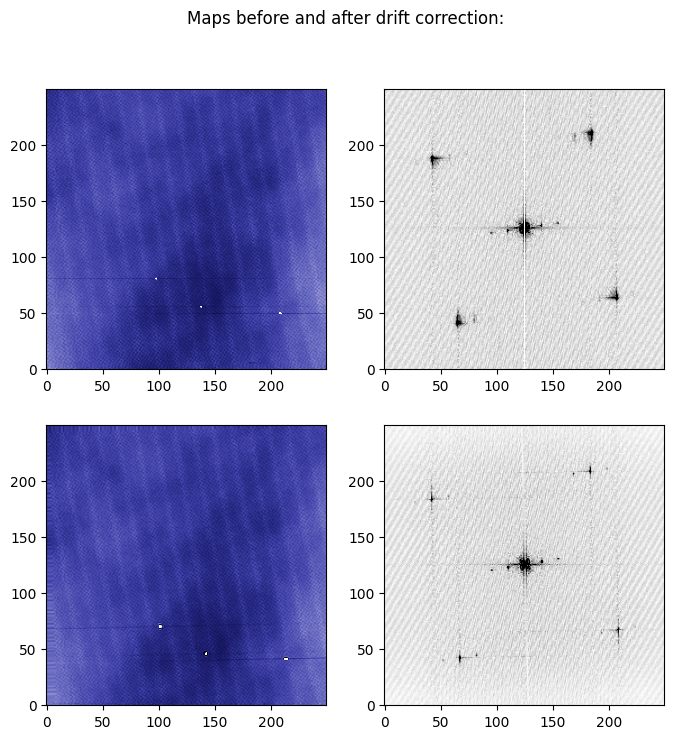

In [5]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

In [6]:
def standardize(data):
    data1 = (data / mean(data))
    #data1 = data1 * 3146.2264115727844
    return data1

In [7]:
original_mean = mean(t.z_c)
test = standardize(t.z_c)
nx, ny = shape(t.z_c)
# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

In [8]:
testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 219935917.621735, xnorm = 249.978151, gnorm = 29660.590397, step = 0.000034, k = 1, ls = 1

Iteration 2:
  fx = 119342763.521882, xnorm = 8971.936250, gnorm = 21832.284722, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 762102.272654, xnorm = 16005.570849, gnorm = 1508.357104, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 193134.778028, xnorm = 15920.307061, gnorm = 48.588472, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 192504.884287, xnorm = 15917.252611, gnorm = 11.981265, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 192423.621479, xnorm = 15915.551370, gnorm = 12.080672, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 190324.897203, xnorm = 15843.570683, gnorm = 81.732608, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 189340.194418, xnorm = 15835.407276, gnorm = 78.515815, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 187795.095988, xnorm = 15811.489092, gnorm = 43.013589, step = 0.125000, k = 9, ls = 4

Iteration 10:
  f

Iteration 78:
  fx = 163869.802332, xnorm = 15499.699971, gnorm = 40.963315, step = 0.500000, k = 78, ls = 2

Iteration 79:
  fx = 163361.886188, xnorm = 15487.257193, gnorm = 22.618221, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 163263.225278, xnorm = 15496.006652, gnorm = 40.864556, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 162756.929258, xnorm = 15483.760983, gnorm = 22.314297, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 162656.776716, xnorm = 15492.409910, gnorm = 40.564962, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 162161.836546, xnorm = 15480.276971, gnorm = 22.481651, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 162042.104970, xnorm = 15490.486686, gnorm = 39.838595, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 161574.193656, xnorm = 15476.734695, gnorm = 23.470431, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 161450.442796, xnorm = 15487.612503, gnorm = 40.044252, step = 0.500000, k = 86, ls = 2

Iteration 

Iteration 153:
  fx = 143616.312480, xnorm = 15489.884052, gnorm = 20.239388, step = 0.500000, k = 153, ls = 2

Iteration 154:
  fx = 143532.795264, xnorm = 15504.096437, gnorm = 35.669676, step = 0.500000, k = 154, ls = 2

Iteration 155:
  fx = 143149.382960, xnorm = 15493.196128, gnorm = 19.834290, step = 0.500000, k = 155, ls = 2

Iteration 156:
  fx = 143063.765767, xnorm = 15507.572249, gnorm = 35.266805, step = 0.500000, k = 156, ls = 2

Iteration 157:
  fx = 142691.321633, xnorm = 15496.478101, gnorm = 19.994895, step = 0.500000, k = 157, ls = 2

Iteration 158:
  fx = 142602.476955, xnorm = 15510.961356, gnorm = 35.052203, step = 0.500000, k = 158, ls = 2

Iteration 159:
  fx = 142235.529020, xnorm = 15499.840137, gnorm = 20.260487, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 142145.303961, xnorm = 15514.671425, gnorm = 35.058156, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 141779.001782, xnorm = 15503.477809, gnorm = 20.312699, step = 0.500000, k = 161, 

Iteration 230:
  fx = 128090.537350, xnorm = 15706.933838, gnorm = 30.621138, step = 0.500000, k = 230, ls = 2

Iteration 231:
  fx = 127808.404213, xnorm = 15697.895313, gnorm = 17.739004, step = 0.500000, k = 231, ls = 2

Iteration 232:
  fx = 127739.073430, xnorm = 15714.014898, gnorm = 30.568208, step = 0.500000, k = 232, ls = 2

Iteration 233:
  fx = 127457.388878, xnorm = 15705.026764, gnorm = 17.698704, step = 0.500000, k = 233, ls = 2

Iteration 234:
  fx = 127390.291316, xnorm = 15721.213935, gnorm = 30.581862, step = 0.500000, k = 234, ls = 2

Iteration 235:
  fx = 127106.541158, xnorm = 15712.292877, gnorm = 17.400992, step = 0.500000, k = 235, ls = 2

Iteration 236:
  fx = 127042.419067, xnorm = 15728.379319, gnorm = 30.439142, step = 0.500000, k = 236, ls = 2

Iteration 237:
  fx = 126760.810201, xnorm = 15719.605471, gnorm = 17.180008, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 126698.676584, xnorm = 15735.573850, gnorm = 30.275560, step = 0.500000, k = 238, 

Iteration 305:
  fx = 116356.486125, xnorm = 15999.624933, gnorm = 15.445692, step = 0.500000, k = 305, ls = 2

Iteration 306:
  fx = 116303.144125, xnorm = 16015.426648, gnorm = 26.591592, step = 0.500000, k = 306, ls = 2

Iteration 307:
  fx = 116087.963614, xnorm = 16008.555636, gnorm = 15.500449, step = 0.500000, k = 307, ls = 2

Iteration 308:
  fx = 116034.377287, xnorm = 16024.444044, gnorm = 26.539558, step = 0.500000, k = 308, ls = 2

Iteration 309:
  fx = 115820.219602, xnorm = 16017.570107, gnorm = 15.480780, step = 0.500000, k = 309, ls = 2

Iteration 310:
  fx = 115768.220247, xnorm = 16033.496325, gnorm = 26.484315, step = 0.500000, k = 310, ls = 2

Iteration 311:
  fx = 115553.568404, xnorm = 16026.660841, gnorm = 15.213831, step = 0.500000, k = 311, ls = 2

Iteration 312:
  fx = 115503.974881, xnorm = 16042.569246, gnorm = 26.492580, step = 0.500000, k = 312, ls = 2

Iteration 313:
  fx = 115289.220328, xnorm = 16035.787183, gnorm = 15.088953, step = 0.500000, k = 313, 

Iteration 379:
  fx = 107425.600137, xnorm = 16352.454617, gnorm = 13.695361, step = 0.500000, k = 379, ls = 2

Iteration 380:
  fx = 107384.477017, xnorm = 16367.658827, gnorm = 23.603286, step = 0.500000, k = 380, ls = 2

Iteration 381:
  fx = 107213.399241, xnorm = 16362.339351, gnorm = 13.637948, step = 0.500000, k = 381, ls = 2

Iteration 382:
  fx = 107172.138913, xnorm = 16377.484547, gnorm = 23.425433, step = 0.500000, k = 382, ls = 2

Iteration 383:
  fx = 107003.702103, xnorm = 16372.209852, gnorm = 13.653990, step = 0.500000, k = 383, ls = 2

Iteration 384:
  fx = 106961.051998, xnorm = 16387.295107, gnorm = 23.238597, step = 0.500000, k = 384, ls = 2

Iteration 385:
  fx = 106796.102031, xnorm = 16382.070437, gnorm = 13.792044, step = 0.500000, k = 385, ls = 2

Iteration 386:
  fx = 106752.952977, xnorm = 16397.218529, gnorm = 23.203804, step = 0.500000, k = 386, ls = 2

Iteration 387:
  fx = 106587.857664, xnorm = 16392.019595, gnorm = 13.611848, step = 0.500000, k = 387, 

Iteration 454:
  fx = 100434.017028, xnorm = 16736.137518, gnorm = 20.777449, step = 0.500000, k = 454, ls = 2

Iteration 455:
  fx = 100300.507249, xnorm = 16732.161174, gnorm = 12.051295, step = 0.500000, k = 455, ls = 2

Iteration 456:
  fx = 100268.074473, xnorm = 16746.145385, gnorm = 20.689566, step = 0.500000, k = 456, ls = 2

Iteration 457:
  fx = 100135.894347, xnorm = 16742.180934, gnorm = 12.056018, step = 0.500000, k = 457, ls = 2

Iteration 458:
  fx = 100103.080974, xnorm = 16756.143801, gnorm = 20.574065, step = 0.500000, k = 458, ls = 2

Iteration 459:
  fx = 99972.541044, xnorm = 16752.217532, gnorm = 12.079958, step = 0.500000, k = 459, ls = 2

Iteration 460:
  fx = 99939.672724, xnorm = 16766.157913, gnorm = 20.509490, step = 0.500000, k = 460, ls = 2

Iteration 461:
  fx = 99809.860474, xnorm = 16762.259837, gnorm = 12.066064, step = 0.500000, k = 461, ls = 2

Iteration 462:
  fx = 99777.579350, xnorm = 16776.232295, gnorm = 20.479401, step = 0.500000, k = 462, ls =

Iteration 529:
  fx = 94904.285928, xnorm = 17099.505168, gnorm = 10.570258, step = 0.500000, k = 529, ls = 2

Iteration 530:
  fx = 94878.571436, xnorm = 17112.092717, gnorm = 17.994175, step = 0.500000, k = 530, ls = 2

Iteration 531:
  fx = 94777.931717, xnorm = 17109.167156, gnorm = 10.593013, step = 0.500000, k = 531, ls = 2

Iteration 532:
  fx = 94751.371793, xnorm = 17121.691579, gnorm = 17.855926, step = 0.500000, k = 532, ls = 2

Iteration 533:
  fx = 94652.605601, xnorm = 17118.786089, gnorm = 10.685877, step = 0.500000, k = 533, ls = 2

Iteration 534:
  fx = 94625.577021, xnorm = 17131.352571, gnorm = 17.787537, step = 0.500000, k = 534, ls = 2

Iteration 535:
  fx = 94527.812302, xnorm = 17128.450976, gnorm = 10.698467, step = 0.500000, k = 535, ls = 2

Iteration 536:
  fx = 94501.378000, xnorm = 17141.006456, gnorm = 17.787691, step = 0.500000, k = 536, ls = 2

Iteration 537:
  fx = 94402.991642, xnorm = 17138.151107, gnorm = 10.537153, step = 0.500000, k = 537, ls = 2

I

Iteration 604:
  fx = 90740.879487, xnorm = 17455.559550, gnorm = 15.562331, step = 0.500000, k = 604, ls = 2

Iteration 605:
  fx = 90665.304565, xnorm = 17453.401177, gnorm = 9.486742, step = 0.500000, k = 605, ls = 2

Iteration 606:
  fx = 90644.214563, xnorm = 17464.358295, gnorm = 15.557085, step = 0.500000, k = 606, ls = 2

Iteration 607:
  fx = 90568.344952, xnorm = 17462.227904, gnorm = 9.321337, step = 0.500000, k = 607, ls = 2

Iteration 608:
  fx = 90547.870726, xnorm = 17473.092152, gnorm = 15.458195, step = 0.500000, k = 608, ls = 2

Iteration 609:
  fx = 90472.979542, xnorm = 17470.990258, gnorm = 9.299655, step = 0.500000, k = 609, ls = 2

Iteration 610:
  fx = 90452.226557, xnorm = 17481.804768, gnorm = 15.380686, step = 0.500000, k = 610, ls = 2

Iteration 611:
  fx = 90378.350475, xnorm = 17479.732835, gnorm = 9.352922, step = 0.500000, k = 611, ls = 2

Iteration 612:
  fx = 90357.617969, xnorm = 17490.548446, gnorm = 15.339731, step = 0.500000, k = 612, ls = 2

Itera

Iteration 679:
  fx = 87522.749176, xnorm = 17763.661777, gnorm = 8.448206, step = 0.500000, k = 679, ls = 2

Iteration 680:
  fx = 87504.983205, xnorm = 17773.163871, gnorm = 13.327219, step = 0.500000, k = 680, ls = 2

Iteration 681:
  fx = 87449.272510, xnorm = 17771.563260, gnorm = 8.422621, step = 0.500000, k = 681, ls = 2

Iteration 682:
  fx = 87431.566137, xnorm = 17781.043918, gnorm = 13.307002, step = 0.500000, k = 682, ls = 2

Iteration 683:
  fx = 87376.025170, xnorm = 17779.442795, gnorm = 8.380079, step = 0.500000, k = 683, ls = 2

Iteration 684:
  fx = 87358.818261, xnorm = 17788.894449, gnorm = 13.309334, step = 0.500000, k = 684, ls = 2

Iteration 685:
  fx = 87303.049031, xnorm = 17787.321461, gnorm = 8.251486, step = 0.500000, k = 685, ls = 2

Iteration 686:
  fx = 87286.433744, xnorm = 17796.699710, gnorm = 13.268425, step = 0.500000, k = 686, ls = 2

Iteration 687:
  fx = 87230.875531, xnorm = 17795.148381, gnorm = 8.208323, step = 0.500000, k = 687, ls = 2

Iterat

Iteration 790:
  fx = 84173.622960, xnorm = 18167.942295, gnorm = 10.662141, step = 0.500000, k = 790, ls = 2

Iteration 791:
  fx = 84137.486152, xnorm = 18166.918499, gnorm = 6.963614, step = 0.500000, k = 791, ls = 2

Iteration 792:
  fx = 84124.786378, xnorm = 18174.406000, gnorm = 10.619138, step = 0.500000, k = 792, ls = 2

Iteration 793:
  fx = 84089.095673, xnorm = 18173.390206, gnorm = 6.964456, step = 0.500000, k = 793, ls = 2

Iteration 794:
  fx = 84076.520931, xnorm = 18180.863366, gnorm = 10.598493, step = 0.500000, k = 794, ls = 2

Iteration 795:
  fx = 84040.873784, xnorm = 18179.842670, gnorm = 6.926334, step = 0.500000, k = 795, ls = 2

Iteration 796:
  fx = 84028.381876, xnorm = 18187.268273, gnorm = 10.530765, step = 0.500000, k = 796, ls = 2

Iteration 797:
  fx = 83993.209981, xnorm = 18186.268821, gnorm = 6.908828, step = 0.500000, k = 797, ls = 2

Iteration 798:
  fx = 83980.510068, xnorm = 18193.651981, gnorm = 10.463600, step = 0.500000, k = 798, ls = 2

Itera

Iteration 900:
  fx = 81971.406358, xnorm = 18487.258496, gnorm = 8.616079, step = 0.500000, k = 900, ls = 2

Iteration 901:
  fx = 81947.654471, xnorm = 18486.647482, gnorm = 5.773651, step = 0.500000, k = 901, ls = 2

Iteration 902:
  fx = 81938.553749, xnorm = 18492.487134, gnorm = 8.578289, step = 0.500000, k = 902, ls = 2

Iteration 903:
  fx = 81915.147081, xnorm = 18491.867487, gnorm = 5.798087, step = 0.500000, k = 903, ls = 2

Iteration 904:
  fx = 81906.079620, xnorm = 18497.702930, gnorm = 8.555788, step = 0.500000, k = 904, ls = 2

Iteration 905:
  fx = 81882.718376, xnorm = 18497.087418, gnorm = 5.751201, step = 0.500000, k = 905, ls = 2

Iteration 906:
  fx = 81873.874113, xnorm = 18502.879057, gnorm = 8.533375, step = 0.500000, k = 906, ls = 2

Iteration 907:
  fx = 81850.618441, xnorm = 18502.272541, gnorm = 5.698766, step = 0.500000, k = 907, ls = 2

Iteration 908:
  fx = 81841.784070, xnorm = 18508.028593, gnorm = 8.481146, step = 0.500000, k = 908, ls = 2

Iteration 

Iteration 1010:
  fx = 80467.277456, xnorm = 18747.048092, gnorm = 7.044060, step = 0.500000, k = 1010, ls = 2

Iteration 1011:
  fx = 80451.309287, xnorm = 18746.668959, gnorm = 4.887558, step = 0.500000, k = 1011, ls = 2

Iteration 1012:
  fx = 80444.793798, xnorm = 18751.289940, gnorm = 7.038140, step = 0.500000, k = 1012, ls = 2

Iteration 1013:
  fx = 80428.760949, xnorm = 18750.916573, gnorm = 4.836464, step = 0.500000, k = 1013, ls = 2

Iteration 1014:
  fx = 80422.386430, xnorm = 18755.513566, gnorm = 7.019941, step = 0.500000, k = 1014, ls = 2

Iteration 1015:
  fx = 80406.376091, xnorm = 18755.145377, gnorm = 4.797118, step = 0.500000, k = 1015, ls = 2

Iteration 1016:
  fx = 80400.059388, xnorm = 18759.722721, gnorm = 7.008962, step = 0.500000, k = 1016, ls = 2

Iteration 1017:
  fx = 80384.183616, xnorm = 18759.356076, gnorm = 4.824974, step = 0.500000, k = 1017, ls = 2

Iteration 1018:
  fx = 80377.829863, xnorm = 18763.936621, gnorm = 6.994060, step = 0.500000, k = 1018, 

Iteration 1120:
  fx = 79404.307123, xnorm = 18962.056726, gnorm = 5.921703, step = 0.500000, k = 1120, ls = 2

Iteration 1121:
  fx = 79392.882525, xnorm = 18961.848896, gnorm = 4.112983, step = 0.500000, k = 1121, ls = 2

Iteration 1122:
  fx = 79388.118667, xnorm = 18965.557199, gnorm = 5.873645, step = 0.500000, k = 1122, ls = 2

Iteration 1123:
  fx = 79376.893813, xnorm = 18965.351001, gnorm = 4.132295, step = 0.500000, k = 1123, ls = 2

Iteration 1124:
  fx = 79372.103368, xnorm = 18969.050898, gnorm = 5.862422, step = 0.500000, k = 1124, ls = 2

Iteration 1125:
  fx = 79360.952917, xnorm = 18968.850203, gnorm = 4.130985, step = 0.500000, k = 1125, ls = 2

Iteration 1126:
  fx = 79356.200675, xnorm = 18972.536319, gnorm = 5.860652, step = 0.500000, k = 1126, ls = 2

Iteration 1127:
  fx = 79345.071702, xnorm = 18972.338705, gnorm = 4.109201, step = 0.500000, k = 1127, ls = 2

Iteration 1128:
  fx = 79340.395775, xnorm = 18976.000293, gnorm = 5.841029, step = 0.500000, k = 1128, 

Iteration 1230:
  fx = 78653.604773, xnorm = 19136.658404, gnorm = 4.948115, step = 0.500000, k = 1230, ls = 2

Iteration 1231:
  fx = 78645.572117, xnorm = 19136.499660, gnorm = 3.512991, step = 0.500000, k = 1231, ls = 2

Iteration 1232:
  fx = 78642.117138, xnorm = 19139.516030, gnorm = 4.932100, step = 0.500000, k = 1232, ls = 2

Iteration 1233:
  fx = 78634.105757, xnorm = 19139.366108, gnorm = 3.457600, step = 0.500000, k = 1233, ls = 2

Iteration 1234:
  fx = 78630.741546, xnorm = 19142.345710, gnorm = 4.903859, step = 0.500000, k = 1234, ls = 2

Iteration 1235:
  fx = 78622.850999, xnorm = 19142.196564, gnorm = 3.438303, step = 0.500000, k = 1235, ls = 2

Iteration 1236:
  fx = 78619.478019, xnorm = 19145.149347, gnorm = 4.865315, step = 0.500000, k = 1236, ls = 2

Iteration 1237:
  fx = 78611.726386, xnorm = 19145.006818, gnorm = 3.459329, step = 0.500000, k = 1237, ls = 2

Iteration 1238:
  fx = 78608.235304, xnorm = 19147.953045, gnorm = 4.826192, step = 0.500000, k = 1238, 

Iteration 1339:
  fx = 78120.388933, xnorm = 19276.733101, gnorm = 3.000453, step = 0.500000, k = 1339, ls = 2

Iteration 1340:
  fx = 78117.809615, xnorm = 19279.165675, gnorm = 4.148575, step = 0.500000, k = 1340, ls = 2

Iteration 1341:
  fx = 78112.186317, xnorm = 19279.072509, gnorm = 2.999570, step = 0.500000, k = 1341, ls = 2

Iteration 1342:
  fx = 78109.546933, xnorm = 19281.498420, gnorm = 4.116703, step = 0.500000, k = 1342, ls = 2

Iteration 1343:
  fx = 78104.043911, xnorm = 19281.403808, gnorm = 3.025259, step = 0.500000, k = 1343, ls = 2

Iteration 1344:
  fx = 78101.368786, xnorm = 19283.828372, gnorm = 4.102841, step = 0.500000, k = 1344, ls = 2

Iteration 1345:
  fx = 78095.882848, xnorm = 19283.740799, gnorm = 2.990713, step = 0.500000, k = 1345, ls = 2

Iteration 1346:
  fx = 78093.249617, xnorm = 19286.135025, gnorm = 4.069497, step = 0.500000, k = 1346, ls = 2

Iteration 1347:
  fx = 78087.847465, xnorm = 19286.053390, gnorm = 2.972756, step = 0.500000, k = 1347, 

Iteration 1448:
  fx = 77735.865563, xnorm = 19394.996008, gnorm = 3.589511, step = 0.500000, k = 1448, ls = 2

Iteration 1449:
  fx = 77731.657734, xnorm = 19394.941110, gnorm = 2.582255, step = 0.500000, k = 1449, ls = 2

Iteration 1450:
  fx = 77729.715313, xnorm = 19396.995994, gnorm = 3.575298, step = 0.500000, k = 1450, ls = 2

Iteration 1451:
  fx = 77725.533569, xnorm = 19396.941200, gnorm = 2.583308, step = 0.500000, k = 1451, ls = 2

Iteration 1452:
  fx = 77723.596776, xnorm = 19398.991529, gnorm = 3.574446, step = 0.500000, k = 1452, ls = 2

Iteration 1453:
  fx = 77719.439991, xnorm = 19398.938939, gnorm = 2.572415, step = 0.500000, k = 1453, ls = 2

Iteration 1454:
  fx = 77717.527537, xnorm = 19400.982657, gnorm = 3.572889, step = 0.500000, k = 1454, ls = 2

Iteration 1455:
  fx = 77713.367845, xnorm = 19400.931503, gnorm = 2.553162, step = 0.500000, k = 1455, ls = 2

Iteration 1456:
  fx = 77711.473001, xnorm = 19402.965474, gnorm = 3.568114, step = 0.500000, k = 1456, 

Iteration 1556:
  fx = 77447.144860, xnorm = 19494.260932, gnorm = 3.113986, step = 0.500000, k = 1556, ls = 2

Iteration 1557:
  fx = 77443.939752, xnorm = 19494.237240, gnorm = 2.214840, step = 0.500000, k = 1557, ls = 2

Iteration 1558:
  fx = 77442.525165, xnorm = 19495.920857, gnorm = 3.098259, step = 0.500000, k = 1558, ls = 2

Iteration 1559:
  fx = 77439.362967, xnorm = 19495.901534, gnorm = 2.225161, step = 0.500000, k = 1559, ls = 2

Iteration 1560:
  fx = 77437.933500, xnorm = 19497.579540, gnorm = 3.080136, step = 0.500000, k = 1560, ls = 2

Iteration 1561:
  fx = 77434.807857, xnorm = 19497.555675, gnorm = 2.228214, step = 0.500000, k = 1561, ls = 2

Iteration 1562:
  fx = 77433.378314, xnorm = 19499.238876, gnorm = 3.077429, step = 0.500000, k = 1562, ls = 2

Iteration 1563:
  fx = 77430.262832, xnorm = 19499.213561, gnorm = 2.233654, step = 0.500000, k = 1563, ls = 2

Iteration 1564:
  fx = 77428.849321, xnorm = 19500.902727, gnorm = 3.091218, step = 0.500000, k = 1564, 

Iteration 1662:
  fx = 77228.483492, xnorm = 19576.987074, gnorm = 2.737740, step = 0.500000, k = 1662, ls = 2

Iteration 1663:
  fx = 77226.033100, xnorm = 19576.994190, gnorm = 1.980520, step = 0.500000, k = 1663, ls = 2

Iteration 1664:
  fx = 77224.898820, xnorm = 19578.425180, gnorm = 2.739106, step = 0.500000, k = 1664, ls = 2

Iteration 1665:
  fx = 77222.439404, xnorm = 19578.429913, gnorm = 1.967303, step = 0.500000, k = 1665, ls = 2

Iteration 1666:
  fx = 77221.323202, xnorm = 19579.859057, gnorm = 2.729356, step = 0.500000, k = 1666, ls = 2

Iteration 1667:
  fx = 77218.873848, xnorm = 19579.864604, gnorm = 1.964436, step = 0.500000, k = 1667, ls = 2

Iteration 1668:
  fx = 77217.764374, xnorm = 19581.282709, gnorm = 2.722103, step = 0.500000, k = 1668, ls = 2

Iteration 1669:
  fx = 77215.321317, xnorm = 19581.292311, gnorm = 1.955041, step = 0.500000, k = 1669, ls = 2

Iteration 1670:
  fx = 77214.232002, xnorm = 19582.705535, gnorm = 2.720486, step = 0.500000, k = 1670, 

Iteration 1769:
  fx = 77055.929608, xnorm = 19648.096085, gnorm = 1.711898, step = 0.500000, k = 1769, ls = 2

Iteration 1770:
  fx = 77055.124265, xnorm = 19649.328716, gnorm = 2.457328, step = 0.500000, k = 1770, ls = 2

Iteration 1771:
  fx = 77053.107213, xnorm = 19649.337796, gnorm = 1.701467, step = 0.500000, k = 1771, ls = 2

Iteration 1772:
  fx = 77052.308558, xnorm = 19650.561024, gnorm = 2.450523, step = 0.500000, k = 1772, ls = 2

Iteration 1773:
  fx = 77050.303435, xnorm = 19650.573381, gnorm = 1.703632, step = 0.500000, k = 1773, ls = 2

Iteration 1774:
  fx = 77049.507173, xnorm = 19651.796668, gnorm = 2.459034, step = 0.500000, k = 1774, ls = 2

Iteration 1775:
  fx = 77047.498073, xnorm = 19651.808476, gnorm = 1.698847, step = 0.500000, k = 1775, ls = 2

Iteration 1776:
  fx = 77046.700930, xnorm = 19653.030462, gnorm = 2.454934, step = 0.500000, k = 1776, ls = 2

Iteration 1777:
  fx = 77044.703365, xnorm = 19653.041638, gnorm = 1.697694, step = 0.500000, k = 1777, 

Iteration 1876:
  fx = 76922.717418, xnorm = 19710.049735, gnorm = 2.144813, step = 0.500000, k = 1876, ls = 2

Iteration 1877:
  fx = 76921.183988, xnorm = 19710.066647, gnorm = 1.513212, step = 0.500000, k = 1877, ls = 2

Iteration 1878:
  fx = 76920.540370, xnorm = 19711.093690, gnorm = 2.134898, step = 0.500000, k = 1878, ls = 2

Iteration 1879:
  fx = 76919.020244, xnorm = 19711.107307, gnorm = 1.506655, step = 0.500000, k = 1879, ls = 2

Iteration 1880:
  fx = 76918.380550, xnorm = 19712.133835, gnorm = 2.130476, step = 0.500000, k = 1880, ls = 2

Iteration 1881:
  fx = 76916.865989, xnorm = 19712.147225, gnorm = 1.505005, step = 0.500000, k = 1881, ls = 2

Iteration 1882:
  fx = 76916.233355, xnorm = 19713.171947, gnorm = 2.127736, step = 0.500000, k = 1882, ls = 2

Iteration 1883:
  fx = 76914.716852, xnorm = 19713.184859, gnorm = 1.496982, step = 0.500000, k = 1883, ls = 2

Iteration 1884:
  fx = 76914.087905, xnorm = 19714.206176, gnorm = 2.125567, step = 0.500000, k = 1884, 

Iteration 1982:
  fx = 76819.436092, xnorm = 19761.791960, gnorm = 1.902309, step = 0.500000, k = 1982, ls = 2

Iteration 1983:
  fx = 76818.226625, xnorm = 19761.798892, gnorm = 1.338073, step = 0.500000, k = 1983, ls = 2

Iteration 1984:
  fx = 76817.721766, xnorm = 19762.690687, gnorm = 1.893075, step = 0.500000, k = 1984, ls = 2

Iteration 1985:
  fx = 76816.520535, xnorm = 19762.695619, gnorm = 1.329587, step = 0.500000, k = 1985, ls = 2

Iteration 1986:
  fx = 76816.030393, xnorm = 19763.585458, gnorm = 1.898587, step = 0.500000, k = 1986, ls = 2

Iteration 1987:
  fx = 76814.822796, xnorm = 19763.590619, gnorm = 1.324484, step = 0.500000, k = 1987, ls = 2

Iteration 1988:
  fx = 76814.344295, xnorm = 19764.479904, gnorm = 1.905163, step = 0.500000, k = 1988, ls = 2

Iteration 1989:
  fx = 76813.125107, xnorm = 19764.486496, gnorm = 1.318628, step = 0.500000, k = 1989, ls = 2

Iteration 1990:
  fx = 76812.651077, xnorm = 19765.373135, gnorm = 1.906575, step = 0.500000, k = 1990, 

Iteration 2090:
  fx = 76734.219625, xnorm = 19808.467003, gnorm = 1.733053, step = 0.500000, k = 2090, ls = 2

Iteration 2091:
  fx = 76733.218135, xnorm = 19808.483017, gnorm = 1.201405, step = 0.500000, k = 2091, ls = 2

Iteration 2092:
  fx = 76732.817640, xnorm = 19809.273763, gnorm = 1.737927, step = 0.500000, k = 2092, ls = 2

Iteration 2093:
  fx = 76731.808963, xnorm = 19809.288478, gnorm = 1.191549, step = 0.500000, k = 2093, ls = 2

Iteration 2094:
  fx = 76731.425494, xnorm = 19810.078644, gnorm = 1.745728, step = 0.500000, k = 2094, ls = 2

Iteration 2095:
  fx = 76730.402331, xnorm = 19810.092500, gnorm = 1.176309, step = 0.500000, k = 2095, ls = 2

Iteration 2096:
  fx = 76730.028672, xnorm = 19810.881021, gnorm = 1.744761, step = 0.500000, k = 2096, ls = 2

Iteration 2097:
  fx = 76729.006704, xnorm = 19810.894346, gnorm = 1.172161, step = 0.500000, k = 2097, ls = 2

Iteration 2098:
  fx = 76728.631693, xnorm = 19811.682151, gnorm = 1.739973, step = 0.500000, k = 2098, 

Iteration 2197:
  fx = 76664.345190, xnorm = 19849.339850, gnorm = 1.077136, step = 0.500000, k = 2197, ls = 2

Iteration 2198:
  fx = 76664.029929, xnorm = 19850.048168, gnorm = 1.614991, step = 0.500000, k = 2198, ls = 2

Iteration 2199:
  fx = 76663.163062, xnorm = 19850.067028, gnorm = 1.077240, step = 0.500000, k = 2199, ls = 2

Iteration 2200:
  fx = 76662.839795, xnorm = 19850.772017, gnorm = 1.599020, step = 0.500000, k = 2200, ls = 2

Iteration 2201:
  fx = 76661.993242, xnorm = 19850.790164, gnorm = 1.084622, step = 0.500000, k = 2201, ls = 2

Iteration 2202:
  fx = 76661.665341, xnorm = 19851.492521, gnorm = 1.594386, step = 0.500000, k = 2202, ls = 2

Iteration 2203:
  fx = 76660.826135, xnorm = 19851.511720, gnorm = 1.090615, step = 0.500000, k = 2203, ls = 2

Iteration 2204:
  fx = 76660.501029, xnorm = 19852.214155, gnorm = 1.597397, step = 0.500000, k = 2204, ls = 2

Iteration 2205:
  fx = 76659.657936, xnorm = 19852.232865, gnorm = 1.088148, step = 0.500000, k = 2205, 

Iteration 2304:
  fx = 76607.409471, xnorm = 19886.167007, gnorm = 1.456578, step = 0.500000, k = 2304, ls = 2

Iteration 2305:
  fx = 76606.705640, xnorm = 19886.180690, gnorm = 0.974639, step = 0.500000, k = 2305, ls = 2

Iteration 2306:
  fx = 76606.448420, xnorm = 19886.807048, gnorm = 1.455328, step = 0.500000, k = 2306, ls = 2

Iteration 2307:
  fx = 76605.745906, xnorm = 19886.821796, gnorm = 0.974062, step = 0.500000, k = 2307, ls = 2

Iteration 2308:
  fx = 76605.490033, xnorm = 19887.445653, gnorm = 1.453725, step = 0.500000, k = 2308, ls = 2

Iteration 2309:
  fx = 76604.788866, xnorm = 19887.460469, gnorm = 0.976042, step = 0.500000, k = 2309, ls = 2

Iteration 2310:
  fx = 76604.529542, xnorm = 19888.085662, gnorm = 1.450896, step = 0.500000, k = 2310, ls = 2

Iteration 2311:
  fx = 76603.831456, xnorm = 19888.102281, gnorm = 0.975227, step = 0.500000, k = 2311, ls = 2

Iteration 2312:
  fx = 76603.570816, xnorm = 19888.722633, gnorm = 1.445903, step = 0.500000, k = 2312, 

Iteration 2411:
  fx = 76560.458665, xnorm = 19917.822358, gnorm = 0.893244, step = 0.500000, k = 2411, ls = 2

Iteration 2412:
  fx = 76560.243231, xnorm = 19918.363649, gnorm = 1.313607, step = 0.500000, k = 2412, ls = 2

Iteration 2413:
  fx = 76559.667448, xnorm = 19918.383205, gnorm = 0.885970, step = 0.500000, k = 2413, ls = 2

Iteration 2414:
  fx = 76559.457111, xnorm = 19918.922557, gnorm = 1.314178, step = 0.500000, k = 2414, ls = 2

Iteration 2415:
  fx = 76558.879276, xnorm = 19918.943622, gnorm = 0.879589, step = 0.500000, k = 2415, ls = 2

Iteration 2416:
  fx = 76558.673616, xnorm = 19919.479929, gnorm = 1.315038, step = 0.500000, k = 2416, ls = 2

Iteration 2417:
  fx = 76558.095223, xnorm = 19919.499789, gnorm = 0.874311, step = 0.500000, k = 2417, ls = 2

Iteration 2418:
  fx = 76557.891975, xnorm = 19920.037435, gnorm = 1.313931, step = 0.500000, k = 2418, ls = 2

Iteration 2419:
  fx = 76557.314010, xnorm = 19920.055062, gnorm = 0.870460, step = 0.500000, k = 2419, 

Iteration 2516:
  fx = 76522.563078, xnorm = 19945.847240, gnorm = 1.246279, step = 0.500000, k = 2516, ls = 2

Iteration 2517:
  fx = 76522.041638, xnorm = 19945.864930, gnorm = 0.783986, step = 0.500000, k = 2517, ls = 2

Iteration 2518:
  fx = 76521.890014, xnorm = 19946.350906, gnorm = 1.245347, step = 0.500000, k = 2518, ls = 2

Iteration 2519:
  fx = 76521.371576, xnorm = 19946.368641, gnorm = 0.784686, step = 0.500000, k = 2519, ls = 2

Iteration 2520:
  fx = 76521.218602, xnorm = 19946.853847, gnorm = 1.241883, step = 0.500000, k = 2520, ls = 2

Iteration 2521:
  fx = 76520.703099, xnorm = 19946.872538, gnorm = 0.784792, step = 0.500000, k = 2521, ls = 2

Iteration 2522:
  fx = 76520.549826, xnorm = 19947.355011, gnorm = 1.234169, step = 0.500000, k = 2522, ls = 2

Iteration 2523:
  fx = 76520.040423, xnorm = 19947.374220, gnorm = 0.785270, step = 0.500000, k = 2523, ls = 2

Iteration 2524:
  fx = 76519.884882, xnorm = 19947.855587, gnorm = 1.228080, step = 0.500000, k = 2524, 

Iteration 2623:
  fx = 76489.540845, xnorm = 19970.990694, gnorm = 0.711074, step = 0.500000, k = 2623, ls = 2

Iteration 2624:
  fx = 76489.420074, xnorm = 19971.423618, gnorm = 1.154958, step = 0.500000, k = 2624, ls = 2

Iteration 2625:
  fx = 76488.972189, xnorm = 19971.443011, gnorm = 0.711556, step = 0.500000, k = 2625, ls = 2

Iteration 2626:
  fx = 76488.848963, xnorm = 19971.873337, gnorm = 1.150355, step = 0.500000, k = 2626, ls = 2

Iteration 2627:
  fx = 76488.405989, xnorm = 19971.894815, gnorm = 0.715971, step = 0.500000, k = 2627, ls = 2

Iteration 2628:
  fx = 76488.280266, xnorm = 19972.323651, gnorm = 1.148974, step = 0.500000, k = 2628, ls = 2

Iteration 2629:
  fx = 76487.838801, xnorm = 19972.345373, gnorm = 0.717976, step = 0.500000, k = 2629, ls = 2

Iteration 2630:
  fx = 76487.713080, xnorm = 19972.775790, gnorm = 1.150407, step = 0.500000, k = 2630, ls = 2

Iteration 2631:
  fx = 76487.270504, xnorm = 19972.797733, gnorm = 0.715257, step = 0.500000, k = 2631, 

Iteration 2729:
  fx = 76461.784612, xnorm = 19993.667909, gnorm = 0.662331, step = 0.500000, k = 2729, ls = 2

Iteration 2730:
  fx = 76461.676563, xnorm = 19994.050238, gnorm = 1.048889, step = 0.500000, k = 2730, ls = 2

Iteration 2731:
  fx = 76461.306313, xnorm = 19994.072092, gnorm = 0.658614, step = 0.500000, k = 2731, ls = 2

Iteration 2732:
  fx = 76461.202103, xnorm = 19994.452783, gnorm = 1.054275, step = 0.500000, k = 2732, ls = 2

Iteration 2733:
  fx = 76460.827531, xnorm = 19994.475138, gnorm = 0.652350, step = 0.500000, k = 2733, ls = 2

Iteration 2734:
  fx = 76460.725328, xnorm = 19994.854336, gnorm = 1.053415, step = 0.500000, k = 2734, ls = 2

Iteration 2735:
  fx = 76460.351215, xnorm = 19994.876659, gnorm = 0.647643, step = 0.500000, k = 2735, ls = 2

Iteration 2736:
  fx = 76460.251380, xnorm = 19995.255683, gnorm = 1.053024, step = 0.500000, k = 2736, ls = 2

Iteration 2737:
  fx = 76459.876383, xnorm = 19995.276670, gnorm = 0.643821, step = 0.500000, k = 2737, 

Iteration 2836:
  fx = 76437.953000, xnorm = 20014.676022, gnorm = 0.984620, step = 0.500000, k = 2836, ls = 2

Iteration 2837:
  fx = 76437.627991, xnorm = 20014.695027, gnorm = 0.603818, step = 0.500000, k = 2837, ls = 2

Iteration 2838:
  fx = 76437.539506, xnorm = 20015.044202, gnorm = 0.982945, step = 0.500000, k = 2838, ls = 2

Iteration 2839:
  fx = 76437.216176, xnorm = 20015.063689, gnorm = 0.608238, step = 0.500000, k = 2839, ls = 2

Iteration 2840:
  fx = 76437.127451, xnorm = 20015.415723, gnorm = 0.984948, step = 0.500000, k = 2840, ls = 2

Iteration 2841:
  fx = 76436.802117, xnorm = 20015.434532, gnorm = 0.604915, step = 0.500000, k = 2841, ls = 2

Iteration 2842:
  fx = 76436.715759, xnorm = 20015.786091, gnorm = 0.986707, step = 0.500000, k = 2842, ls = 2

Iteration 2843:
  fx = 76436.388922, xnorm = 20015.804514, gnorm = 0.600766, step = 0.500000, k = 2843, ls = 2

Iteration 2844:
  fx = 76436.305259, xnorm = 20016.156260, gnorm = 0.987064, step = 0.500000, k = 2844, 

Iteration 2943:
  fx = 76417.144513, xnorm = 20033.571588, gnorm = 0.572717, step = 0.500000, k = 2943, ls = 2

Iteration 2944:
  fx = 76417.061933, xnorm = 20033.890038, gnorm = 0.912542, step = 0.500000, k = 2944, ls = 2

Iteration 2945:
  fx = 76416.784974, xnorm = 20033.911949, gnorm = 0.572127, step = 0.500000, k = 2945, ls = 2

Iteration 2946:
  fx = 76416.702823, xnorm = 20034.230900, gnorm = 0.910812, step = 0.500000, k = 2946, ls = 2

Iteration 2947:
  fx = 76416.426717, xnorm = 20034.251686, gnorm = 0.573222, step = 0.500000, k = 2947, ls = 2

Iteration 2948:
  fx = 76416.343220, xnorm = 20034.571177, gnorm = 0.907080, step = 0.500000, k = 2948, ls = 2

Iteration 2949:
  fx = 76416.069332, xnorm = 20034.589947, gnorm = 0.574685, step = 0.500000, k = 2949, ls = 2

Iteration 2950:
  fx = 76415.987385, xnorm = 20034.908926, gnorm = 0.908156, step = 0.500000, k = 2950, ls = 2

Iteration 2951:
  fx = 76415.711731, xnorm = 20034.928404, gnorm = 0.569698, step = 0.500000, k = 2951, 

Iteration 3049:
  fx = 76399.243654, xnorm = 20050.792218, gnorm = 0.533880, step = 0.500000, k = 3049, ls = 2

Iteration 3050:
  fx = 76399.173947, xnorm = 20051.083546, gnorm = 0.857477, step = 0.500000, k = 3050, ls = 2

Iteration 3051:
  fx = 76398.928837, xnorm = 20051.103831, gnorm = 0.531529, step = 0.500000, k = 3051, ls = 2

Iteration 3052:
  fx = 76398.859332, xnorm = 20051.394042, gnorm = 0.854344, step = 0.500000, k = 3052, ls = 2

Iteration 3053:
  fx = 76398.615826, xnorm = 20051.413319, gnorm = 0.529295, step = 0.500000, k = 3053, ls = 2

Iteration 3054:
  fx = 76398.546488, xnorm = 20051.701391, gnorm = 0.851099, step = 0.500000, k = 3054, ls = 2

Iteration 3055:
  fx = 76398.304756, xnorm = 20051.721201, gnorm = 0.530395, step = 0.500000, k = 3055, ls = 2

Iteration 3056:
  fx = 76398.233064, xnorm = 20052.008243, gnorm = 0.847580, step = 0.500000, k = 3056, ls = 2

Iteration 3057:
  fx = 76397.994437, xnorm = 20052.028137, gnorm = 0.536750, step = 0.500000, k = 3057, 

Iteration 3155:
  fx = 76383.759166, xnorm = 20066.512689, gnorm = 0.501741, step = 0.500000, k = 3155, ls = 2

Iteration 3156:
  fx = 76383.697016, xnorm = 20066.777618, gnorm = 0.794191, step = 0.500000, k = 3156, ls = 2

Iteration 3157:
  fx = 76383.486601, xnorm = 20066.797453, gnorm = 0.498205, step = 0.500000, k = 3157, ls = 2

Iteration 3158:
  fx = 76383.425758, xnorm = 20067.061323, gnorm = 0.793870, step = 0.500000, k = 3158, ls = 2

Iteration 3159:
  fx = 76383.214565, xnorm = 20067.080805, gnorm = 0.491597, step = 0.500000, k = 3159, ls = 2

Iteration 3160:
  fx = 76383.155587, xnorm = 20067.343826, gnorm = 0.793283, step = 0.500000, k = 3160, ls = 2

Iteration 3161:
  fx = 76382.944434, xnorm = 20067.363077, gnorm = 0.487634, step = 0.500000, k = 3161, ls = 2

Iteration 3162:
  fx = 76382.885816, xnorm = 20067.624100, gnorm = 0.791177, step = 0.500000, k = 3162, ls = 2

Iteration 3163:
  fx = 76382.675985, xnorm = 20067.643640, gnorm = 0.490281, step = 0.500000, k = 3163, 

Iteration 3260:
  fx = 76370.417869, xnorm = 20081.007365, gnorm = 0.748268, step = 0.500000, k = 3260, ls = 2

Iteration 3261:
  fx = 76370.231702, xnorm = 20081.026598, gnorm = 0.459757, step = 0.500000, k = 3261, ls = 2

Iteration 3262:
  fx = 76370.180477, xnorm = 20081.266773, gnorm = 0.745925, step = 0.500000, k = 3262, ls = 2

Iteration 3263:
  fx = 76369.994955, xnorm = 20081.286717, gnorm = 0.460036, step = 0.500000, k = 3263, ls = 2

Iteration 3264:
  fx = 76369.944007, xnorm = 20081.526708, gnorm = 0.744780, step = 0.500000, k = 3264, ls = 2

Iteration 3265:
  fx = 76369.758761, xnorm = 20081.546541, gnorm = 0.460051, step = 0.500000, k = 3265, ls = 2

Iteration 3266:
  fx = 76369.708217, xnorm = 20081.785131, gnorm = 0.743853, step = 0.500000, k = 3266, ls = 2

Iteration 3267:
  fx = 76369.523365, xnorm = 20081.806125, gnorm = 0.459171, step = 0.500000, k = 3267, ls = 2

Iteration 3268:
  fx = 76369.471921, xnorm = 20082.042792, gnorm = 0.739991, step = 0.500000, k = 3268, 

Iteration 3366:
  fx = 76358.429506, xnorm = 20094.376189, gnorm = 0.697316, step = 0.500000, k = 3366, ls = 2

Iteration 3367:
  fx = 76358.266767, xnorm = 20094.395788, gnorm = 0.438816, step = 0.500000, k = 3367, ls = 2

Iteration 3368:
  fx = 76358.219266, xnorm = 20094.615582, gnorm = 0.697742, step = 0.500000, k = 3368, ls = 2

Iteration 3369:
  fx = 76358.055744, xnorm = 20094.635568, gnorm = 0.436409, step = 0.500000, k = 3369, ls = 2

Iteration 3370:
  fx = 76358.009340, xnorm = 20094.855460, gnorm = 0.697604, step = 0.500000, k = 3370, ls = 2

Iteration 3371:
  fx = 76357.845250, xnorm = 20094.874245, gnorm = 0.431536, step = 0.500000, k = 3371, ls = 2

Iteration 3372:
  fx = 76357.799507, xnorm = 20095.093626, gnorm = 0.695046, step = 0.500000, k = 3372, ls = 2

Iteration 3373:
  fx = 76357.637325, xnorm = 20095.112164, gnorm = 0.433772, step = 0.500000, k = 3373, ls = 2

Iteration 3374:
  fx = 76357.590876, xnorm = 20095.330855, gnorm = 0.694446, step = 0.500000, k = 3374, 

Iteration 3474:
  fx = 76347.642055, xnorm = 20106.833006, gnorm = 0.679444, step = 0.500000, k = 3474, ls = 2

Iteration 3475:
  fx = 76347.487246, xnorm = 20106.849169, gnorm = 0.397617, step = 0.500000, k = 3475, ls = 2

Iteration 3476:
  fx = 76347.451793, xnorm = 20107.055563, gnorm = 0.677801, step = 0.500000, k = 3476, ls = 2

Iteration 3477:
  fx = 76347.298205, xnorm = 20107.072606, gnorm = 0.400329, step = 0.500000, k = 3477, ls = 2

Iteration 3478:
  fx = 76347.262092, xnorm = 20107.277983, gnorm = 0.676714, step = 0.500000, k = 3478, ls = 2

Iteration 3479:
  fx = 76347.109140, xnorm = 20107.294823, gnorm = 0.400220, step = 0.500000, k = 3479, ls = 2

Iteration 3480:
  fx = 76347.072893, xnorm = 20107.500927, gnorm = 0.676423, step = 0.500000, k = 3480, ls = 2

Iteration 3481:
  fx = 76346.920457, xnorm = 20107.517181, gnorm = 0.400755, step = 0.500000, k = 3481, ls = 2

Iteration 3482:
  fx = 76346.884476, xnorm = 20107.723331, gnorm = 0.676522, step = 0.500000, k = 3482, 

Iteration 3581:
  fx = 76338.000481, xnorm = 20118.070115, gnorm = 0.381007, step = 0.500000, k = 3581, ls = 2

Iteration 3582:
  fx = 76337.966670, xnorm = 20118.258583, gnorm = 0.637595, step = 0.500000, k = 3582, ls = 2

Iteration 3583:
  fx = 76337.831094, xnorm = 20118.273844, gnorm = 0.380866, step = 0.500000, k = 3583, ls = 2

Iteration 3584:
  fx = 76337.797236, xnorm = 20118.462192, gnorm = 0.637372, step = 0.500000, k = 3584, ls = 2

Iteration 3585:
  fx = 76337.662202, xnorm = 20118.477934, gnorm = 0.382977, step = 0.500000, k = 3585, ls = 2

Iteration 3586:
  fx = 76337.627716, xnorm = 20118.665724, gnorm = 0.636032, step = 0.500000, k = 3586, ls = 2

Iteration 3587:
  fx = 76337.493020, xnorm = 20118.681574, gnorm = 0.381893, step = 0.500000, k = 3587, ls = 2

Iteration 3588:
  fx = 76337.458971, xnorm = 20118.868997, gnorm = 0.635940, step = 0.500000, k = 3588, ls = 2

Iteration 3589:
  fx = 76337.324202, xnorm = 20118.885002, gnorm = 0.380563, step = 0.500000, k = 3589, 

Iteration 3689:
  fx = 76329.294302, xnorm = 20128.787136, gnorm = 0.361884, step = 0.500000, k = 3689, ls = 2

Iteration 3690:
  fx = 76329.263664, xnorm = 20128.961278, gnorm = 0.602567, step = 0.500000, k = 3690, ls = 2

Iteration 3691:
  fx = 76329.142479, xnorm = 20128.979872, gnorm = 0.363509, step = 0.500000, k = 3691, ls = 2

Iteration 3692:
  fx = 76329.112507, xnorm = 20129.153693, gnorm = 0.604652, step = 0.500000, k = 3692, ls = 2

Iteration 3693:
  fx = 76328.989959, xnorm = 20129.171488, gnorm = 0.359665, step = 0.500000, k = 3693, ls = 2

Iteration 3694:
  fx = 76328.960328, xnorm = 20129.345709, gnorm = 0.603779, step = 0.500000, k = 3694, ls = 2

Iteration 3695:
  fx = 76328.838288, xnorm = 20129.363105, gnorm = 0.357630, step = 0.500000, k = 3695, ls = 2

Iteration 3696:
  fx = 76328.809088, xnorm = 20129.536062, gnorm = 0.603325, step = 0.500000, k = 3696, ls = 2

Iteration 3697:
  fx = 76328.687041, xnorm = 20129.554372, gnorm = 0.354934, step = 0.500000, k = 3697, 

Iteration 3796:
  fx = 76321.787703, xnorm = 20138.524515, gnorm = 0.567161, step = 0.500000, k = 3796, ls = 2

Iteration 3797:
  fx = 76321.679471, xnorm = 20138.541642, gnorm = 0.333629, step = 0.500000, k = 3797, ls = 2

Iteration 3798:
  fx = 76321.655246, xnorm = 20138.698113, gnorm = 0.569138, step = 0.500000, k = 3798, ls = 2

Iteration 3799:
  fx = 76321.546151, xnorm = 20138.715092, gnorm = 0.331132, step = 0.500000, k = 3799, ls = 2

Iteration 3800:
  fx = 76321.522216, xnorm = 20138.871871, gnorm = 0.569426, step = 0.500000, k = 3800, ls = 2

Iteration 3801:
  fx = 76321.413407, xnorm = 20138.888527, gnorm = 0.331114, step = 0.500000, k = 3801, ls = 2

Iteration 3802:
  fx = 76321.389536, xnorm = 20139.045181, gnorm = 0.568874, step = 0.500000, k = 3802, ls = 2

Iteration 3803:
  fx = 76321.280800, xnorm = 20139.061916, gnorm = 0.330681, step = 0.500000, k = 3803, ls = 2

Iteration 3804:
  fx = 76321.257109, xnorm = 20139.217165, gnorm = 0.568589, step = 0.500000, k = 3804, 

Iteration 3902:
  fx = 76315.038949, xnorm = 20147.437757, gnorm = 0.537676, step = 0.500000, k = 3902, ls = 2

Iteration 3903:
  fx = 76314.942331, xnorm = 20147.452801, gnorm = 0.321066, step = 0.500000, k = 3903, ls = 2

Iteration 3904:
  fx = 76314.919157, xnorm = 20147.598559, gnorm = 0.538538, step = 0.500000, k = 3904, ls = 2

Iteration 3905:
  fx = 76314.821855, xnorm = 20147.613590, gnorm = 0.318071, step = 0.500000, k = 3905, ls = 2

Iteration 3906:
  fx = 76314.799062, xnorm = 20147.759537, gnorm = 0.537986, step = 0.500000, k = 3906, ls = 2

Iteration 3907:
  fx = 76314.701886, xnorm = 20147.774397, gnorm = 0.315473, step = 0.500000, k = 3907, ls = 2

Iteration 3908:
  fx = 76314.679510, xnorm = 20147.920464, gnorm = 0.538024, step = 0.500000, k = 3908, ls = 2

Iteration 3909:
  fx = 76314.582415, xnorm = 20147.935299, gnorm = 0.314857, step = 0.500000, k = 3909, ls = 2

Iteration 3910:
  fx = 76314.560367, xnorm = 20148.081120, gnorm = 0.538787, step = 0.500000, k = 3910, 

Iteration 4008:
  fx = 76308.994756, xnorm = 20155.675194, gnorm = 0.514119, step = 0.500000, k = 4008, ls = 2

Iteration 4009:
  fx = 76308.906363, xnorm = 20155.690258, gnorm = 0.301244, step = 0.500000, k = 4009, ls = 2

Iteration 4010:
  fx = 76308.886419, xnorm = 20155.825595, gnorm = 0.514527, step = 0.500000, k = 4010, ls = 2

Iteration 4011:
  fx = 76308.797775, xnorm = 20155.840938, gnorm = 0.299857, step = 0.500000, k = 4011, ls = 2

Iteration 4012:
  fx = 76308.778243, xnorm = 20155.976877, gnorm = 0.515078, step = 0.500000, k = 4012, ls = 2

Iteration 4013:
  fx = 76308.689405, xnorm = 20155.991947, gnorm = 0.300060, step = 0.500000, k = 4013, ls = 2

Iteration 4014:
  fx = 76308.669509, xnorm = 20156.127637, gnorm = 0.513615, step = 0.500000, k = 4014, ls = 2

Iteration 4015:
  fx = 76308.581150, xnorm = 20156.142556, gnorm = 0.299427, step = 0.500000, k = 4015, ls = 2

Iteration 4016:
  fx = 76308.561098, xnorm = 20156.278884, gnorm = 0.512885, step = 0.500000, k = 4016, 

Iteration 4115:
  fx = 76303.395866, xnorm = 20163.487937, gnorm = 0.282863, step = 0.500000, k = 4115, ls = 2

Iteration 4116:
  fx = 76303.379133, xnorm = 20163.620629, gnorm = 0.500010, step = 0.500000, k = 4116, ls = 2

Iteration 4117:
  fx = 76303.295557, xnorm = 20163.633672, gnorm = 0.282438, step = 0.500000, k = 4117, ls = 2

Iteration 4118:
  fx = 76303.278515, xnorm = 20163.766083, gnorm = 0.499532, step = 0.500000, k = 4118, ls = 2

Iteration 4119:
  fx = 76303.195503, xnorm = 20163.779198, gnorm = 0.284389, step = 0.500000, k = 4119, ls = 2

Iteration 4120:
  fx = 76303.177991, xnorm = 20163.911749, gnorm = 0.498742, step = 0.500000, k = 4120, ls = 2

Iteration 4121:
  fx = 76303.095188, xnorm = 20163.924872, gnorm = 0.285808, step = 0.500000, k = 4121, ls = 2

Iteration 4122:
  fx = 76303.077324, xnorm = 20164.057511, gnorm = 0.498440, step = 0.500000, k = 4122, ls = 2

Iteration 4123:
  fx = 76302.994873, xnorm = 20164.070423, gnorm = 0.286273, step = 0.500000, k = 4123, 

Iteration 4221:
  fx = 76298.447053, xnorm = 20170.817838, gnorm = 0.275265, step = 0.500000, k = 4221, ls = 2

Iteration 4222:
  fx = 76298.429569, xnorm = 20170.939292, gnorm = 0.460969, step = 0.500000, k = 4222, ls = 2

Iteration 4223:
  fx = 76298.358854, xnorm = 20170.951029, gnorm = 0.275304, step = 0.500000, k = 4223, ls = 2

Iteration 4224:
  fx = 76298.341348, xnorm = 20171.072312, gnorm = 0.460500, step = 0.500000, k = 4224, ls = 2

Iteration 4225:
  fx = 76298.270896, xnorm = 20171.084272, gnorm = 0.275584, step = 0.500000, k = 4225, ls = 2

Iteration 4226:
  fx = 76298.253693, xnorm = 20171.204579, gnorm = 0.460851, step = 0.500000, k = 4226, ls = 2

Iteration 4227:
  fx = 76298.182948, xnorm = 20171.216957, gnorm = 0.273635, step = 0.500000, k = 4227, ls = 2

Iteration 4228:
  fx = 76298.165719, xnorm = 20171.336821, gnorm = 0.459038, step = 0.500000, k = 4228, ls = 2

Iteration 4229:
  fx = 76298.095353, xnorm = 20171.349382, gnorm = 0.272688, step = 0.500000, k = 4229, 

Iteration 4327:
  fx = 76293.957213, xnorm = 20177.701626, gnorm = 0.264424, step = 0.500000, k = 4327, ls = 2

Iteration 4328:
  fx = 76293.940504, xnorm = 20177.818073, gnorm = 0.440524, step = 0.500000, k = 4328, ls = 2

Iteration 4329:
  fx = 76293.876268, xnorm = 20177.828882, gnorm = 0.263750, step = 0.500000, k = 4329, ls = 2

Iteration 4330:
  fx = 76293.859631, xnorm = 20177.945540, gnorm = 0.440307, step = 0.500000, k = 4330, ls = 2

Iteration 4331:
  fx = 76293.795440, xnorm = 20177.956308, gnorm = 0.262754, step = 0.500000, k = 4331, ls = 2

Iteration 4332:
  fx = 76293.778760, xnorm = 20178.071829, gnorm = 0.439179, step = 0.500000, k = 4332, ls = 2

Iteration 4333:
  fx = 76293.714950, xnorm = 20178.082799, gnorm = 0.263244, step = 0.500000, k = 4333, ls = 2

Iteration 4334:
  fx = 76293.698495, xnorm = 20178.198835, gnorm = 0.439321, step = 0.500000, k = 4334, ls = 2

Iteration 4335:
  fx = 76293.634425, xnorm = 20178.209146, gnorm = 0.262688, step = 0.500000, k = 4335, 

Iteration 4432:
  fx = 76289.936121, xnorm = 20184.150664, gnorm = 0.420765, step = 0.500000, k = 4432, ls = 2

Iteration 4433:
  fx = 76289.877354, xnorm = 20184.159460, gnorm = 0.250441, step = 0.500000, k = 4433, ls = 2

Iteration 4434:
  fx = 76289.862857, xnorm = 20184.269553, gnorm = 0.422565, step = 0.500000, k = 4434, ls = 2

Iteration 4435:
  fx = 76289.803377, xnorm = 20184.278382, gnorm = 0.246656, step = 0.500000, k = 4435, ls = 2

Iteration 4436:
  fx = 76289.789642, xnorm = 20184.387928, gnorm = 0.422812, step = 0.500000, k = 4436, ls = 2

Iteration 4437:
  fx = 76289.729950, xnorm = 20184.397198, gnorm = 0.245428, step = 0.500000, k = 4437, ls = 2

Iteration 4438:
  fx = 76289.716320, xnorm = 20184.506286, gnorm = 0.422114, step = 0.500000, k = 4438, ls = 2

Iteration 4439:
  fx = 76289.656855, xnorm = 20184.515619, gnorm = 0.246837, step = 0.500000, k = 4439, ls = 2

Iteration 4440:
  fx = 76289.643187, xnorm = 20184.624367, gnorm = 0.422097, step = 0.500000, k = 4440, 

Iteration 4538:
  fx = 76286.233607, xnorm = 20190.242214, gnorm = 0.398663, step = 0.500000, k = 4538, ls = 2

Iteration 4539:
  fx = 76286.180551, xnorm = 20190.251092, gnorm = 0.237459, step = 0.500000, k = 4539, ls = 2

Iteration 4540:
  fx = 76286.167790, xnorm = 20190.352847, gnorm = 0.399732, step = 0.500000, k = 4540, ls = 2

Iteration 4541:
  fx = 76286.114323, xnorm = 20190.361926, gnorm = 0.235606, step = 0.500000, k = 4541, ls = 2

Iteration 4542:
  fx = 76286.101884, xnorm = 20190.463492, gnorm = 0.398846, step = 0.500000, k = 4542, ls = 2

Iteration 4543:
  fx = 76286.048485, xnorm = 20190.472314, gnorm = 0.233718, step = 0.500000, k = 4543, ls = 2

Iteration 4544:
  fx = 76286.035996, xnorm = 20190.574153, gnorm = 0.397662, step = 0.500000, k = 4544, ls = 2

Iteration 4545:
  fx = 76285.983013, xnorm = 20190.582607, gnorm = 0.234443, step = 0.500000, k = 4545, ls = 2

Iteration 4546:
  fx = 76285.970220, xnorm = 20190.684613, gnorm = 0.397145, step = 0.500000, k = 4546, 

Iteration 4646:
  fx = 76282.767767, xnorm = 20196.141475, gnorm = 0.389576, step = 0.500000, k = 4646, ls = 2

Iteration 4647:
  fx = 76282.717327, xnorm = 20196.151354, gnorm = 0.225269, step = 0.500000, k = 4647, ls = 2

Iteration 4648:
  fx = 76282.705995, xnorm = 20196.247826, gnorm = 0.389464, step = 0.500000, k = 4648, ls = 2

Iteration 4649:
  fx = 76282.655619, xnorm = 20196.258035, gnorm = 0.225470, step = 0.500000, k = 4649, ls = 2

Iteration 4650:
  fx = 76282.644124, xnorm = 20196.355361, gnorm = 0.388752, step = 0.500000, k = 4650, ls = 2

Iteration 4651:
  fx = 76282.593989, xnorm = 20196.365409, gnorm = 0.225796, step = 0.500000, k = 4651, ls = 2

Iteration 4652:
  fx = 76282.582456, xnorm = 20196.461465, gnorm = 0.388565, step = 0.500000, k = 4652, ls = 2

Iteration 4653:
  fx = 76282.532430, xnorm = 20196.471698, gnorm = 0.225827, step = 0.500000, k = 4653, ls = 2

Iteration 4654:
  fx = 76282.520783, xnorm = 20196.567834, gnorm = 0.388355, step = 0.500000, k = 4654, 

Iteration 4752:
  fx = 76279.659422, xnorm = 20201.624846, gnorm = 0.365362, step = 0.500000, k = 4752, ls = 2

Iteration 4753:
  fx = 76279.614830, xnorm = 20201.633630, gnorm = 0.214082, step = 0.500000, k = 4753, ls = 2

Iteration 4754:
  fx = 76279.604317, xnorm = 20201.723204, gnorm = 0.364315, step = 0.500000, k = 4754, ls = 2

Iteration 4755:
  fx = 76279.559999, xnorm = 20201.731909, gnorm = 0.214686, step = 0.500000, k = 4755, ls = 2

Iteration 4756:
  fx = 76279.549459, xnorm = 20201.822034, gnorm = 0.364459, step = 0.500000, k = 4756, ls = 2

Iteration 4757:
  fx = 76279.505126, xnorm = 20201.830291, gnorm = 0.214937, step = 0.500000, k = 4757, ls = 2

Iteration 4758:
  fx = 76279.494833, xnorm = 20201.920031, gnorm = 0.365488, step = 0.500000, k = 4758, ls = 2

Iteration 4759:
  fx = 76279.450155, xnorm = 20201.928500, gnorm = 0.213154, step = 0.500000, k = 4759, ls = 2

Iteration 4760:
  fx = 76279.440185, xnorm = 20202.017909, gnorm = 0.366032, step = 0.500000, k = 4760, 

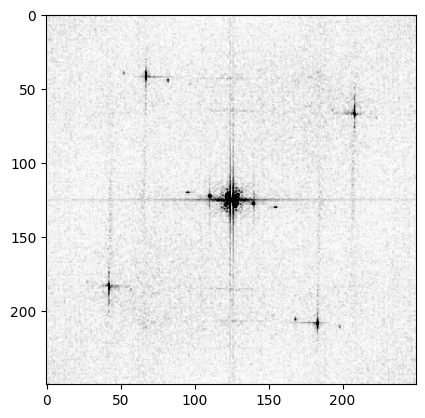

In [9]:
# thre=7e-2
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+4*s2])

# part 2
## (reconstruction then drift correction)

1.0000000061035157


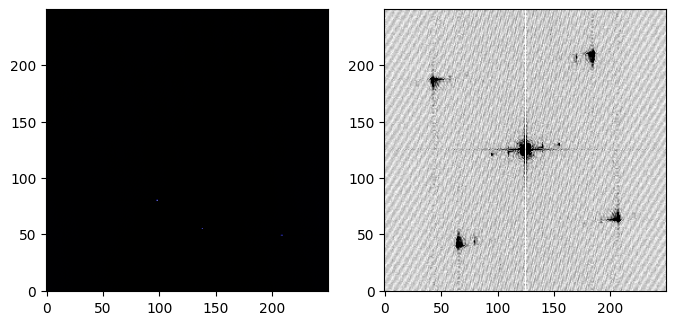

In [10]:
dfc.display(t.z)
t_z = t.z

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.Z)
b = test.T.flat[ri] # using same ri defined above!

In [11]:
testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

Iteration 1:
  fx = 219935917.621735, xnorm = 249.978151, gnorm = 29660.590397, step = 0.000034, k = 1, ls = 1

Iteration 2:
  fx = 119342763.521882, xnorm = 8971.936250, gnorm = 21832.284722, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 762102.272654, xnorm = 16005.570849, gnorm = 1508.357104, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 193134.778028, xnorm = 15920.307061, gnorm = 48.588472, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 192504.884287, xnorm = 15917.252611, gnorm = 11.981265, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 192423.621479, xnorm = 15915.551370, gnorm = 12.080672, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 190324.897203, xnorm = 15843.570683, gnorm = 81.732608, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 189340.194418, xnorm = 15835.407276, gnorm = 78.515815, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 187795.095988, xnorm = 15811.489092, gnorm = 43.013589, step = 0.125000, k = 9, ls = 4

Iteration 10:
  f

Iteration 90:
  fx = 160272.947925, xnorm = 15482.603674, gnorm = 40.305136, step = 0.500000, k = 90, ls = 2

Iteration 91:
  fx = 159781.415160, xnorm = 15469.136182, gnorm = 21.796436, step = 0.500000, k = 91, ls = 2

Iteration 92:
  fx = 159681.081635, xnorm = 15480.056907, gnorm = 39.690294, step = 0.500000, k = 92, ls = 2

Iteration 93:
  fx = 159209.920184, xnorm = 15466.876531, gnorm = 22.201938, step = 0.500000, k = 93, ls = 2

Iteration 94:
  fx = 159100.821656, xnorm = 15478.012902, gnorm = 39.325186, step = 0.500000, k = 94, ls = 2

Iteration 95:
  fx = 158641.482515, xnorm = 15464.722465, gnorm = 22.828108, step = 0.500000, k = 95, ls = 2

Iteration 96:
  fx = 158528.870403, xnorm = 15476.311566, gnorm = 39.448058, step = 0.500000, k = 96, ls = 2

Iteration 97:
  fx = 158066.180641, xnorm = 15462.985415, gnorm = 22.828919, step = 0.500000, k = 97, ls = 2

Iteration 98:
  fx = 157961.453640, xnorm = 15474.906287, gnorm = 39.680928, step = 0.500000, k = 98, ls = 2

Iteration 

Iteration 166:
  fx = 140791.001324, xnorm = 15526.249760, gnorm = 34.570514, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 140432.806323, xnorm = 15515.347297, gnorm = 19.710827, step = 0.500000, k = 167, ls = 2

Iteration 168:
  fx = 140347.834983, xnorm = 15530.313465, gnorm = 34.434881, step = 0.500000, k = 168, ls = 2

Iteration 169:
  fx = 139992.800575, xnorm = 15519.388141, gnorm = 19.802022, step = 0.500000, k = 169, ls = 2

Iteration 170:
  fx = 139911.117959, xnorm = 15534.643807, gnorm = 34.508002, step = 0.500000, k = 170, ls = 2

Iteration 171:
  fx = 139552.386356, xnorm = 15523.813866, gnorm = 19.426996, step = 0.500000, k = 171, ls = 2

Iteration 172:
  fx = 139473.839989, xnorm = 15538.902028, gnorm = 34.331500, step = 0.500000, k = 172, ls = 2

Iteration 173:
  fx = 139118.972472, xnorm = 15528.217952, gnorm = 19.251074, step = 0.500000, k = 173, ls = 2

Iteration 174:
  fx = 139039.466347, xnorm = 15543.230227, gnorm = 34.070566, step = 0.500000, k = 174, 

Iteration 243:
  fx = 125746.071056, xnorm = 15741.619716, gnorm = 17.216862, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 125683.573922, xnorm = 15757.742089, gnorm = 30.092236, step = 0.500000, k = 244, ls = 2

Iteration 245:
  fx = 125408.972343, xnorm = 15749.198471, gnorm = 17.079087, step = 0.500000, k = 245, ls = 2

Iteration 246:
  fx = 125345.880211, xnorm = 15765.197363, gnorm = 29.858807, step = 0.500000, k = 246, ls = 2

Iteration 247:
  fx = 125075.706636, xnorm = 15756.797028, gnorm = 16.970694, step = 0.500000, k = 247, ls = 2

Iteration 248:
  fx = 125014.736881, xnorm = 15772.803824, gnorm = 29.798917, step = 0.500000, k = 248, ls = 2

Iteration 249:
  fx = 124745.583317, xnorm = 15764.462658, gnorm = 16.859310, step = 0.500000, k = 249, ls = 2

Iteration 250:
  fx = 124685.135962, xnorm = 15780.429170, gnorm = 29.662679, step = 0.500000, k = 250, ls = 2

Iteration 251:
  fx = 124418.641090, xnorm = 15772.092620, gnorm = 16.922767, step = 0.500000, k = 251, 

Iteration 320:
  fx = 114456.226617, xnorm = 16079.165780, gnorm = 26.197576, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 114246.788629, xnorm = 16072.569065, gnorm = 15.104460, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 114197.042479, xnorm = 16088.433303, gnorm = 26.113197, step = 0.500000, k = 322, ls = 2

Iteration 323:
  fx = 113988.631517, xnorm = 16081.896884, gnorm = 14.968125, step = 0.500000, k = 323, ls = 2

Iteration 324:
  fx = 113939.961717, xnorm = 16097.695048, gnorm = 26.037291, step = 0.500000, k = 324, ls = 2

Iteration 325:
  fx = 113732.674927, xnorm = 16091.219575, gnorm = 14.871706, step = 0.500000, k = 325, ls = 2

Iteration 326:
  fx = 113685.591953, xnorm = 16106.976685, gnorm = 25.973654, step = 0.500000, k = 326, ls = 2

Iteration 327:
  fx = 113479.316900, xnorm = 16100.584390, gnorm = 14.775592, step = 0.500000, k = 327, ls = 2

Iteration 328:
  fx = 113433.528912, xnorm = 16116.340067, gnorm = 25.923987, step = 0.500000, k = 328, 

Iteration 396:
  fx = 105734.863384, xnorm = 16446.727480, gnorm = 22.968147, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 105572.448332, xnorm = 16441.775969, gnorm = 13.231199, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 105534.481382, xnorm = 16456.675114, gnorm = 22.907333, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 105372.765950, xnorm = 16451.791845, gnorm = 13.106530, step = 0.500000, k = 399, ls = 2

Iteration 400:
  fx = 105335.297985, xnorm = 16466.565017, gnorm = 22.769214, step = 0.500000, k = 400, ls = 2

Iteration 401:
  fx = 105175.741038, xnorm = 16461.757048, gnorm = 13.030697, step = 0.500000, k = 401, ls = 2

Iteration 402:
  fx = 105138.178566, xnorm = 16476.506820, gnorm = 22.668091, step = 0.500000, k = 402, ls = 2

Iteration 403:
  fx = 104980.571934, xnorm = 16471.695467, gnorm = 13.147363, step = 0.500000, k = 403, ls = 2

Iteration 404:
  fx = 104942.563695, xnorm = 16486.507725, gnorm = 22.635893, step = 0.500000, k = 404, 

Iteration 472:
  fx = 98982.835211, xnorm = 16826.241949, gnorm = 20.084102, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 98857.277619, xnorm = 16822.483335, gnorm = 11.647964, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 98826.806088, xnorm = 16836.113201, gnorm = 19.895367, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 98703.754322, xnorm = 16832.405460, gnorm = 11.636606, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 98673.485321, xnorm = 16846.029894, gnorm = 19.898198, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 98550.673511, xnorm = 16842.348131, gnorm = 11.650440, step = 0.500000, k = 477, ls = 2

Iteration 478:
  fx = 98520.418086, xnorm = 16855.985639, gnorm = 19.868143, step = 0.500000, k = 478, ls = 2

Iteration 479:
  fx = 98397.996012, xnorm = 16852.311179, gnorm = 11.652371, step = 0.500000, k = 479, ls = 2

Iteration 480:
  fx = 98367.488056, xnorm = 16865.947529, gnorm = 19.783636, step = 0.500000, k = 480, ls = 2

I

Iteration 546:
  fx = 93889.612371, xnorm = 17188.862652, gnorm = 17.483094, step = 0.500000, k = 546, ls = 2

Iteration 547:
  fx = 93794.964323, xnorm = 17186.123018, gnorm = 10.435172, step = 0.500000, k = 547, ls = 2

Iteration 548:
  fx = 93770.591248, xnorm = 17198.464134, gnorm = 17.559730, step = 0.500000, k = 548, ls = 2

Iteration 549:
  fx = 93674.319004, xnorm = 17195.747989, gnorm = 10.188153, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 93651.651874, xnorm = 17207.965265, gnorm = 17.518292, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 93555.652803, xnorm = 17205.290815, gnorm = 10.082650, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 93532.608151, xnorm = 17217.383250, gnorm = 17.335136, step = 0.500000, k = 552, ls = 2

Iteration 553:
  fx = 93438.946839, xnorm = 17214.748570, gnorm = 10.108645, step = 0.500000, k = 553, ls = 2

Iteration 554:
  fx = 93415.343694, xnorm = 17226.775528, gnorm = 17.241433, step = 0.500000, k = 554, ls = 2

I

Iteration 642:
  fx = 89011.792974, xnorm = 17618.924266, gnorm = 14.502139, step = 0.500000, k = 642, ls = 2

Iteration 643:
  fx = 88945.984442, xnorm = 17617.092562, gnorm = 8.932204, step = 0.500000, k = 643, ls = 2

Iteration 644:
  fx = 88926.822341, xnorm = 17627.334342, gnorm = 14.469314, step = 0.500000, k = 644, ls = 2

Iteration 645:
  fx = 88861.324822, xnorm = 17625.489617, gnorm = 8.891600, step = 0.500000, k = 645, ls = 2

Iteration 646:
  fx = 88842.191100, xnorm = 17635.690254, gnorm = 14.378423, step = 0.500000, k = 646, ls = 2

Iteration 647:
  fx = 88777.360136, xnorm = 17633.869872, gnorm = 8.805428, step = 0.500000, k = 647, ls = 2

Iteration 648:
  fx = 88758.224085, xnorm = 17643.969781, gnorm = 14.278924, step = 0.500000, k = 648, ls = 2

Iteration 649:
  fx = 88694.415915, xnorm = 17642.191447, gnorm = 8.783436, step = 0.500000, k = 649, ls = 2

Iteration 650:
  fx = 88675.255938, xnorm = 17652.195604, gnorm = 14.152484, step = 0.500000, k = 650, ls = 2

Itera

Iteration 731:
  fx = 85769.166451, xnorm = 17961.693554, gnorm = 7.741201, step = 0.500000, k = 731, ls = 2

Iteration 732:
  fx = 85753.986646, xnorm = 17970.196733, gnorm = 11.976304, step = 0.500000, k = 732, ls = 2

Iteration 733:
  fx = 85708.595559, xnorm = 17968.911045, gnorm = 7.680786, step = 0.500000, k = 733, ls = 2

Iteration 734:
  fx = 85693.590888, xnorm = 17977.362151, gnorm = 11.913160, step = 0.500000, k = 734, ls = 2

Iteration 735:
  fx = 85648.674451, xnorm = 17976.090218, gnorm = 7.669641, step = 0.500000, k = 735, ls = 2

Iteration 736:
  fx = 85633.631657, xnorm = 17984.500532, gnorm = 11.833022, step = 0.500000, k = 736, ls = 2

Iteration 737:
  fx = 85589.306089, xnorm = 17983.232567, gnorm = 7.648142, step = 0.500000, k = 737, ls = 2

Iteration 738:
  fx = 85574.518341, xnorm = 17991.601020, gnorm = 11.809551, step = 0.500000, k = 738, ls = 2

Iteration 739:
  fx = 85530.348524, xnorm = 17990.348860, gnorm = 7.613908, step = 0.500000, k = 739, ls = 2

Iterat

Iteration 827:
  fx = 83318.629214, xnorm = 18279.566810, gnorm = 6.530746, step = 0.500000, k = 827, ls = 2

Iteration 828:
  fx = 83307.246962, xnorm = 18286.403190, gnorm = 9.787636, step = 0.500000, k = 828, ls = 2

Iteration 829:
  fx = 83276.735154, xnorm = 18285.561028, gnorm = 6.513063, step = 0.500000, k = 829, ls = 2

Iteration 830:
  fx = 83265.381139, xnorm = 18292.405976, gnorm = 9.758242, step = 0.500000, k = 830, ls = 2

Iteration 831:
  fx = 83235.083400, xnorm = 18291.558781, gnorm = 6.485668, step = 0.500000, k = 831, ls = 2

Iteration 832:
  fx = 83223.994032, xnorm = 18298.375735, gnorm = 9.746969, step = 0.500000, k = 832, ls = 2

Iteration 833:
  fx = 83193.638024, xnorm = 18297.531749, gnorm = 6.405899, step = 0.500000, k = 833, ls = 2

Iteration 834:
  fx = 83182.749556, xnorm = 18304.292572, gnorm = 9.687888, step = 0.500000, k = 834, ls = 2

Iteration 835:
  fx = 83152.741764, xnorm = 18303.457668, gnorm = 6.356242, step = 0.500000, k = 835, ls = 2

Iteration 

Iteration 915:
  fx = 81723.922998, xnorm = 18522.857289, gnorm = 5.632336, step = 0.500000, k = 915, ls = 2

Iteration 916:
  fx = 81715.277796, xnorm = 18528.536618, gnorm = 8.376782, step = 0.500000, k = 916, ls = 2

Iteration 917:
  fx = 81692.834561, xnorm = 18527.950407, gnorm = 5.616607, step = 0.500000, k = 917, ls = 2

Iteration 918:
  fx = 81684.115709, xnorm = 18533.596144, gnorm = 8.300965, step = 0.500000, k = 918, ls = 2

Iteration 919:
  fx = 81662.070686, xnorm = 18533.023159, gnorm = 5.581724, step = 0.500000, k = 919, ls = 2

Iteration 920:
  fx = 81653.558117, xnorm = 18538.629571, gnorm = 8.278007, step = 0.500000, k = 920, ls = 2

Iteration 921:
  fx = 81631.629274, xnorm = 18538.063648, gnorm = 5.583284, step = 0.500000, k = 921, ls = 2

Iteration 922:
  fx = 81623.062671, xnorm = 18543.660867, gnorm = 8.237145, step = 0.500000, k = 922, ls = 2

Iteration 923:
  fx = 81601.391183, xnorm = 18543.101522, gnorm = 5.608387, step = 0.500000, k = 923, ls = 2

Iteration 

Iteration 1012:
  fx = 80444.793798, xnorm = 18751.289940, gnorm = 7.038140, step = 0.500000, k = 1012, ls = 2

Iteration 1013:
  fx = 80428.760949, xnorm = 18750.916573, gnorm = 4.836464, step = 0.500000, k = 1013, ls = 2

Iteration 1014:
  fx = 80422.386430, xnorm = 18755.513566, gnorm = 7.019941, step = 0.500000, k = 1014, ls = 2

Iteration 1015:
  fx = 80406.376091, xnorm = 18755.145377, gnorm = 4.797118, step = 0.500000, k = 1015, ls = 2

Iteration 1016:
  fx = 80400.059388, xnorm = 18759.722721, gnorm = 7.008962, step = 0.500000, k = 1016, ls = 2

Iteration 1017:
  fx = 80384.183616, xnorm = 18759.356076, gnorm = 4.824974, step = 0.500000, k = 1017, ls = 2

Iteration 1018:
  fx = 80377.829863, xnorm = 18763.936621, gnorm = 6.994060, step = 0.500000, k = 1018, ls = 2

Iteration 1019:
  fx = 80361.950612, xnorm = 18763.562621, gnorm = 4.798926, step = 0.500000, k = 1019, ls = 2

Iteration 1020:
  fx = 80355.698946, xnorm = 18768.149550, gnorm = 7.002567, step = 0.500000, k = 1020, 

Iteration 1086:
  fx = 79692.022453, xnorm = 18900.398629, gnorm = 6.197162, step = 0.500000, k = 1086, ls = 2

Iteration 1087:
  fx = 79679.713586, xnorm = 18900.129174, gnorm = 4.403674, step = 0.500000, k = 1087, ls = 2

Iteration 1088:
  fx = 79674.292913, xnorm = 18904.174230, gnorm = 6.214995, step = 0.500000, k = 1088, ls = 2

Iteration 1089:
  fx = 79661.833473, xnorm = 18903.908592, gnorm = 4.368006, step = 0.500000, k = 1089, ls = 2

Iteration 1090:
  fx = 79656.495527, xnorm = 18907.922392, gnorm = 6.197228, step = 0.500000, k = 1090, ls = 2

Iteration 1091:
  fx = 79644.063583, xnorm = 18907.671014, gnorm = 4.321291, step = 0.500000, k = 1091, ls = 2

Iteration 1092:
  fx = 79638.803241, xnorm = 18911.635708, gnorm = 6.155760, step = 0.500000, k = 1092, ls = 2

Iteration 1093:
  fx = 79626.551263, xnorm = 18911.390934, gnorm = 4.311645, step = 0.500000, k = 1093, ls = 2

Iteration 1094:
  fx = 79621.351323, xnorm = 18915.330359, gnorm = 6.133213, step = 0.500000, k = 1094, 

Iteration 1173:
  fx = 79007.039579, xnorm = 19049.064575, gnorm = 3.892776, step = 0.500000, k = 1173, ls = 2

Iteration 1174:
  fx = 79002.770941, xnorm = 19052.439977, gnorm = 5.392088, step = 0.500000, k = 1174, ls = 2

Iteration 1175:
  fx = 78993.294419, xnorm = 19052.263622, gnorm = 3.850867, step = 0.500000, k = 1175, ls = 2

Iteration 1176:
  fx = 78989.095450, xnorm = 19055.620274, gnorm = 5.374876, step = 0.500000, k = 1176, ls = 2

Iteration 1177:
  fx = 78979.687960, xnorm = 19055.440151, gnorm = 3.825674, step = 0.500000, k = 1177, ls = 2

Iteration 1178:
  fx = 78975.544021, xnorm = 19058.776055, gnorm = 5.345283, step = 0.500000, k = 1178, ls = 2

Iteration 1179:
  fx = 78966.226877, xnorm = 19058.601099, gnorm = 3.800157, step = 0.500000, k = 1179, ls = 2

Iteration 1180:
  fx = 78962.115931, xnorm = 19061.906729, gnorm = 5.311744, step = 0.500000, k = 1180, ls = 2

Iteration 1181:
  fx = 78952.909935, xnorm = 19061.740627, gnorm = 3.786082, step = 0.500000, k = 1181, 

Iteration 1266:
  fx = 78458.286532, xnorm = 19186.454831, gnorm = 4.663402, step = 0.500000, k = 1266, ls = 2

Iteration 1267:
  fx = 78451.153031, xnorm = 19186.337333, gnorm = 3.328262, step = 0.500000, k = 1267, ls = 2

Iteration 1268:
  fx = 78448.006027, xnorm = 19189.150748, gnorm = 4.647365, step = 0.500000, k = 1268, ls = 2

Iteration 1269:
  fx = 78440.934489, xnorm = 19189.026100, gnorm = 3.314514, step = 0.500000, k = 1269, ls = 2

Iteration 1270:
  fx = 78437.815958, xnorm = 19191.829744, gnorm = 4.634845, step = 0.500000, k = 1270, ls = 2

Iteration 1271:
  fx = 78430.770426, xnorm = 19191.708318, gnorm = 3.304571, step = 0.500000, k = 1271, ls = 2

Iteration 1272:
  fx = 78427.623819, xnorm = 19194.495678, gnorm = 4.600095, step = 0.500000, k = 1272, ls = 2

Iteration 1273:
  fx = 78420.702171, xnorm = 19194.372699, gnorm = 3.305931, step = 0.500000, k = 1273, ls = 2

Iteration 1274:
  fx = 78417.532712, xnorm = 19197.140136, gnorm = 4.568587, step = 0.500000, k = 1274, 

Iteration 1354:
  fx = 78061.564445, xnorm = 19295.287440, gnorm = 4.034861, step = 0.500000, k = 1354, ls = 2

Iteration 1355:
  fx = 78056.257513, xnorm = 19295.207284, gnorm = 2.986624, step = 0.500000, k = 1355, ls = 2

Iteration 1356:
  fx = 78053.639774, xnorm = 19297.577547, gnorm = 4.022884, step = 0.500000, k = 1356, ls = 2

Iteration 1357:
  fx = 78048.348909, xnorm = 19297.499226, gnorm = 2.969991, step = 0.500000, k = 1357, ls = 2

Iteration 1358:
  fx = 78045.811464, xnorm = 19299.851514, gnorm = 4.023099, step = 0.500000, k = 1358, ls = 2

Iteration 1359:
  fx = 78040.513787, xnorm = 19299.775048, gnorm = 2.933009, step = 0.500000, k = 1359, ls = 2

Iteration 1360:
  fx = 78038.011827, xnorm = 19302.101567, gnorm = 3.995332, step = 0.500000, k = 1360, ls = 2

Iteration 1361:
  fx = 78032.758106, xnorm = 19302.029302, gnorm = 2.894779, step = 0.500000, k = 1361, ls = 2

Iteration 1362:
  fx = 78030.287303, xnorm = 19304.339341, gnorm = 3.975780, step = 0.500000, k = 1362, 

Iteration 1446:
  fx = 77742.032834, xnorm = 19392.987444, gnorm = 3.603745, step = 0.500000, k = 1446, ls = 2

Iteration 1447:
  fx = 77737.769625, xnorm = 19392.936147, gnorm = 2.566620, step = 0.500000, k = 1447, ls = 2

Iteration 1448:
  fx = 77735.865563, xnorm = 19394.996008, gnorm = 3.589511, step = 0.500000, k = 1448, ls = 2

Iteration 1449:
  fx = 77731.657734, xnorm = 19394.941110, gnorm = 2.582255, step = 0.500000, k = 1449, ls = 2

Iteration 1450:
  fx = 77729.715313, xnorm = 19396.995994, gnorm = 3.575298, step = 0.500000, k = 1450, ls = 2

Iteration 1451:
  fx = 77725.533569, xnorm = 19396.941200, gnorm = 2.583308, step = 0.500000, k = 1451, ls = 2

Iteration 1452:
  fx = 77723.596776, xnorm = 19398.991529, gnorm = 3.574446, step = 0.500000, k = 1452, ls = 2

Iteration 1453:
  fx = 77719.439991, xnorm = 19398.938939, gnorm = 2.572415, step = 0.500000, k = 1453, ls = 2

Iteration 1454:
  fx = 77717.527537, xnorm = 19400.982657, gnorm = 3.572889, step = 0.500000, k = 1454, 

Iteration 1535:
  fx = 77495.925342, xnorm = 19475.586655, gnorm = 2.323723, step = 0.500000, k = 1535, ls = 2

Iteration 1536:
  fx = 77494.362776, xnorm = 19477.342392, gnorm = 3.176315, step = 0.500000, k = 1536, ls = 2

Iteration 1537:
  fx = 77491.057124, xnorm = 19477.320270, gnorm = 2.314732, step = 0.500000, k = 1537, ls = 2

Iteration 1538:
  fx = 77489.527149, xnorm = 19479.064101, gnorm = 3.175358, step = 0.500000, k = 1538, ls = 2

Iteration 1539:
  fx = 77486.204551, xnorm = 19479.046648, gnorm = 2.280183, step = 0.500000, k = 1539, ls = 2

Iteration 1540:
  fx = 77484.679173, xnorm = 19480.776557, gnorm = 3.151823, step = 0.500000, k = 1540, ls = 2

Iteration 1541:
  fx = 77481.421516, xnorm = 19480.751145, gnorm = 2.298398, step = 0.500000, k = 1541, ls = 2

Iteration 1542:
  fx = 77479.860884, xnorm = 19482.482891, gnorm = 3.142312, step = 0.500000, k = 1542, ls = 2

Iteration 1543:
  fx = 77476.624570, xnorm = 19482.459290, gnorm = 2.307451, step = 0.500000, k = 1543, 

Iteration 1626:
  fx = 77297.071555, xnorm = 19550.210244, gnorm = 2.930527, step = 0.500000, k = 1626, ls = 2

Iteration 1627:
  fx = 77294.238811, xnorm = 19550.221344, gnorm = 2.026402, step = 0.500000, k = 1627, ls = 2

Iteration 1628:
  fx = 77293.121929, xnorm = 19551.748912, gnorm = 2.934116, step = 0.500000, k = 1628, ls = 2

Iteration 1629:
  fx = 77290.266828, xnorm = 19551.757551, gnorm = 2.008589, step = 0.500000, k = 1629, ls = 2

Iteration 1630:
  fx = 77289.174346, xnorm = 19553.278615, gnorm = 2.930485, step = 0.500000, k = 1630, ls = 2

Iteration 1631:
  fx = 77286.320112, xnorm = 19553.284505, gnorm = 1.984830, step = 0.500000, k = 1631, ls = 2

Iteration 1632:
  fx = 77285.200840, xnorm = 19554.790730, gnorm = 2.888699, step = 0.500000, k = 1632, ls = 2

Iteration 1633:
  fx = 77282.440862, xnorm = 19554.794149, gnorm = 2.005337, step = 0.500000, k = 1633, ls = 2

Iteration 1634:
  fx = 77281.271460, xnorm = 19556.304486, gnorm = 2.869912, step = 0.500000, k = 1634, 

Iteration 1715:
  fx = 77137.566365, xnorm = 19613.145711, gnorm = 1.827316, step = 0.500000, k = 1715, ls = 2

Iteration 1716:
  fx = 77136.646580, xnorm = 19614.481979, gnorm = 2.639461, step = 0.500000, k = 1716, ls = 2

Iteration 1717:
  fx = 77134.343082, xnorm = 19614.492677, gnorm = 1.822406, step = 0.500000, k = 1717, ls = 2

Iteration 1718:
  fx = 77133.425340, xnorm = 19615.818164, gnorm = 2.628585, step = 0.500000, k = 1718, ls = 2

Iteration 1719:
  fx = 77131.131620, xnorm = 19615.830460, gnorm = 1.809746, step = 0.500000, k = 1719, ls = 2

Iteration 1720:
  fx = 77130.216510, xnorm = 19617.148592, gnorm = 2.615172, step = 0.500000, k = 1720, ls = 2

Iteration 1721:
  fx = 77127.949500, xnorm = 19617.162273, gnorm = 1.805934, step = 0.500000, k = 1721, ls = 2

Iteration 1722:
  fx = 77127.022614, xnorm = 19618.474030, gnorm = 2.598283, step = 0.500000, k = 1722, ls = 2

Iteration 1723:
  fx = 77124.798145, xnorm = 19618.487966, gnorm = 1.819863, step = 0.500000, k = 1723, 

Iteration 1806:
  fx = 77006.253655, xnorm = 19671.101631, gnorm = 2.358251, step = 0.500000, k = 1806, ls = 2

Iteration 1807:
  fx = 77004.411712, xnorm = 19671.108664, gnorm = 1.648004, step = 0.500000, k = 1807, ls = 2

Iteration 1808:
  fx = 77003.628623, xnorm = 19672.279142, gnorm = 2.339573, step = 0.500000, k = 1808, ls = 2

Iteration 1809:
  fx = 77001.823636, xnorm = 19672.288583, gnorm = 1.650009, step = 0.500000, k = 1809, ls = 2

Iteration 1810:
  fx = 77001.041631, xnorm = 19673.455477, gnorm = 2.334745, step = 0.500000, k = 1810, ls = 2

Iteration 1811:
  fx = 76999.242857, xnorm = 19673.463084, gnorm = 1.653902, step = 0.500000, k = 1811, ls = 2

Iteration 1812:
  fx = 76998.468137, xnorm = 19674.630458, gnorm = 2.332460, step = 0.500000, k = 1812, ls = 2

Iteration 1813:
  fx = 76996.668258, xnorm = 19674.638192, gnorm = 1.647826, step = 0.500000, k = 1813, ls = 2

Iteration 1814:
  fx = 76995.900862, xnorm = 19675.798737, gnorm = 2.324625, step = 0.500000, k = 1814, 

Iteration 1895:
  fx = 76901.977831, xnorm = 19719.375462, gnorm = 1.487887, step = 0.500000, k = 1895, ls = 2

Iteration 1896:
  fx = 76901.346807, xnorm = 19720.385937, gnorm = 2.097011, step = 0.500000, k = 1896, ls = 2

Iteration 1897:
  fx = 76899.888016, xnorm = 19720.398448, gnorm = 1.493428, step = 0.500000, k = 1897, ls = 2

Iteration 1898:
  fx = 76899.262030, xnorm = 19721.408459, gnorm = 2.102770, step = 0.500000, k = 1898, ls = 2

Iteration 1899:
  fx = 76897.796494, xnorm = 19721.423489, gnorm = 1.494275, step = 0.500000, k = 1899, ls = 2

Iteration 1900:
  fx = 76897.164871, xnorm = 19722.430784, gnorm = 2.097680, step = 0.500000, k = 1900, ls = 2

Iteration 1901:
  fx = 76895.700700, xnorm = 19722.445767, gnorm = 1.484119, step = 0.500000, k = 1901, ls = 2

Iteration 1902:
  fx = 76895.074597, xnorm = 19723.450707, gnorm = 2.089774, step = 0.500000, k = 1902, ls = 2

Iteration 1903:
  fx = 76893.620810, xnorm = 19723.466532, gnorm = 1.478527, step = 0.500000, k = 1903, 

Iteration 1981:
  fx = 76819.950454, xnorm = 19760.899876, gnorm = 1.351653, step = 0.500000, k = 1981, ls = 2

Iteration 1982:
  fx = 76819.436092, xnorm = 19761.791960, gnorm = 1.902309, step = 0.500000, k = 1982, ls = 2

Iteration 1983:
  fx = 76818.226625, xnorm = 19761.798892, gnorm = 1.338073, step = 0.500000, k = 1983, ls = 2

Iteration 1984:
  fx = 76817.721766, xnorm = 19762.690687, gnorm = 1.893075, step = 0.500000, k = 1984, ls = 2

Iteration 1985:
  fx = 76816.520535, xnorm = 19762.695619, gnorm = 1.329587, step = 0.500000, k = 1985, ls = 2

Iteration 1986:
  fx = 76816.030393, xnorm = 19763.585458, gnorm = 1.898587, step = 0.500000, k = 1986, ls = 2

Iteration 1987:
  fx = 76814.822796, xnorm = 19763.590619, gnorm = 1.324484, step = 0.500000, k = 1987, ls = 2

Iteration 1988:
  fx = 76814.344295, xnorm = 19764.479904, gnorm = 1.905163, step = 0.500000, k = 1988, ls = 2

Iteration 1989:
  fx = 76813.125107, xnorm = 19764.486496, gnorm = 1.318628, step = 0.500000, k = 1989, 

Iteration 2069:
  fx = 76749.029554, xnorm = 19799.466190, gnorm = 1.251726, step = 0.500000, k = 2069, ls = 2

Iteration 2070:
  fx = 76748.596809, xnorm = 19800.282229, gnorm = 1.774996, step = 0.500000, k = 2070, ls = 2

Iteration 2071:
  fx = 76747.546009, xnorm = 19800.301562, gnorm = 1.233501, step = 0.500000, k = 2071, ls = 2

Iteration 2072:
  fx = 76747.127438, xnorm = 19801.114830, gnorm = 1.772900, step = 0.500000, k = 2072, ls = 2

Iteration 2073:
  fx = 76746.078796, xnorm = 19801.132450, gnorm = 1.225283, step = 0.500000, k = 2073, ls = 2

Iteration 2074:
  fx = 76745.671939, xnorm = 19801.943164, gnorm = 1.775979, step = 0.500000, k = 2074, ls = 2

Iteration 2075:
  fx = 76744.617566, xnorm = 19801.961621, gnorm = 1.210285, step = 0.500000, k = 2075, ls = 2

Iteration 2076:
  fx = 76744.213388, xnorm = 19802.765687, gnorm = 1.759657, step = 0.500000, k = 2076, ls = 2

Iteration 2077:
  fx = 76743.177291, xnorm = 19802.783320, gnorm = 1.210726, step = 0.500000, k = 2077, 

Iteration 2160:
  fx = 76687.421984, xnorm = 19835.874182, gnorm = 1.692194, step = 0.500000, k = 2160, ls = 2

Iteration 2161:
  fx = 76686.467935, xnorm = 19835.895601, gnorm = 1.102746, step = 0.500000, k = 2161, ls = 2

Iteration 2162:
  fx = 76686.158109, xnorm = 19836.633688, gnorm = 1.695406, step = 0.500000, k = 2162, ls = 2

Iteration 2163:
  fx = 76685.196544, xnorm = 19836.656599, gnorm = 1.089249, step = 0.500000, k = 2163, ls = 2

Iteration 2164:
  fx = 76684.895957, xnorm = 19837.388666, gnorm = 1.691134, step = 0.500000, k = 2164, ls = 2

Iteration 2165:
  fx = 76683.936639, xnorm = 19837.413895, gnorm = 1.082068, step = 0.500000, k = 2165, ls = 2

Iteration 2166:
  fx = 76683.638859, xnorm = 19838.143014, gnorm = 1.688644, step = 0.500000, k = 2166, ls = 2

Iteration 2167:
  fx = 76682.685351, xnorm = 19838.166965, gnorm = 1.087151, step = 0.500000, k = 2167, ls = 2

Iteration 2168:
  fx = 76682.380755, xnorm = 19838.898902, gnorm = 1.684088, step = 0.500000, k = 2168, 

Iteration 2246:
  fx = 76637.111659, xnorm = 19866.874651, gnorm = 1.558338, step = 0.500000, k = 2246, ls = 2

Iteration 2247:
  fx = 76636.294613, xnorm = 19866.886531, gnorm = 1.007301, step = 0.500000, k = 2247, ls = 2

Iteration 2248:
  fx = 76636.036574, xnorm = 19867.555420, gnorm = 1.556043, step = 0.500000, k = 2248, ls = 2

Iteration 2249:
  fx = 76635.223549, xnorm = 19867.567714, gnorm = 1.005883, step = 0.500000, k = 2249, ls = 2

Iteration 2250:
  fx = 76634.967924, xnorm = 19868.235164, gnorm = 1.556826, step = 0.500000, k = 2250, ls = 2

Iteration 2251:
  fx = 76634.151060, xnorm = 19868.248771, gnorm = 0.993104, step = 0.500000, k = 2251, ls = 2

Iteration 2252:
  fx = 76633.901160, xnorm = 19868.913462, gnorm = 1.554783, step = 0.500000, k = 2252, ls = 2

Iteration 2253:
  fx = 76633.088476, xnorm = 19868.929131, gnorm = 0.992799, step = 0.500000, k = 2253, ls = 2

Iteration 2254:
  fx = 76632.834455, xnorm = 19869.592531, gnorm = 1.547630, step = 0.500000, k = 2254, 

Iteration 2339:
  fx = 76590.835890, xnorm = 19896.842363, gnorm = 0.948782, step = 0.500000, k = 2339, ls = 2

Iteration 2340:
  fx = 76590.588932, xnorm = 19897.434939, gnorm = 1.404895, step = 0.500000, k = 2340, ls = 2

Iteration 2341:
  fx = 76589.935645, xnorm = 19897.454934, gnorm = 0.952843, step = 0.500000, k = 2341, ls = 2

Iteration 2342:
  fx = 76589.682344, xnorm = 19898.047917, gnorm = 1.394756, step = 0.500000, k = 2342, ls = 2

Iteration 2343:
  fx = 76589.037095, xnorm = 19898.067652, gnorm = 0.952166, step = 0.500000, k = 2343, ls = 2

Iteration 2344:
  fx = 76588.784243, xnorm = 19898.656757, gnorm = 1.389851, step = 0.500000, k = 2344, ls = 2

Iteration 2345:
  fx = 76588.145051, xnorm = 19898.676044, gnorm = 0.955163, step = 0.500000, k = 2345, ls = 2

Iteration 2346:
  fx = 76587.892733, xnorm = 19899.265874, gnorm = 1.388918, step = 0.500000, k = 2346, ls = 2

Iteration 2347:
  fx = 76587.252830, xnorm = 19899.285963, gnorm = 0.952149, step = 0.500000, k = 2347, 

Iteration 2426:
  fx = 76554.797185, xnorm = 19922.239457, gnorm = 1.293371, step = 0.500000, k = 2426, ls = 2

Iteration 2427:
  fx = 76554.237950, xnorm = 19922.256584, gnorm = 0.863040, step = 0.500000, k = 2427, ls = 2

Iteration 2428:
  fx = 76554.036284, xnorm = 19922.787166, gnorm = 1.293327, step = 0.500000, k = 2428, ls = 2

Iteration 2429:
  fx = 76553.478137, xnorm = 19922.802735, gnorm = 0.867162, step = 0.500000, k = 2429, ls = 2

Iteration 2430:
  fx = 76553.274595, xnorm = 19923.335063, gnorm = 1.291439, step = 0.500000, k = 2430, ls = 2

Iteration 2431:
  fx = 76552.718768, xnorm = 19923.350690, gnorm = 0.871128, step = 0.500000, k = 2431, ls = 2

Iteration 2432:
  fx = 76552.513576, xnorm = 19923.882040, gnorm = 1.290014, step = 0.500000, k = 2432, ls = 2

Iteration 2433:
  fx = 76551.958277, xnorm = 19923.898293, gnorm = 0.869635, step = 0.500000, k = 2433, ls = 2

Iteration 2434:
  fx = 76551.752983, xnorm = 19924.428344, gnorm = 1.287845, step = 0.500000, k = 2434, 

Iteration 2518:
  fx = 76521.890014, xnorm = 19946.350906, gnorm = 1.245347, step = 0.500000, k = 2518, ls = 2

Iteration 2519:
  fx = 76521.371576, xnorm = 19946.368641, gnorm = 0.784686, step = 0.500000, k = 2519, ls = 2

Iteration 2520:
  fx = 76521.218602, xnorm = 19946.853847, gnorm = 1.241883, step = 0.500000, k = 2520, ls = 2

Iteration 2521:
  fx = 76520.703099, xnorm = 19946.872538, gnorm = 0.784792, step = 0.500000, k = 2521, ls = 2

Iteration 2522:
  fx = 76520.549826, xnorm = 19947.355011, gnorm = 1.234169, step = 0.500000, k = 2522, ls = 2

Iteration 2523:
  fx = 76520.040423, xnorm = 19947.374220, gnorm = 0.785270, step = 0.500000, k = 2523, ls = 2

Iteration 2524:
  fx = 76519.884882, xnorm = 19947.855587, gnorm = 1.228080, step = 0.500000, k = 2524, ls = 2

Iteration 2525:
  fx = 76519.381368, xnorm = 19947.872566, gnorm = 0.781926, step = 0.500000, k = 2525, ls = 2

Iteration 2526:
  fx = 76519.227474, xnorm = 19948.352187, gnorm = 1.224077, step = 0.500000, k = 2526, 

Iteration 2605:
  fx = 76494.750075, xnorm = 19966.882575, gnorm = 0.741354, step = 0.500000, k = 2605, ls = 2

Iteration 2606:
  fx = 76494.608062, xnorm = 19967.320609, gnorm = 1.152212, step = 0.500000, k = 2606, ls = 2

Iteration 2607:
  fx = 76494.165388, xnorm = 19967.341017, gnorm = 0.741799, step = 0.500000, k = 2607, ls = 2

Iteration 2608:
  fx = 76494.023228, xnorm = 19967.781284, gnorm = 1.152526, step = 0.500000, k = 2608, ls = 2

Iteration 2609:
  fx = 76493.580685, xnorm = 19967.801071, gnorm = 0.742491, step = 0.500000, k = 2609, ls = 2

Iteration 2610:
  fx = 76493.443500, xnorm = 19968.243868, gnorm = 1.158054, step = 0.500000, k = 2610, ls = 2

Iteration 2611:
  fx = 76492.994238, xnorm = 19968.261042, gnorm = 0.730012, step = 0.500000, k = 2611, ls = 2

Iteration 2612:
  fx = 76492.863284, xnorm = 19968.699880, gnorm = 1.158252, step = 0.500000, k = 2612, ls = 2

Iteration 2613:
  fx = 76492.412616, xnorm = 19968.718123, gnorm = 0.724621, step = 0.500000, k = 2613, 

Iteration 2698:
  fx = 76469.463466, xnorm = 19987.531171, gnorm = 1.057095, step = 0.500000, k = 2698, ls = 2

Iteration 2699:
  fx = 76469.089195, xnorm = 19987.556181, gnorm = 0.686240, step = 0.500000, k = 2699, ls = 2

Iteration 2700:
  fx = 76468.962660, xnorm = 19987.943834, gnorm = 1.049852, step = 0.500000, k = 2700, ls = 2

Iteration 2701:
  fx = 76468.593661, xnorm = 19987.966985, gnorm = 0.686265, step = 0.500000, k = 2701, ls = 2

Iteration 2702:
  fx = 76468.464739, xnorm = 19988.354872, gnorm = 1.045244, step = 0.500000, k = 2702, ls = 2

Iteration 2703:
  fx = 76468.101352, xnorm = 19988.378218, gnorm = 0.696222, step = 0.500000, k = 2703, ls = 2

Iteration 2704:
  fx = 76467.970412, xnorm = 19988.766922, gnorm = 1.047242, step = 0.500000, k = 2704, ls = 2

Iteration 2705:
  fx = 76467.606730, xnorm = 19988.790490, gnorm = 0.697139, step = 0.500000, k = 2705, ls = 2

Iteration 2706:
  fx = 76467.476810, xnorm = 19989.179610, gnorm = 1.048401, step = 0.500000, k = 2706, 

Iteration 2784:
  fx = 76449.033369, xnorm = 20004.858075, gnorm = 1.013043, step = 0.500000, k = 2784, ls = 2

Iteration 2785:
  fx = 76448.691196, xnorm = 20004.881615, gnorm = 0.646442, step = 0.500000, k = 2785, ls = 2

Iteration 2786:
  fx = 76448.580829, xnorm = 20005.249961, gnorm = 1.002541, step = 0.500000, k = 2786, ls = 2

Iteration 2787:
  fx = 76448.247130, xnorm = 20005.272953, gnorm = 0.653287, step = 0.500000, k = 2787, ls = 2

Iteration 2788:
  fx = 76448.132543, xnorm = 20005.640578, gnorm = 0.993199, step = 0.500000, k = 2788, ls = 2

Iteration 2789:
  fx = 76447.805390, xnorm = 20005.662823, gnorm = 0.655444, step = 0.500000, k = 2789, ls = 2

Iteration 2790:
  fx = 76447.688655, xnorm = 20006.028665, gnorm = 0.987638, step = 0.500000, k = 2790, ls = 2

Iteration 2791:
  fx = 76447.366810, xnorm = 20006.050919, gnorm = 0.661159, step = 0.500000, k = 2791, ls = 2

Iteration 2792:
  fx = 76447.249230, xnorm = 20006.416716, gnorm = 0.984752, step = 0.500000, k = 2792, 

Iteration 2876:
  fx = 76429.823882, xnorm = 20022.016162, gnorm = 0.959592, step = 0.500000, k = 2876, ls = 2

Iteration 2877:
  fx = 76429.516335, xnorm = 20022.037303, gnorm = 0.595590, step = 0.500000, k = 2877, ls = 2

Iteration 2878:
  fx = 76429.432375, xnorm = 20022.376394, gnorm = 0.965397, step = 0.500000, k = 2878, ls = 2

Iteration 2879:
  fx = 76429.120073, xnorm = 20022.398589, gnorm = 0.589648, step = 0.500000, k = 2879, ls = 2

Iteration 2880:
  fx = 76429.039336, xnorm = 20022.735453, gnorm = 0.965842, step = 0.500000, k = 2880, ls = 2

Iteration 2881:
  fx = 76428.726022, xnorm = 20022.757488, gnorm = 0.584155, step = 0.500000, k = 2881, ls = 2

Iteration 2882:
  fx = 76428.646775, xnorm = 20023.092311, gnorm = 0.963556, step = 0.500000, k = 2882, ls = 2

Iteration 2883:
  fx = 76428.334480, xnorm = 20023.114951, gnorm = 0.578780, step = 0.500000, k = 2883, ls = 2

Iteration 2884:
  fx = 76428.255763, xnorm = 20023.447715, gnorm = 0.957735, step = 0.500000, k = 2884, 

Iteration 2962:
  fx = 76413.875740, xnorm = 20036.909116, gnorm = 0.900684, step = 0.500000, k = 2962, ls = 2

Iteration 2963:
  fx = 76413.604332, xnorm = 20036.930594, gnorm = 0.557665, step = 0.500000, k = 2963, ls = 2

Iteration 2964:
  fx = 76413.527341, xnorm = 20037.241130, gnorm = 0.900306, step = 0.500000, k = 2964, ls = 2

Iteration 2965:
  fx = 76413.256527, xnorm = 20037.261603, gnorm = 0.558260, step = 0.500000, k = 2965, ls = 2

Iteration 2966:
  fx = 76413.178368, xnorm = 20037.571346, gnorm = 0.899019, step = 0.500000, k = 2966, ls = 2

Iteration 2967:
  fx = 76412.909030, xnorm = 20037.591924, gnorm = 0.561543, step = 0.500000, k = 2967, ls = 2

Iteration 2968:
  fx = 76412.831899, xnorm = 20037.902210, gnorm = 0.901908, step = 0.500000, k = 2968, ls = 2

Iteration 2969:
  fx = 76412.559769, xnorm = 20037.922561, gnorm = 0.558041, step = 0.500000, k = 2969, ls = 2

Iteration 2970:
  fx = 76412.484636, xnorm = 20038.234034, gnorm = 0.903716, step = 0.500000, k = 2970, 

Iteration 3055:
  fx = 76398.304756, xnorm = 20051.721201, gnorm = 0.530395, step = 0.500000, k = 3055, ls = 2

Iteration 3056:
  fx = 76398.233064, xnorm = 20052.008243, gnorm = 0.847580, step = 0.500000, k = 3056, ls = 2

Iteration 3057:
  fx = 76397.994437, xnorm = 20052.028137, gnorm = 0.536750, step = 0.500000, k = 3057, ls = 2

Iteration 3058:
  fx = 76397.921798, xnorm = 20052.317123, gnorm = 0.848258, step = 0.500000, k = 3058, ls = 2

Iteration 3059:
  fx = 76397.682913, xnorm = 20052.336507, gnorm = 0.537068, step = 0.500000, k = 3059, ls = 2

Iteration 3060:
  fx = 76397.609800, xnorm = 20052.625061, gnorm = 0.847902, step = 0.500000, k = 3060, ls = 2

Iteration 3061:
  fx = 76397.371530, xnorm = 20052.645123, gnorm = 0.537050, step = 0.500000, k = 3061, ls = 2

Iteration 3062:
  fx = 76397.299422, xnorm = 20052.933556, gnorm = 0.847865, step = 0.500000, k = 3062, ls = 2

Iteration 3063:
  fx = 76397.059718, xnorm = 20052.952861, gnorm = 0.529662, step = 0.500000, k = 3063, 

Iteration 3142:
  fx = 76385.611353, xnorm = 20064.779609, gnorm = 0.806592, step = 0.500000, k = 3142, ls = 2

Iteration 3143:
  fx = 76385.392614, xnorm = 20064.800780, gnorm = 0.491013, step = 0.500000, k = 3143, ls = 2

Iteration 3144:
  fx = 76385.334841, xnorm = 20065.066680, gnorm = 0.803070, step = 0.500000, k = 3144, ls = 2

Iteration 3145:
  fx = 76385.118183, xnorm = 20065.088145, gnorm = 0.489117, step = 0.500000, k = 3145, ls = 2

Iteration 3146:
  fx = 76385.060372, xnorm = 20065.352031, gnorm = 0.800887, step = 0.500000, k = 3146, ls = 2

Iteration 3147:
  fx = 76384.845589, xnorm = 20065.373732, gnorm = 0.491950, step = 0.500000, k = 3147, ls = 2

Iteration 3148:
  fx = 76384.785964, xnorm = 20065.636620, gnorm = 0.796340, step = 0.500000, k = 3148, ls = 2

Iteration 3149:
  fx = 76384.573958, xnorm = 20065.658871, gnorm = 0.494332, step = 0.500000, k = 3149, ls = 2

Iteration 3150:
  fx = 76384.512900, xnorm = 20065.921361, gnorm = 0.793997, step = 0.500000, k = 3150, 

Iteration 3233:
  fx = 76373.610254, xnorm = 20077.331646, gnorm = 0.476791, step = 0.500000, k = 3233, ls = 2

Iteration 3234:
  fx = 76373.551414, xnorm = 20077.580066, gnorm = 0.749164, step = 0.500000, k = 3234, ls = 2

Iteration 3235:
  fx = 76373.364883, xnorm = 20077.598623, gnorm = 0.477073, step = 0.500000, k = 3235, ls = 2

Iteration 3236:
  fx = 76373.306606, xnorm = 20077.847976, gnorm = 0.748990, step = 0.500000, k = 3236, ls = 2

Iteration 3237:
  fx = 76373.119717, xnorm = 20077.865237, gnorm = 0.473340, step = 0.500000, k = 3237, ls = 2

Iteration 3238:
  fx = 76373.062860, xnorm = 20078.113256, gnorm = 0.748082, step = 0.500000, k = 3238, ls = 2

Iteration 3239:
  fx = 76372.875900, xnorm = 20078.130622, gnorm = 0.473445, step = 0.500000, k = 3239, ls = 2

Iteration 3240:
  fx = 76372.819492, xnorm = 20078.378563, gnorm = 0.747506, step = 0.500000, k = 3240, ls = 2

Iteration 3241:
  fx = 76372.632330, xnorm = 20078.395496, gnorm = 0.471509, step = 0.500000, k = 3241, 

Iteration 3318:
  fx = 76363.694614, xnorm = 20088.441574, gnorm = 0.735418, step = 0.500000, k = 3318, ls = 2

Iteration 3319:
  fx = 76363.514705, xnorm = 20088.459390, gnorm = 0.446413, step = 0.500000, k = 3319, ls = 2

Iteration 3320:
  fx = 76363.466567, xnorm = 20088.696753, gnorm = 0.733534, step = 0.500000, k = 3320, ls = 2

Iteration 3321:
  fx = 76363.288033, xnorm = 20088.715422, gnorm = 0.447590, step = 0.500000, k = 3321, ls = 2

Iteration 3322:
  fx = 76363.240788, xnorm = 20088.950177, gnorm = 0.734009, step = 0.500000, k = 3322, ls = 2

Iteration 3323:
  fx = 76363.061652, xnorm = 20088.969356, gnorm = 0.442355, step = 0.500000, k = 3323, ls = 2

Iteration 3324:
  fx = 76363.017326, xnorm = 20089.202652, gnorm = 0.735681, step = 0.500000, k = 3324, ls = 2

Iteration 3325:
  fx = 76362.836313, xnorm = 20089.222261, gnorm = 0.434831, step = 0.500000, k = 3325, ls = 2

Iteration 3326:
  fx = 76362.793431, xnorm = 20089.454973, gnorm = 0.733845, step = 0.500000, k = 3326, 

Iteration 3411:
  fx = 76353.735346, xnorm = 20099.578254, gnorm = 0.420416, step = 0.500000, k = 3411, ls = 2

Iteration 3412:
  fx = 76353.693127, xnorm = 20099.794977, gnorm = 0.690706, step = 0.500000, k = 3412, ls = 2

Iteration 3413:
  fx = 76353.534236, xnorm = 20099.810034, gnorm = 0.421629, step = 0.500000, k = 3413, ls = 2

Iteration 3414:
  fx = 76353.491301, xnorm = 20100.026629, gnorm = 0.689094, step = 0.500000, k = 3414, ls = 2

Iteration 3415:
  fx = 76353.332949, xnorm = 20100.041481, gnorm = 0.421358, step = 0.500000, k = 3415, ls = 2

Iteration 3416:
  fx = 76353.289454, xnorm = 20100.259157, gnorm = 0.687605, step = 0.500000, k = 3416, ls = 2

Iteration 3417:
  fx = 76353.131887, xnorm = 20100.273698, gnorm = 0.422699, step = 0.500000, k = 3417, ls = 2

Iteration 3418:
  fx = 76353.087605, xnorm = 20100.490983, gnorm = 0.686789, step = 0.500000, k = 3418, ls = 2

Iteration 3419:
  fx = 76352.931091, xnorm = 20100.505932, gnorm = 0.425707, step = 0.500000, k = 3419, 

Iteration 3497:
  fx = 76345.424773, xnorm = 20109.272712, gnorm = 0.401663, step = 0.500000, k = 3497, ls = 2

Iteration 3498:
  fx = 76345.387132, xnorm = 20109.473982, gnorm = 0.665096, step = 0.500000, k = 3498, ls = 2

Iteration 3499:
  fx = 76345.239385, xnorm = 20109.490333, gnorm = 0.397886, step = 0.500000, k = 3499, ls = 2

Iteration 3500:
  fx = 76345.203087, xnorm = 20109.689893, gnorm = 0.663811, step = 0.500000, k = 3500, ls = 2

Iteration 3501:
  fx = 76345.055895, xnorm = 20109.706160, gnorm = 0.395266, step = 0.500000, k = 3501, ls = 2

Iteration 3502:
  fx = 76345.019921, xnorm = 20109.905027, gnorm = 0.661637, step = 0.500000, k = 3502, ls = 2

Iteration 3503:
  fx = 76344.873710, xnorm = 20109.920703, gnorm = 0.395420, step = 0.500000, k = 3503, ls = 2

Iteration 3504:
  fx = 76344.836180, xnorm = 20110.118779, gnorm = 0.657359, step = 0.500000, k = 3504, ls = 2

Iteration 3505:
  fx = 76344.692484, xnorm = 20110.134899, gnorm = 0.399352, step = 0.500000, k = 3505, 

Iteration 3590:
  fx = 76337.290329, xnorm = 20119.070975, gnorm = 0.633768, step = 0.500000, k = 3590, ls = 2

Iteration 3591:
  fx = 76337.156231, xnorm = 20119.087588, gnorm = 0.380232, step = 0.500000, k = 3591, ls = 2

Iteration 3592:
  fx = 76337.122884, xnorm = 20119.273273, gnorm = 0.633839, step = 0.500000, k = 3592, ls = 2

Iteration 3593:
  fx = 76336.988727, xnorm = 20119.289212, gnorm = 0.378385, step = 0.500000, k = 3593, ls = 2

Iteration 3594:
  fx = 76336.955411, xnorm = 20119.474917, gnorm = 0.633040, step = 0.500000, k = 3594, ls = 2

Iteration 3595:
  fx = 76336.821850, xnorm = 20119.491264, gnorm = 0.379445, step = 0.500000, k = 3595, ls = 2

Iteration 3596:
  fx = 76336.788236, xnorm = 20119.676540, gnorm = 0.632706, step = 0.500000, k = 3596, ls = 2

Iteration 3597:
  fx = 76336.654986, xnorm = 20119.692605, gnorm = 0.379609, step = 0.500000, k = 3597, ls = 2

Iteration 3598:
  fx = 76336.620754, xnorm = 20119.876892, gnorm = 0.630225, step = 0.500000, k = 3598, 

Iteration 3674:
  fx = 76330.496186, xnorm = 20127.410292, gnorm = 0.608367, step = 0.500000, k = 3674, ls = 2

Iteration 3675:
  fx = 76330.373648, xnorm = 20127.427640, gnorm = 0.371463, step = 0.500000, k = 3675, ls = 2

Iteration 3676:
  fx = 76330.340862, xnorm = 20127.605793, gnorm = 0.608796, step = 0.500000, k = 3676, ls = 2

Iteration 3677:
  fx = 76330.217461, xnorm = 20127.623334, gnorm = 0.366118, step = 0.500000, k = 3677, ls = 2

Iteration 3678:
  fx = 76330.185335, xnorm = 20127.800580, gnorm = 0.606219, step = 0.500000, k = 3678, ls = 2

Iteration 3679:
  fx = 76330.063176, xnorm = 20127.817954, gnorm = 0.367559, step = 0.500000, k = 3679, ls = 2

Iteration 3680:
  fx = 76330.030023, xnorm = 20127.994685, gnorm = 0.603832, step = 0.500000, k = 3680, ls = 2

Iteration 3681:
  fx = 76329.909470, xnorm = 20128.012491, gnorm = 0.370287, step = 0.500000, k = 3681, ls = 2

Iteration 3682:
  fx = 76329.875918, xnorm = 20128.189180, gnorm = 0.603687, step = 0.500000, k = 3682, 

Iteration 3767:
  fx = 76323.696431, xnorm = 20135.931550, gnorm = 0.344571, step = 0.500000, k = 3767, ls = 2

Iteration 3768:
  fx = 76323.668552, xnorm = 20136.091601, gnorm = 0.569676, step = 0.500000, k = 3768, ls = 2

Iteration 3769:
  fx = 76323.560107, xnorm = 20136.106687, gnorm = 0.344696, step = 0.500000, k = 3769, ls = 2

Iteration 3770:
  fx = 76323.532277, xnorm = 20136.266570, gnorm = 0.570021, step = 0.500000, k = 3770, ls = 2

Iteration 3771:
  fx = 76323.423630, xnorm = 20136.281995, gnorm = 0.342844, step = 0.500000, k = 3771, ls = 2

Iteration 3772:
  fx = 76323.395915, xnorm = 20136.441075, gnorm = 0.568733, step = 0.500000, k = 3772, ls = 2

Iteration 3773:
  fx = 76323.287734, xnorm = 20136.456874, gnorm = 0.342994, step = 0.500000, k = 3773, ls = 2

Iteration 3774:
  fx = 76323.259809, xnorm = 20136.615309, gnorm = 0.567652, step = 0.500000, k = 3774, ls = 2

Iteration 3775:
  fx = 76323.152340, xnorm = 20136.631447, gnorm = 0.343262, step = 0.500000, k = 3775, 

Iteration 3854:
  fx = 76318.008637, xnorm = 20143.492871, gnorm = 0.554639, step = 0.500000, k = 3854, ls = 2

Iteration 3855:
  fx = 76317.905906, xnorm = 20143.508557, gnorm = 0.326843, step = 0.500000, k = 3855, ls = 2

Iteration 3856:
  fx = 76317.882226, xnorm = 20143.660046, gnorm = 0.555757, step = 0.500000, k = 3856, ls = 2

Iteration 3857:
  fx = 76317.778657, xnorm = 20143.675802, gnorm = 0.324016, step = 0.500000, k = 3857, ls = 2

Iteration 3858:
  fx = 76317.755935, xnorm = 20143.826208, gnorm = 0.556864, step = 0.500000, k = 3858, ls = 2

Iteration 3859:
  fx = 76317.652040, xnorm = 20143.842447, gnorm = 0.323701, step = 0.500000, k = 3859, ls = 2

Iteration 3860:
  fx = 76317.628332, xnorm = 20143.993221, gnorm = 0.553658, step = 0.500000, k = 3860, ls = 2

Iteration 3861:
  fx = 76317.526025, xnorm = 20144.009155, gnorm = 0.324670, step = 0.500000, k = 3861, ls = 2

Iteration 3862:
  fx = 76317.502297, xnorm = 20144.159617, gnorm = 0.553732, step = 0.500000, k = 3862, 

Iteration 3946:
  fx = 76312.449612, xnorm = 20150.929730, gnorm = 0.523694, step = 0.500000, k = 3946, ls = 2

Iteration 3947:
  fx = 76312.357746, xnorm = 20150.944727, gnorm = 0.310670, step = 0.500000, k = 3947, ls = 2

Iteration 3948:
  fx = 76312.334938, xnorm = 20151.084851, gnorm = 0.521604, step = 0.500000, k = 3948, ls = 2

Iteration 3949:
  fx = 76312.244107, xnorm = 20151.099884, gnorm = 0.312958, step = 0.500000, k = 3949, ls = 2

Iteration 3950:
  fx = 76312.221016, xnorm = 20151.241156, gnorm = 0.521314, step = 0.500000, k = 3950, ls = 2

Iteration 3951:
  fx = 76312.130182, xnorm = 20151.255383, gnorm = 0.313342, step = 0.500000, k = 3951, ls = 2

Iteration 3952:
  fx = 76312.107782, xnorm = 20151.396950, gnorm = 0.524443, step = 0.500000, k = 3952, ls = 2

Iteration 3953:
  fx = 76312.015795, xnorm = 20151.410961, gnorm = 0.312174, step = 0.500000, k = 3953, ls = 2

Iteration 3954:
  fx = 76311.993439, xnorm = 20151.552034, gnorm = 0.523663, step = 0.500000, k = 3954, 

Iteration 4031:
  fx = 76307.721936, xnorm = 20157.343444, gnorm = 0.301975, step = 0.500000, k = 4031, ls = 2

Iteration 4032:
  fx = 76307.700706, xnorm = 20157.475936, gnorm = 0.506633, step = 0.500000, k = 4032, ls = 2

Iteration 4033:
  fx = 76307.615228, xnorm = 20157.492644, gnorm = 0.300268, step = 0.500000, k = 4033, ls = 2

Iteration 4034:
  fx = 76307.594268, xnorm = 20157.624491, gnorm = 0.505514, step = 0.500000, k = 4034, ls = 2

Iteration 4035:
  fx = 76307.509237, xnorm = 20157.641560, gnorm = 0.300357, step = 0.500000, k = 4035, ls = 2

Iteration 4036:
  fx = 76307.488533, xnorm = 20157.772498, gnorm = 0.505685, step = 0.500000, k = 4036, ls = 2

Iteration 4037:
  fx = 76307.403408, xnorm = 20157.790459, gnorm = 0.299306, step = 0.500000, k = 4037, ls = 2

Iteration 4038:
  fx = 76307.382737, xnorm = 20157.921239, gnorm = 0.505543, step = 0.500000, k = 4038, ls = 2

Iteration 4039:
  fx = 76307.297698, xnorm = 20157.938505, gnorm = 0.299218, step = 0.500000, k = 4039, 

Iteration 4123:
  fx = 76302.994873, xnorm = 20164.070423, gnorm = 0.286273, step = 0.500000, k = 4123, ls = 2

Iteration 4124:
  fx = 76302.976864, xnorm = 20164.203015, gnorm = 0.497891, step = 0.500000, k = 4124, ls = 2

Iteration 4125:
  fx = 76302.894613, xnorm = 20164.215489, gnorm = 0.286660, step = 0.500000, k = 4125, ls = 2

Iteration 4126:
  fx = 76302.875882, xnorm = 20164.347577, gnorm = 0.495415, step = 0.500000, k = 4126, ls = 2

Iteration 4127:
  fx = 76302.794760, xnorm = 20164.360962, gnorm = 0.289663, step = 0.500000, k = 4127, ls = 2

Iteration 4128:
  fx = 76302.775098, xnorm = 20164.492484, gnorm = 0.491551, step = 0.500000, k = 4128, ls = 2

Iteration 4129:
  fx = 76302.695318, xnorm = 20164.506085, gnorm = 0.292686, step = 0.500000, k = 4129, ls = 2

Iteration 4130:
  fx = 76302.675099, xnorm = 20164.637369, gnorm = 0.490364, step = 0.500000, k = 4130, ls = 2

Iteration 4131:
  fx = 76302.595801, xnorm = 20164.651187, gnorm = 0.292178, step = 0.500000, k = 4131, 

Iteration 4207:
  fx = 76299.067476, xnorm = 20169.880813, gnorm = 0.269725, step = 0.500000, k = 4207, ls = 2

Iteration 4208:
  fx = 76299.051988, xnorm = 20170.002849, gnorm = 0.469240, step = 0.500000, k = 4208, ls = 2

Iteration 4209:
  fx = 76298.978121, xnorm = 20170.015019, gnorm = 0.268651, step = 0.500000, k = 4209, ls = 2

Iteration 4210:
  fx = 76298.963012, xnorm = 20170.137910, gnorm = 0.468875, step = 0.500000, k = 4210, ls = 2

Iteration 4211:
  fx = 76298.889079, xnorm = 20170.149601, gnorm = 0.267132, step = 0.500000, k = 4211, ls = 2

Iteration 4212:
  fx = 76298.873592, xnorm = 20170.271364, gnorm = 0.466695, step = 0.500000, k = 4212, ls = 2

Iteration 4213:
  fx = 76298.800683, xnorm = 20170.282828, gnorm = 0.269730, step = 0.500000, k = 4213, ls = 2

Iteration 4214:
  fx = 76298.784464, xnorm = 20170.405327, gnorm = 0.464855, step = 0.500000, k = 4214, ls = 2

Iteration 4215:
  fx = 76298.712419, xnorm = 20170.416552, gnorm = 0.271778, step = 0.500000, k = 4215, 

Iteration 4301:
  fx = 76295.025912, xnorm = 20176.035003, gnorm = 0.260155, step = 0.500000, k = 4301, ls = 2

Iteration 4302:
  fx = 76295.011106, xnorm = 20176.153522, gnorm = 0.453102, step = 0.500000, k = 4302, ls = 2

Iteration 4303:
  fx = 76294.942903, xnorm = 20176.163769, gnorm = 0.262494, step = 0.500000, k = 4303, ls = 2

Iteration 4304:
  fx = 76294.927961, xnorm = 20176.282463, gnorm = 0.453019, step = 0.500000, k = 4304, ls = 2

Iteration 4305:
  fx = 76294.859698, xnorm = 20176.292465, gnorm = 0.262405, step = 0.500000, k = 4305, ls = 2

Iteration 4306:
  fx = 76294.844865, xnorm = 20176.412070, gnorm = 0.453023, step = 0.500000, k = 4306, ls = 2

Iteration 4307:
  fx = 76294.776576, xnorm = 20176.421794, gnorm = 0.262353, step = 0.500000, k = 4307, ls = 2

Iteration 4308:
  fx = 76294.761206, xnorm = 20176.540861, gnorm = 0.450787, step = 0.500000, k = 4308, ls = 2

Iteration 4309:
  fx = 76294.693796, xnorm = 20176.550147, gnorm = 0.263476, step = 0.500000, k = 4309, 

Iteration 4386:
  fx = 76291.668456, xnorm = 20181.384852, gnorm = 0.432292, step = 0.500000, k = 4386, ls = 2

Iteration 4387:
  fx = 76291.606152, xnorm = 20181.396314, gnorm = 0.252415, step = 0.500000, k = 4387, ls = 2

Iteration 4388:
  fx = 76291.591974, xnorm = 20181.506031, gnorm = 0.432934, step = 0.500000, k = 4388, ls = 2

Iteration 4389:
  fx = 76291.529528, xnorm = 20181.517282, gnorm = 0.250956, step = 0.500000, k = 4389, ls = 2

Iteration 4390:
  fx = 76291.515392, xnorm = 20181.626433, gnorm = 0.432458, step = 0.500000, k = 4390, ls = 2

Iteration 4391:
  fx = 76291.453242, xnorm = 20181.637859, gnorm = 0.252164, step = 0.500000, k = 4391, ls = 2

Iteration 4392:
  fx = 76291.439135, xnorm = 20181.748382, gnorm = 0.432797, step = 0.500000, k = 4392, ls = 2

Iteration 4393:
  fx = 76291.376637, xnorm = 20181.758532, gnorm = 0.250944, step = 0.500000, k = 4393, ls = 2

Iteration 4394:
  fx = 76291.362680, xnorm = 20181.868980, gnorm = 0.432751, step = 0.500000, k = 4394, 

Iteration 4480:
  fx = 76288.204477, xnorm = 20186.967529, gnorm = 0.411745, step = 0.500000, k = 4480, ls = 2

Iteration 4481:
  fx = 76288.147981, xnorm = 20186.976447, gnorm = 0.242641, step = 0.500000, k = 4481, ls = 2

Iteration 4482:
  fx = 76288.134438, xnorm = 20187.083273, gnorm = 0.410816, step = 0.500000, k = 4482, ls = 2

Iteration 4483:
  fx = 76288.078149, xnorm = 20187.091591, gnorm = 0.242013, step = 0.500000, k = 4483, ls = 2

Iteration 4484:
  fx = 76288.064695, xnorm = 20187.198000, gnorm = 0.410038, step = 0.500000, k = 4484, ls = 2

Iteration 4485:
  fx = 76288.008626, xnorm = 20187.206581, gnorm = 0.242896, step = 0.500000, k = 4485, ls = 2

Iteration 4486:
  fx = 76287.994899, xnorm = 20187.312639, gnorm = 0.408886, step = 0.500000, k = 4486, ls = 2

Iteration 4487:
  fx = 76287.939260, xnorm = 20187.321251, gnorm = 0.244767, step = 0.500000, k = 4487, ls = 2

Iteration 4488:
  fx = 76287.925013, xnorm = 20187.427496, gnorm = 0.407865, step = 0.500000, k = 4488, 

Iteration 4566:
  fx = 76285.315272, xnorm = 20191.786816, gnorm = 0.402123, step = 0.500000, k = 4566, ls = 2

Iteration 4567:
  fx = 76285.261250, xnorm = 20191.795836, gnorm = 0.230432, step = 0.500000, k = 4567, ls = 2

Iteration 4568:
  fx = 76285.249865, xnorm = 20191.897023, gnorm = 0.401898, step = 0.500000, k = 4568, ls = 2

Iteration 4569:
  fx = 76285.196013, xnorm = 20191.905794, gnorm = 0.231321, step = 0.500000, k = 4569, ls = 2

Iteration 4570:
  fx = 76285.184309, xnorm = 20192.005965, gnorm = 0.400293, step = 0.500000, k = 4570, ls = 2

Iteration 4571:
  fx = 76285.130907, xnorm = 20192.014956, gnorm = 0.231926, step = 0.500000, k = 4571, ls = 2

Iteration 4572:
  fx = 76285.119177, xnorm = 20192.115346, gnorm = 0.399319, step = 0.500000, k = 4572, ls = 2

Iteration 4573:
  fx = 76285.065971, xnorm = 20192.123958, gnorm = 0.231217, step = 0.500000, k = 4573, ls = 2

Iteration 4574:
  fx = 76285.054649, xnorm = 20192.224709, gnorm = 0.400156, step = 0.500000, k = 4574, 

Iteration 4658:
  fx = 76282.397294, xnorm = 20196.780799, gnorm = 0.386791, step = 0.500000, k = 4658, ls = 2

Iteration 4659:
  fx = 76282.347883, xnorm = 20196.790350, gnorm = 0.227470, step = 0.500000, k = 4659, ls = 2

Iteration 4660:
  fx = 76282.335935, xnorm = 20196.886936, gnorm = 0.386436, step = 0.500000, k = 4660, ls = 2

Iteration 4661:
  fx = 76282.286476, xnorm = 20196.896705, gnorm = 0.225478, step = 0.500000, k = 4661, ls = 2

Iteration 4662:
  fx = 76282.274637, xnorm = 20196.993411, gnorm = 0.385090, step = 0.500000, k = 4662, ls = 2

Iteration 4663:
  fx = 76282.225583, xnorm = 20197.002754, gnorm = 0.225640, step = 0.500000, k = 4663, ls = 2

Iteration 4664:
  fx = 76282.213650, xnorm = 20197.099787, gnorm = 0.383713, step = 0.500000, k = 4664, ls = 2

Iteration 4665:
  fx = 76282.164871, xnorm = 20197.108503, gnorm = 0.226583, step = 0.500000, k = 4665, ls = 2

Iteration 4666:
  fx = 76282.153272, xnorm = 20197.205788, gnorm = 0.385386, step = 0.500000, k = 4666, 

Iteration 4743:
  fx = 76279.891567, xnorm = 20201.136972, gnorm = 0.220523, step = 0.500000, k = 4743, ls = 2

Iteration 4744:
  fx = 76279.880043, xnorm = 20201.228386, gnorm = 0.364576, step = 0.500000, k = 4744, ls = 2

Iteration 4745:
  fx = 76279.835738, xnorm = 20201.237168, gnorm = 0.218664, step = 0.500000, k = 4745, ls = 2

Iteration 4746:
  fx = 76279.824422, xnorm = 20201.327512, gnorm = 0.364499, step = 0.500000, k = 4746, ls = 2

Iteration 4747:
  fx = 76279.780156, xnorm = 20201.336549, gnorm = 0.216794, step = 0.500000, k = 4747, ls = 2

Iteration 4748:
  fx = 76279.769098, xnorm = 20201.426714, gnorm = 0.364133, step = 0.500000, k = 4748, ls = 2

Iteration 4749:
  fx = 76279.724890, xnorm = 20201.435867, gnorm = 0.215417, step = 0.500000, k = 4749, ls = 2

Iteration 4750:
  fx = 76279.714269, xnorm = 20201.526029, gnorm = 0.364560, step = 0.500000, k = 4750, ls = 2

Iteration 4751:
  fx = 76279.669798, xnorm = 20201.535032, gnorm = 0.214353, step = 0.500000, k = 4751, 

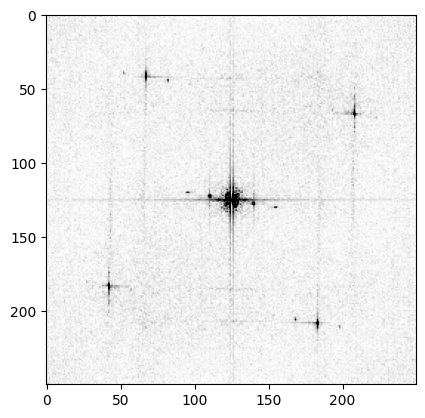

In [12]:
to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

The coordinates of the Bragg peaks are:
array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

The coordinates of the Q vectors are:
array([[ 84, -57],
       [-82,  59],
       [-57, -82],
       [ 59,  84]])


array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

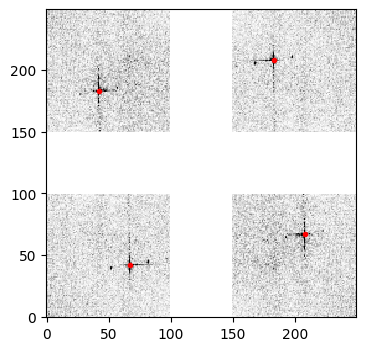

In [13]:
# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

The coordinates of the Bragg peaks are:
array([[208,  67],
       [ 42, 183],
       [ 67,  42],
       [183, 208]])

The coordinates of the Q vectors are:
array([[ 84, -57],
       [-82,  59],
       [-57, -82],
       [ 59,  84]])


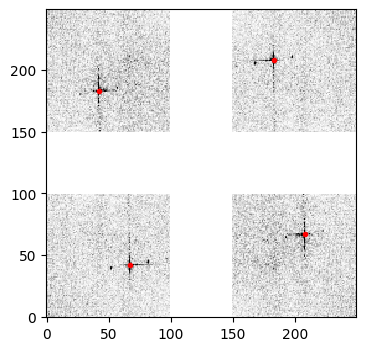

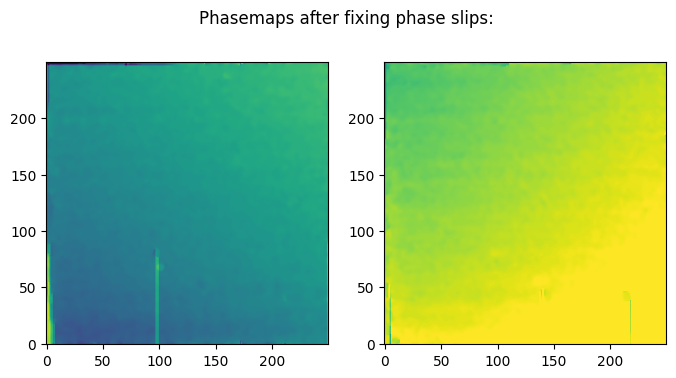

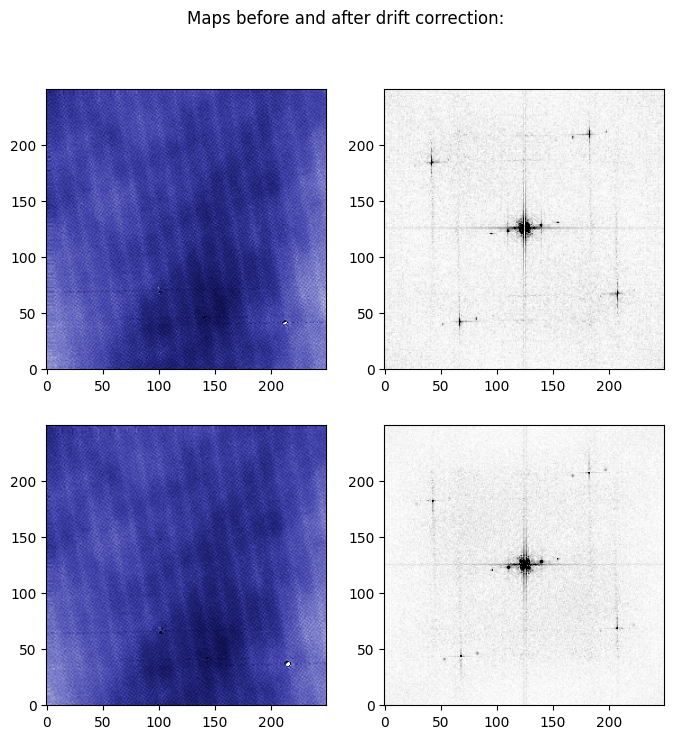

In [14]:
# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')

## 65 nm

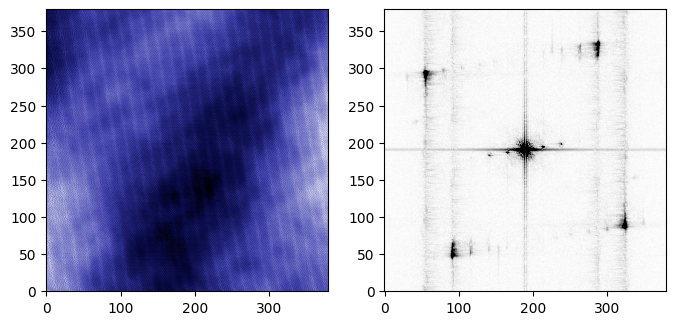

In [15]:
t = stmpy.load("2022-09-05_BSCCO_SparseSamplingTopo002.sxm", biasOffset=False)
t.z = stmpy.tools.lineSubtract(t.Z, 1)
dfc.display(t.z)

# part 1
## (drift correct then reconstruction)

The coordinates of the Bragg peaks are:
array([[325,  86],
       [ 55, 294],
       [ 92,  47],
       [288, 333]])

The coordinates of the Q vectors are:
array([[ 136, -103],
       [-134,  105],
       [ -97, -142],
       [  99,  144]])
The coordinates of the Bragg peaks are:
array([[325,  86],
       [ 55, 294],
       [ 92,  47],
       [288, 333]])

The coordinates of the Q vectors are:
array([[ 136, -103],
       [-134,  105],
       [ -97, -142],
       [  99,  144]])
Iteration 1:
  fx = 1005253719.441920, xnorm = 379.999805, gnorm = 63411.188564, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 188645243.384442, xnorm = 25810.191625, gnorm = 27436.648898, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 1039963.500698, xnorm = 35587.804791, gnorm = 1519.707560, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 462611.394622, xnorm = 35468.205524, gnorm = 42.342418, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 462077.062169, xnorm = 35467.495443, gnorm = 18.6182

Iteration 80:
  fx = 387758.481557, xnorm = 35302.222724, gnorm = 67.456554, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 386396.312636, xnorm = 35282.643979, gnorm = 37.990636, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 386105.660857, xnorm = 35306.255450, gnorm = 67.453212, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 384741.166704, xnorm = 35286.688678, gnorm = 37.819080, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 384456.421266, xnorm = 35310.546063, gnorm = 67.403080, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 383092.099118, xnorm = 35291.103549, gnorm = 37.484489, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 382813.443524, xnorm = 35315.084198, gnorm = 67.222318, step = 0.500000, k = 86, ls = 2

Iteration 87:
  fx = 381455.186968, xnorm = 35295.793930, gnorm = 37.258658, step = 0.500000, k = 87, ls = 2

Iteration 88:
  fx = 381173.902615, xnorm = 35319.833065, gnorm = 66.869274, step = 0.500000, k = 88, ls = 2

Iteration 

Iteration 160:
  fx = 328170.465708, xnorm = 35672.049280, gnorm = 60.995243, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 327051.071521, xnorm = 35656.262678, gnorm = 33.428993, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 326832.686113, xnorm = 35686.209994, gnorm = 60.839173, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 325719.343810, xnorm = 35670.500002, gnorm = 33.317968, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 325496.801311, xnorm = 35700.472853, gnorm = 60.525394, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 324398.115852, xnorm = 35684.856865, gnorm = 33.489617, step = 0.500000, k = 165, ls = 2

Iteration 166:
  fx = 324172.554856, xnorm = 35715.099005, gnorm = 60.417015, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 323078.822417, xnorm = 35699.527811, gnorm = 33.499950, step = 0.500000, k = 167, ls = 2

Iteration 168:
  fx = 322854.646576, xnorm = 35729.946109, gnorm = 60.304716, step = 0.500000, k = 168, 

Iteration 240:
  fx = 279373.454317, xnorm = 36379.816102, gnorm = 55.496974, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 278448.608808, xnorm = 36367.422737, gnorm = 30.546100, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 278266.401787, xnorm = 36400.784305, gnorm = 55.430169, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 277340.976815, xnorm = 36388.457166, gnorm = 30.210199, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 277165.065101, xnorm = 36421.787923, gnorm = 55.325632, step = 0.500000, k = 244, ls = 2

Iteration 245:
  fx = 276241.736123, xnorm = 36409.609832, gnorm = 29.833721, step = 0.500000, k = 245, ls = 2

Iteration 246:
  fx = 276065.586173, xnorm = 36442.778333, gnorm = 54.972332, step = 0.500000, k = 246, ls = 2

Iteration 247:
  fx = 275156.527529, xnorm = 36430.675995, gnorm = 30.047740, step = 0.500000, k = 247, ls = 2

Iteration 248:
  fx = 274972.251106, xnorm = 36463.899701, gnorm = 54.674163, step = 0.500000, k = 248, 

Iteration 318:
  fx = 239989.336006, xnorm = 37269.045287, gnorm = 50.334594, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 239219.753998, xnorm = 37259.561670, gnorm = 27.270114, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 239072.984682, xnorm = 37293.351192, gnorm = 50.042591, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 238314.992772, xnorm = 37283.920784, gnorm = 27.543233, step = 0.500000, k = 321, ls = 2

Iteration 322:
  fx = 238159.598254, xnorm = 37317.802303, gnorm = 49.783654, step = 0.500000, k = 322, ls = 2

Iteration 323:
  fx = 237411.064404, xnorm = 37308.413155, gnorm = 27.763175, step = 0.500000, k = 323, ls = 2

Iteration 324:
  fx = 237260.183473, xnorm = 37342.514504, gnorm = 49.988473, step = 0.500000, k = 324, ls = 2

Iteration 325:
  fx = 236501.253704, xnorm = 37333.187759, gnorm = 27.350661, step = 0.500000, k = 325, ls = 2

Iteration 326:
  fx = 236362.209330, xnorm = 37367.231332, gnorm = 50.102789, step = 0.500000, k = 326, 

Iteration 398:
  fx = 206618.706059, xnorm = 38286.272775, gnorm = 45.176075, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 206002.619168, xnorm = 38279.226938, gnorm = 25.437921, step = 0.500000, k = 399, ls = 2

Iteration 400:
  fx = 205875.666160, xnorm = 38312.619860, gnorm = 45.422736, step = 0.500000, k = 400, ls = 2

Iteration 401:
  fx = 205245.840984, xnorm = 38305.632308, gnorm = 24.695344, step = 0.500000, k = 401, ls = 2

Iteration 402:
  fx = 205133.861844, xnorm = 38338.768140, gnorm = 45.494729, step = 0.500000, k = 402, ls = 2

Iteration 403:
  fx = 204498.442929, xnorm = 38331.907251, gnorm = 24.056877, step = 0.500000, k = 403, ls = 2

Iteration 404:
  fx = 204387.142233, xnorm = 38364.663344, gnorm = 45.113723, step = 0.500000, k = 404, ls = 2

Iteration 405:
  fx = 203766.128773, xnorm = 38357.891506, gnorm = 24.257970, step = 0.500000, k = 405, ls = 2

Iteration 406:
  fx = 203643.078986, xnorm = 38390.577686, gnorm = 44.656132, step = 0.500000, k = 406, 

Iteration 474:
  fx = 180840.347097, xnorm = 39275.823706, gnorm = 40.432599, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 180341.173512, xnorm = 39270.836749, gnorm = 22.544341, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 180237.690989, xnorm = 39301.596584, gnorm = 40.350452, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 179740.756039, xnorm = 39296.636623, gnorm = 22.540154, step = 0.500000, k = 477, ls = 2

Iteration 478:
  fx = 179640.050844, xnorm = 39327.399302, gnorm = 40.321351, step = 0.500000, k = 478, ls = 2

Iteration 479:
  fx = 179141.766822, xnorm = 39322.493481, gnorm = 22.191979, step = 0.500000, k = 479, ls = 2

Iteration 480:
  fx = 179046.043348, xnorm = 39353.040148, gnorm = 40.247528, step = 0.500000, k = 480, ls = 2

Iteration 481:
  fx = 178548.095904, xnorm = 39348.225006, gnorm = 21.881721, step = 0.500000, k = 481, ls = 2

Iteration 482:
  fx = 178451.751595, xnorm = 39378.536174, gnorm = 39.958448, step = 0.500000, k = 482, 

Iteration 551:
  fx = 159983.929655, xnorm = 40225.516697, gnorm = 20.154813, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 159897.974448, xnorm = 40253.153965, gnorm = 35.392266, step = 0.500000, k = 552, ls = 2

Iteration 553:
  fx = 159512.751302, xnorm = 40249.764690, gnorm = 19.999278, step = 0.500000, k = 553, ls = 2

Iteration 554:
  fx = 159430.663611, xnorm = 40277.259085, gnorm = 35.295567, step = 0.500000, k = 554, ls = 2

Iteration 555:
  fx = 159045.619817, xnorm = 40273.905442, gnorm = 19.718265, step = 0.500000, k = 555, ls = 2

Iteration 556:
  fx = 158967.740421, xnorm = 40301.244067, gnorm = 35.217602, step = 0.500000, k = 556, ls = 2

Iteration 557:
  fx = 158583.657510, xnorm = 40297.931636, gnorm = 19.477537, step = 0.500000, k = 557, ls = 2

Iteration 558:
  fx = 158504.593725, xnorm = 40325.028681, gnorm = 34.907736, step = 0.500000, k = 558, ls = 2

Iteration 559:
  fx = 158128.930677, xnorm = 40321.766146, gnorm = 19.632922, step = 0.500000, k = 559, 

Iteration 629:
  fx = 144209.193935, xnorm = 41111.645361, gnorm = 17.504098, step = 0.500000, k = 629, ls = 2

Iteration 630:
  fx = 144140.547359, xnorm = 41135.048102, gnorm = 29.853213, step = 0.500000, k = 630, ls = 2

Iteration 631:
  fx = 143864.828317, xnorm = 41132.867431, gnorm = 17.452173, step = 0.500000, k = 631, ls = 2

Iteration 632:
  fx = 143797.758774, xnorm = 41156.142691, gnorm = 29.732231, step = 0.500000, k = 632, ls = 2

Iteration 633:
  fx = 143522.324452, xnorm = 41153.997223, gnorm = 17.120958, step = 0.500000, k = 633, ls = 2

Iteration 634:
  fx = 143459.514283, xnorm = 41177.082891, gnorm = 29.644861, step = 0.500000, k = 634, ls = 2

Iteration 635:
  fx = 143185.223655, xnorm = 41174.956659, gnorm = 16.969733, step = 0.500000, k = 635, ls = 2

Iteration 636:
  fx = 143122.011092, xnorm = 41197.881351, gnorm = 29.472180, step = 0.500000, k = 636, ls = 2

Iteration 637:
  fx = 142852.327696, xnorm = 41195.769255, gnorm = 17.116756, step = 0.500000, k = 637, 

Iteration 704:
  fx = 133307.133427, xnorm = 41852.642158, gnorm = 24.467448, step = 0.500000, k = 704, ls = 2

Iteration 705:
  fx = 133121.079975, xnorm = 41851.305922, gnorm = 15.076878, step = 0.500000, k = 705, ls = 2

Iteration 706:
  fx = 133065.270025, xnorm = 41870.240707, gnorm = 24.315461, step = 0.500000, k = 706, ls = 2

Iteration 707:
  fx = 132880.978780, xnorm = 41868.907042, gnorm = 14.973841, step = 0.500000, k = 707, ls = 2

Iteration 708:
  fx = 132826.704377, xnorm = 41887.751695, gnorm = 24.227611, step = 0.500000, k = 708, ls = 2

Iteration 709:
  fx = 132643.477293, xnorm = 41886.434253, gnorm = 14.875547, step = 0.500000, k = 709, ls = 2

Iteration 710:
  fx = 132590.617145, xnorm = 41905.140224, gnorm = 24.109166, step = 0.500000, k = 710, ls = 2

Iteration 711:
  fx = 132408.303494, xnorm = 41903.847410, gnorm = 14.670708, step = 0.500000, k = 711, ls = 2

Iteration 712:
  fx = 132356.827901, xnorm = 41922.348769, gnorm = 23.926970, step = 0.500000, k = 712, 

Iteration 779:
  fx = 125783.046689, xnorm = 42432.990867, gnorm = 12.687244, step = 0.500000, k = 779, ls = 2

Iteration 780:
  fx = 125741.012809, xnorm = 42447.552026, gnorm = 19.264308, step = 0.500000, k = 780, ls = 2

Iteration 781:
  fx = 125623.726340, xnorm = 42446.766703, gnorm = 12.606708, step = 0.500000, k = 781, ls = 2

Iteration 782:
  fx = 125582.220627, xnorm = 42461.233083, gnorm = 19.177531, step = 0.500000, k = 782, ls = 2

Iteration 783:
  fx = 125466.312865, xnorm = 42460.453046, gnorm = 12.562543, step = 0.500000, k = 783, ls = 2

Iteration 784:
  fx = 125424.649614, xnorm = 42474.787379, gnorm = 18.984468, step = 0.500000, k = 784, ls = 2

Iteration 785:
  fx = 125311.044218, xnorm = 42474.021449, gnorm = 12.534175, step = 0.500000, k = 785, ls = 2

Iteration 786:
  fx = 125268.931887, xnorm = 42488.259434, gnorm = 18.820667, step = 0.500000, k = 786, ls = 2

Iteration 787:
  fx = 125157.167190, xnorm = 42487.509532, gnorm = 12.504883, step = 0.500000, k = 787, 

Iteration 854:
  fx = 120937.064764, xnorm = 42893.435069, gnorm = 15.017482, step = 0.500000, k = 854, ls = 2

Iteration 855:
  fx = 120865.304716, xnorm = 42893.019335, gnorm = 10.572668, step = 0.500000, k = 855, ls = 2

Iteration 856:
  fx = 120834.039614, xnorm = 42903.846245, gnorm = 14.927848, step = 0.500000, k = 856, ls = 2

Iteration 857:
  fx = 120763.152768, xnorm = 42903.437259, gnorm = 10.545037, step = 0.500000, k = 857, ls = 2

Iteration 858:
  fx = 120732.204286, xnorm = 42914.207031, gnorm = 14.857604, step = 0.500000, k = 858, ls = 2

Iteration 859:
  fx = 120661.848669, xnorm = 42913.809838, gnorm = 10.500297, step = 0.500000, k = 859, ls = 2

Iteration 860:
  fx = 120631.021808, xnorm = 42924.489659, gnorm = 14.750082, step = 0.500000, k = 860, ls = 2

Iteration 861:
  fx = 120561.481094, xnorm = 42924.102587, gnorm = 10.420820, step = 0.500000, k = 861, ls = 2

Iteration 862:
  fx = 120531.156735, xnorm = 42934.677027, gnorm = 14.654377, step = 0.500000, k = 862, 

Iteration 929:
  fx = 117790.552422, xnorm = 43227.774481, gnorm = 8.820298, step = 0.500000, k = 929, ls = 2

Iteration 930:
  fx = 117767.379615, xnorm = 43235.770875, gnorm = 11.536104, step = 0.500000, k = 930, ls = 2

Iteration 931:
  fx = 117724.662504, xnorm = 43235.552975, gnorm = 8.763195, step = 0.500000, k = 931, ls = 2

Iteration 932:
  fx = 117701.895586, xnorm = 43243.481196, gnorm = 11.476479, step = 0.500000, k = 932, ls = 2

Iteration 933:
  fx = 117659.739098, xnorm = 43243.271255, gnorm = 8.716814, step = 0.500000, k = 933, ls = 2

Iteration 934:
  fx = 117636.704014, xnorm = 43251.129425, gnorm = 11.336267, step = 0.500000, k = 934, ls = 2

Iteration 935:
  fx = 117595.747348, xnorm = 43250.920100, gnorm = 8.731930, step = 0.500000, k = 935, ls = 2

Iteration 936:
  fx = 117572.647176, xnorm = 43258.746096, gnorm = 11.276210, step = 0.500000, k = 936, ls = 2

Iteration 937:
  fx = 117532.256671, xnorm = 43258.542839, gnorm = 8.726453, step = 0.500000, k = 937, ls = 

Iteration 1004:
  fx = 115795.322872, xnorm = 43485.337716, gnorm = 8.910286, step = 0.500000, k = 1004, ls = 2

Iteration 1005:
  fx = 115769.896886, xnorm = 43485.223996, gnorm = 7.357479, step = 0.500000, k = 1005, ls = 2

Iteration 1006:
  fx = 115753.202381, xnorm = 43491.137233, gnorm = 8.860620, step = 0.500000, k = 1006, ls = 2

Iteration 1007:
  fx = 115727.966093, xnorm = 43491.025367, gnorm = 7.298004, step = 0.500000, k = 1007, ls = 2

Iteration 1008:
  fx = 115711.410239, xnorm = 43496.875511, gnorm = 8.783454, step = 0.500000, k = 1008, ls = 2

Iteration 1009:
  fx = 115686.532766, xnorm = 43496.767889, gnorm = 7.248032, step = 0.500000, k = 1009, ls = 2

Iteration 1010:
  fx = 115670.273166, xnorm = 43502.574184, gnorm = 8.749431, step = 0.500000, k = 1010, ls = 2

Iteration 1011:
  fx = 115645.626375, xnorm = 43502.473736, gnorm = 7.256808, step = 0.500000, k = 1011, ls = 2

Iteration 1012:
  fx = 115629.404342, xnorm = 43508.258095, gnorm = 8.727037, step = 0.500000, k

Iteration 1079:
  fx = 114491.137653, xnorm = 43673.961118, gnorm = 6.122769, step = 0.500000, k = 1079, ls = 2

Iteration 1080:
  fx = 114479.288882, xnorm = 43678.477395, gnorm = 7.137116, step = 0.500000, k = 1080, ls = 2

Iteration 1081:
  fx = 114462.954750, xnorm = 43678.432487, gnorm = 6.113518, step = 0.500000, k = 1081, ls = 2

Iteration 1082:
  fx = 114451.225419, xnorm = 43682.928137, gnorm = 7.095262, step = 0.500000, k = 1082, ls = 2

Iteration 1083:
  fx = 114434.996769, xnorm = 43682.880055, gnorm = 6.063775, step = 0.500000, k = 1083, ls = 2

Iteration 1084:
  fx = 114423.410752, xnorm = 43687.331491, gnorm = 7.045915, step = 0.500000, k = 1084, ls = 2

Iteration 1085:
  fx = 114407.325747, xnorm = 43687.287658, gnorm = 5.999060, step = 0.500000, k = 1085, ls = 2

Iteration 1086:
  fx = 114395.998462, xnorm = 43691.702973, gnorm = 7.006661, step = 0.500000, k = 1086, ls = 2

Iteration 1087:
  fx = 114380.083303, xnorm = 43691.660857, gnorm = 5.960902, step = 0.500000, k

Iteration 1154:
  fx = 113615.992890, xnorm = 43825.075646, gnorm = 5.824174, step = 0.500000, k = 1154, ls = 2

Iteration 1155:
  fx = 113605.053611, xnorm = 43825.074467, gnorm = 5.086693, step = 0.500000, k = 1155, ls = 2

Iteration 1156:
  fx = 113596.810698, xnorm = 43828.597321, gnorm = 5.785491, step = 0.500000, k = 1156, ls = 2

Iteration 1157:
  fx = 113585.978709, xnorm = 43828.593144, gnorm = 5.047870, step = 0.500000, k = 1157, ls = 2

Iteration 1158:
  fx = 113577.829148, xnorm = 43832.092965, gnorm = 5.748229, step = 0.500000, k = 1158, ls = 2

Iteration 1159:
  fx = 113567.134177, xnorm = 43832.085372, gnorm = 5.033894, step = 0.500000, k = 1159, ls = 2

Iteration 1160:
  fx = 113559.058315, xnorm = 43835.572260, gnorm = 5.729867, step = 0.500000, k = 1160, ls = 2

Iteration 1161:
  fx = 113548.428055, xnorm = 43835.561924, gnorm = 4.985886, step = 0.500000, k = 1161, ls = 2

Iteration 1162:
  fx = 113540.524650, xnorm = 43839.018568, gnorm = 5.696631, step = 0.500000, k

Iteration 1228:
  fx = 113028.063754, xnorm = 43940.404973, gnorm = 4.739603, step = 0.500000, k = 1228, ls = 2

Iteration 1229:
  fx = 113020.798175, xnorm = 43940.425107, gnorm = 4.261876, step = 0.500000, k = 1229, ls = 2

Iteration 1230:
  fx = 113014.987578, xnorm = 43943.165354, gnorm = 4.716351, step = 0.500000, k = 1230, ls = 2

Iteration 1231:
  fx = 113007.766876, xnorm = 43943.183829, gnorm = 4.236141, step = 0.500000, k = 1231, ls = 2

Iteration 1232:
  fx = 113002.060354, xnorm = 43945.914804, gnorm = 4.708444, step = 0.500000, k = 1232, ls = 2

Iteration 1233:
  fx = 112994.847483, xnorm = 43945.934034, gnorm = 4.203199, step = 0.500000, k = 1233, ls = 2

Iteration 1234:
  fx = 112989.197758, xnorm = 43948.642933, gnorm = 4.681420, step = 0.500000, k = 1234, ls = 2

Iteration 1235:
  fx = 112982.077288, xnorm = 43948.663801, gnorm = 4.189216, step = 0.500000, k = 1235, ls = 2

Iteration 1236:
  fx = 112976.453116, xnorm = 43951.354114, gnorm = 4.649518, step = 0.500000, k

Iteration 1315:
  fx = 112559.245395, xnorm = 44045.323774, gnorm = 3.446126, step = 0.500000, k = 1315, ls = 2

Iteration 1316:
  fx = 112555.473026, xnorm = 44047.418298, gnorm = 3.884359, step = 0.500000, k = 1316, ls = 2

Iteration 1317:
  fx = 112550.555920, xnorm = 44047.455982, gnorm = 3.440607, step = 0.500000, k = 1317, ls = 2

Iteration 1318:
  fx = 112546.778112, xnorm = 44049.540654, gnorm = 3.851993, step = 0.500000, k = 1318, ls = 2

Iteration 1319:
  fx = 112541.929383, xnorm = 44049.576417, gnorm = 3.417529, step = 0.500000, k = 1319, ls = 2

Iteration 1320:
  fx = 112538.179890, xnorm = 44051.650679, gnorm = 3.827243, step = 0.500000, k = 1320, ls = 2

Iteration 1321:
  fx = 112533.381152, xnorm = 44051.685405, gnorm = 3.400947, step = 0.500000, k = 1321, ls = 2

Iteration 1322:
  fx = 112529.674898, xnorm = 44053.746180, gnorm = 3.804186, step = 0.500000, k = 1322, ls = 2

Iteration 1323:
  fx = 112524.929651, xnorm = 44053.780393, gnorm = 3.390851, step = 0.500000, k

Iteration 1401:
  fx = 112249.954824, xnorm = 44126.757675, gnorm = 2.875663, step = 0.500000, k = 1401, ls = 2

Iteration 1402:
  fx = 112247.292100, xnorm = 44128.391755, gnorm = 3.156201, step = 0.500000, k = 1402, ls = 2

Iteration 1403:
  fx = 112244.032665, xnorm = 44128.436954, gnorm = 2.863559, step = 0.500000, k = 1403, ls = 2

Iteration 1404:
  fx = 112241.393843, xnorm = 44130.059962, gnorm = 3.139937, step = 0.500000, k = 1404, ls = 2

Iteration 1405:
  fx = 112238.163070, xnorm = 44130.101933, gnorm = 2.847291, step = 0.500000, k = 1405, ls = 2

Iteration 1406:
  fx = 112235.550112, xnorm = 44131.716690, gnorm = 3.126873, step = 0.500000, k = 1406, ls = 2

Iteration 1407:
  fx = 112232.349830, xnorm = 44131.756390, gnorm = 2.843904, step = 0.500000, k = 1407, ls = 2

Iteration 1408:
  fx = 112229.744036, xnorm = 44133.366535, gnorm = 3.119226, step = 0.500000, k = 1408, ls = 2

Iteration 1409:
  fx = 112226.564223, xnorm = 44133.403667, gnorm = 2.830020, step = 0.500000, k

Iteration 1475:
  fx = 112061.034424, xnorm = 44182.994886, gnorm = 2.453808, step = 0.500000, k = 1475, ls = 2

Iteration 1476:
  fx = 112059.112554, xnorm = 44184.338297, gnorm = 2.727858, step = 0.500000, k = 1476, ls = 2

Iteration 1477:
  fx = 112056.649216, xnorm = 44184.377747, gnorm = 2.438904, step = 0.500000, k = 1477, ls = 2

Iteration 1478:
  fx = 112054.743770, xnorm = 44185.714315, gnorm = 2.715929, step = 0.500000, k = 1478, ls = 2

Iteration 1479:
  fx = 112052.308767, xnorm = 44185.752591, gnorm = 2.430936, step = 0.500000, k = 1479, ls = 2

Iteration 1480:
  fx = 112050.415308, xnorm = 44187.081317, gnorm = 2.698252, step = 0.500000, k = 1480, ls = 2

Iteration 1481:
  fx = 112048.004731, xnorm = 44187.118541, gnorm = 2.416691, step = 0.500000, k = 1481, ls = 2

Iteration 1482:
  fx = 112046.129576, xnorm = 44188.438514, gnorm = 2.683368, step = 0.500000, k = 1482, ls = 2

Iteration 1483:
  fx = 112043.750972, xnorm = 44188.476325, gnorm = 2.407367, step = 0.500000, k

Iteration 1548:
  fx = 111921.553324, xnorm = 44229.497276, gnorm = 2.364536, step = 0.500000, k = 1548, ls = 2

Iteration 1549:
  fx = 111919.707887, xnorm = 44229.529072, gnorm = 2.136505, step = 0.500000, k = 1549, ls = 2

Iteration 1550:
  fx = 111918.237803, xnorm = 44230.628820, gnorm = 2.349348, step = 0.500000, k = 1550, ls = 2

Iteration 1551:
  fx = 111916.408689, xnorm = 44230.659581, gnorm = 2.123213, step = 0.500000, k = 1551, ls = 2

Iteration 1552:
  fx = 111914.954240, xnorm = 44231.754348, gnorm = 2.339554, step = 0.500000, k = 1552, ls = 2

Iteration 1553:
  fx = 111913.141189, xnorm = 44231.784356, gnorm = 2.114561, step = 0.500000, k = 1553, ls = 2

Iteration 1554:
  fx = 111911.707644, xnorm = 44232.872358, gnorm = 2.332731, step = 0.500000, k = 1554, ls = 2

Iteration 1555:
  fx = 111909.906522, xnorm = 44232.902639, gnorm = 2.103430, step = 0.500000, k = 1555, ls = 2

Iteration 1556:
  fx = 111908.483546, xnorm = 44233.983716, gnorm = 2.324978, step = 0.500000, k

Iteration 1621:
  fx = 111815.176640, xnorm = 44267.138712, gnorm = 1.841301, step = 0.500000, k = 1621, ls = 2

Iteration 1622:
  fx = 111814.101435, xnorm = 44268.064186, gnorm = 2.091536, step = 0.500000, k = 1622, ls = 2

Iteration 1623:
  fx = 111812.635401, xnorm = 44268.093518, gnorm = 1.828657, step = 0.500000, k = 1623, ls = 2

Iteration 1624:
  fx = 111811.575849, xnorm = 44269.014677, gnorm = 2.087282, step = 0.500000, k = 1624, ls = 2

Iteration 1625:
  fx = 111810.116523, xnorm = 44269.044464, gnorm = 1.824394, step = 0.500000, k = 1625, ls = 2

Iteration 1626:
  fx = 111809.065173, xnorm = 44269.962040, gnorm = 2.084225, step = 0.500000, k = 1626, ls = 2

Iteration 1627:
  fx = 111807.609078, xnorm = 44269.992610, gnorm = 1.816285, step = 0.500000, k = 1627, ls = 2

Iteration 1628:
  fx = 111806.569524, xnorm = 44270.903519, gnorm = 2.079384, step = 0.500000, k = 1628, ls = 2

Iteration 1629:
  fx = 111805.122775, xnorm = 44270.935001, gnorm = 1.809109, step = 0.500000, k

Iteration 1696:
  fx = 111730.605434, xnorm = 44300.547267, gnorm = 1.883236, step = 0.500000, k = 1696, ls = 2

Iteration 1697:
  fx = 111729.412243, xnorm = 44300.575525, gnorm = 1.596983, step = 0.500000, k = 1697, ls = 2

Iteration 1698:
  fx = 111728.609227, xnorm = 44301.355448, gnorm = 1.875498, step = 0.500000, k = 1698, ls = 2

Iteration 1699:
  fx = 111727.423402, xnorm = 44301.384541, gnorm = 1.588539, step = 0.500000, k = 1699, ls = 2

Iteration 1700:
  fx = 111726.625373, xnorm = 44302.159712, gnorm = 1.869261, step = 0.500000, k = 1700, ls = 2

Iteration 1701:
  fx = 111725.450390, xnorm = 44302.188609, gnorm = 1.587408, step = 0.500000, k = 1701, ls = 2

Iteration 1702:
  fx = 111724.658927, xnorm = 44302.960566, gnorm = 1.866530, step = 0.500000, k = 1702, ls = 2

Iteration 1703:
  fx = 111723.492274, xnorm = 44302.989078, gnorm = 1.588256, step = 0.500000, k = 1703, ls = 2

Iteration 1704:
  fx = 111722.700701, xnorm = 44303.758806, gnorm = 1.863289, step = 0.500000, k

Iteration 1771:
  fx = 111663.090214, xnorm = 44328.567320, gnorm = 1.409885, step = 0.500000, k = 1771, ls = 2

Iteration 1772:
  fx = 111662.477354, xnorm = 44329.242767, gnorm = 1.715154, step = 0.500000, k = 1772, ls = 2

Iteration 1773:
  fx = 111661.489024, xnorm = 44329.270779, gnorm = 1.399505, step = 0.500000, k = 1773, ls = 2

Iteration 1774:
  fx = 111660.884578, xnorm = 44329.942513, gnorm = 1.709786, step = 0.500000, k = 1774, ls = 2

Iteration 1775:
  fx = 111659.898842, xnorm = 44329.971002, gnorm = 1.388314, step = 0.500000, k = 1775, ls = 2

Iteration 1776:
  fx = 111659.302369, xnorm = 44330.636782, gnorm = 1.699584, step = 0.500000, k = 1776, ls = 2

Iteration 1777:
  fx = 111658.330215, xnorm = 44330.665633, gnorm = 1.384837, step = 0.500000, k = 1777, ls = 2

Iteration 1778:
  fx = 111657.738068, xnorm = 44331.327748, gnorm = 1.689156, step = 0.500000, k = 1778, ls = 2

Iteration 1779:
  fx = 111656.777104, xnorm = 44331.356330, gnorm = 1.382878, step = 0.500000, k

Iteration 1846:
  fx = 111610.396158, xnorm = 44353.037769, gnorm = 1.504962, step = 0.500000, k = 1846, ls = 2

Iteration 1847:
  fx = 111609.633180, xnorm = 44353.058437, gnorm = 1.232365, step = 0.500000, k = 1847, ls = 2

Iteration 1848:
  fx = 111609.164831, xnorm = 44353.627215, gnorm = 1.502199, step = 0.500000, k = 1848, ls = 2

Iteration 1849:
  fx = 111608.405190, xnorm = 44353.647846, gnorm = 1.227170, step = 0.500000, k = 1849, ls = 2

Iteration 1850:
  fx = 111607.939631, xnorm = 44354.214590, gnorm = 1.494655, step = 0.500000, k = 1850, ls = 2

Iteration 1851:
  fx = 111607.187005, xnorm = 44354.234310, gnorm = 1.218939, step = 0.500000, k = 1851, ls = 2

Iteration 1852:
  fx = 111606.726123, xnorm = 44354.797266, gnorm = 1.490147, step = 0.500000, k = 1852, ls = 2

Iteration 1853:
  fx = 111605.979425, xnorm = 44354.817656, gnorm = 1.214730, step = 0.500000, k = 1853, ls = 2

Iteration 1854:
  fx = 111605.522296, xnorm = 44355.377868, gnorm = 1.484913, step = 0.500000, k

Iteration 1921:
  fx = 111569.072159, xnorm = 44373.281755, gnorm = 1.070212, step = 0.500000, k = 1921, ls = 2

Iteration 1922:
  fx = 111568.726013, xnorm = 44373.762357, gnorm = 1.351419, step = 0.500000, k = 1922, ls = 2

Iteration 1923:
  fx = 111568.105208, xnorm = 44373.784323, gnorm = 1.070255, step = 0.500000, k = 1923, ls = 2

Iteration 1924:
  fx = 111567.758304, xnorm = 44374.263999, gnorm = 1.349493, step = 0.500000, k = 1924, ls = 2

Iteration 1925:
  fx = 111567.139153, xnorm = 44374.285395, gnorm = 1.072066, step = 0.500000, k = 1925, ls = 2

Iteration 1926:
  fx = 111566.791930, xnorm = 44374.764632, gnorm = 1.348218, step = 0.500000, k = 1926, ls = 2

Iteration 1927:
  fx = 111566.175032, xnorm = 44374.786165, gnorm = 1.067540, step = 0.500000, k = 1927, ls = 2

Iteration 1928:
  fx = 111565.830367, xnorm = 44375.264194, gnorm = 1.344523, step = 0.500000, k = 1928, ls = 2

Iteration 1929:
  fx = 111565.216211, xnorm = 44375.285363, gnorm = 1.062761, step = 0.500000, k

Iteration 1996:
  fx = 111536.209164, xnorm = 44391.192105, gnorm = 1.239428, step = 0.500000, k = 1996, ls = 2

Iteration 1997:
  fx = 111535.686588, xnorm = 44391.210726, gnorm = 0.951021, step = 0.500000, k = 1997, ls = 2

Iteration 1998:
  fx = 111535.418066, xnorm = 44391.634239, gnorm = 1.238996, step = 0.500000, k = 1998, ls = 2

Iteration 1999:
  fx = 111534.895264, xnorm = 44391.652638, gnorm = 0.947575, step = 0.500000, k = 1999, ls = 2

Iteration 2000:
  fx = 111534.629011, xnorm = 44392.075627, gnorm = 1.238225, step = 0.500000, k = 2000, ls = 2

Iteration 2001:
  fx = 111534.106694, xnorm = 44392.094501, gnorm = 0.941909, step = 0.500000, k = 2001, ls = 2

Iteration 2002:
  fx = 111533.845454, xnorm = 44392.514854, gnorm = 1.236422, step = 0.500000, k = 2002, ls = 2

Iteration 2003:
  fx = 111533.323690, xnorm = 44392.533503, gnorm = 0.935850, step = 0.500000, k = 2003, ls = 2

Iteration 2004:
  fx = 111533.066153, xnorm = 44392.951682, gnorm = 1.233429, step = 0.500000, k

Iteration 2070:
  fx = 111509.600912, xnorm = 44406.463140, gnorm = 1.145869, step = 0.500000, k = 2070, ls = 2

Iteration 2071:
  fx = 111509.152033, xnorm = 44406.480507, gnorm = 0.842985, step = 0.500000, k = 2071, ls = 2

Iteration 2072:
  fx = 111508.950941, xnorm = 44406.850847, gnorm = 1.146199, step = 0.500000, k = 2072, ls = 2

Iteration 2073:
  fx = 111508.500189, xnorm = 44406.867140, gnorm = 0.833604, step = 0.500000, k = 2073, ls = 2

Iteration 2074:
  fx = 111508.304744, xnorm = 44407.235774, gnorm = 1.142465, step = 0.500000, k = 2074, ls = 2

Iteration 2075:
  fx = 111507.856762, xnorm = 44407.251699, gnorm = 0.829948, step = 0.500000, k = 2075, ls = 2

Iteration 2076:
  fx = 111507.662471, xnorm = 44407.618377, gnorm = 1.139191, step = 0.500000, k = 2076, ls = 2

Iteration 2077:
  fx = 111507.218084, xnorm = 44407.634729, gnorm = 0.827433, step = 0.500000, k = 2077, ls = 2

Iteration 2078:
  fx = 111507.023406, xnorm = 44407.999742, gnorm = 1.134861, step = 0.500000, k

Iteration 2145:
  fx = 111486.923959, xnorm = 44420.113373, gnorm = 0.748082, step = 0.500000, k = 2145, ls = 2

Iteration 2146:
  fx = 111486.771729, xnorm = 44420.451906, gnorm = 1.084598, step = 0.500000, k = 2146, ls = 2

Iteration 2147:
  fx = 111486.370653, xnorm = 44420.466303, gnorm = 0.747063, step = 0.500000, k = 2147, ls = 2

Iteration 2148:
  fx = 111486.219523, xnorm = 44420.803752, gnorm = 1.082582, step = 0.500000, k = 2148, ls = 2

Iteration 2149:
  fx = 111485.820694, xnorm = 44420.818535, gnorm = 0.747211, step = 0.500000, k = 2149, ls = 2

Iteration 2150:
  fx = 111485.669517, xnorm = 44421.154809, gnorm = 1.081772, step = 0.500000, k = 2150, ls = 2

Iteration 2151:
  fx = 111485.271216, xnorm = 44421.169744, gnorm = 0.743432, step = 0.500000, k = 2151, ls = 2

Iteration 2152:
  fx = 111485.119684, xnorm = 44421.504696, gnorm = 1.075100, step = 0.500000, k = 2152, ls = 2

Iteration 2153:
  fx = 111484.726484, xnorm = 44421.519763, gnorm = 0.743761, step = 0.500000, k

Iteration 2219:
  fx = 111468.376508, xnorm = 44432.231599, gnorm = 0.674155, step = 0.500000, k = 2219, ls = 2

Iteration 2220:
  fx = 111468.251785, xnorm = 44432.522876, gnorm = 0.981350, step = 0.500000, k = 2220, ls = 2

Iteration 2221:
  fx = 111467.924101, xnorm = 44432.537224, gnorm = 0.676146, step = 0.500000, k = 2221, ls = 2

Iteration 2222:
  fx = 111467.798181, xnorm = 44432.828849, gnorm = 0.978472, step = 0.500000, k = 2222, ls = 2

Iteration 2223:
  fx = 111467.473087, xnorm = 44432.842871, gnorm = 0.678838, step = 0.500000, k = 2223, ls = 2

Iteration 2224:
  fx = 111467.346340, xnorm = 44433.134205, gnorm = 0.974773, step = 0.500000, k = 2224, ls = 2

Iteration 2225:
  fx = 111467.023990, xnorm = 44433.147990, gnorm = 0.678246, step = 0.500000, k = 2225, ls = 2

Iteration 2226:
  fx = 111466.897449, xnorm = 44433.438793, gnorm = 0.971553, step = 0.500000, k = 2226, ls = 2

Iteration 2227:
  fx = 111466.576237, xnorm = 44433.453063, gnorm = 0.672875, step = 0.500000, k

Iteration 2303:
  fx = 111450.962421, xnorm = 44444.424389, gnorm = 0.612186, step = 0.500000, k = 2303, ls = 2

Iteration 2304:
  fx = 111450.862193, xnorm = 44444.682816, gnorm = 0.900741, step = 0.500000, k = 2304, ls = 2

Iteration 2305:
  fx = 111450.586944, xnorm = 44444.695801, gnorm = 0.611526, step = 0.500000, k = 2305, ls = 2

Iteration 2306:
  fx = 111450.486209, xnorm = 44444.953395, gnorm = 0.897911, step = 0.500000, k = 2306, ls = 2

Iteration 2307:
  fx = 111450.212656, xnorm = 44444.966146, gnorm = 0.610421, step = 0.500000, k = 2307, ls = 2

Iteration 2308:
  fx = 111450.112025, xnorm = 44445.222660, gnorm = 0.896348, step = 0.500000, k = 2308, ls = 2

Iteration 2309:
  fx = 111449.839849, xnorm = 44445.235573, gnorm = 0.611629, step = 0.500000, k = 2309, ls = 2

Iteration 2310:
  fx = 111449.739941, xnorm = 44445.491883, gnorm = 0.897080, step = 0.500000, k = 2310, ls = 2

Iteration 2311:
  fx = 111449.466338, xnorm = 44445.504734, gnorm = 0.606434, step = 0.500000, k

Iteration 2387:
  fx = 111436.608276, xnorm = 44455.100583, gnorm = 0.553462, step = 0.500000, k = 2387, ls = 2

Iteration 2388:
  fx = 111436.526992, xnorm = 44455.327841, gnorm = 0.819455, step = 0.500000, k = 2388, ls = 2

Iteration 2389:
  fx = 111436.298794, xnorm = 44455.338560, gnorm = 0.550889, step = 0.500000, k = 2389, ls = 2

Iteration 2390:
  fx = 111436.217870, xnorm = 44455.564901, gnorm = 0.817401, step = 0.500000, k = 2390, ls = 2

Iteration 2391:
  fx = 111435.990526, xnorm = 44455.576131, gnorm = 0.549150, step = 0.500000, k = 2391, ls = 2

Iteration 2392:
  fx = 111435.910356, xnorm = 44455.801521, gnorm = 0.815439, step = 0.500000, k = 2392, ls = 2

Iteration 2393:
  fx = 111435.684331, xnorm = 44455.812537, gnorm = 0.546604, step = 0.500000, k = 2393, ls = 2

Iteration 2394:
  fx = 111435.604495, xnorm = 44456.036713, gnorm = 0.811151, step = 0.500000, k = 2394, ls = 2

Iteration 2395:
  fx = 111435.380626, xnorm = 44456.047826, gnorm = 0.543975, step = 0.500000, k

Iteration 2474:
  fx = 111424.439129, xnorm = 44464.920593, gnorm = 0.756168, step = 0.500000, k = 2474, ls = 2

Iteration 2475:
  fx = 111424.245506, xnorm = 44464.931025, gnorm = 0.498012, step = 0.500000, k = 2475, ls = 2

Iteration 2476:
  fx = 111424.181566, xnorm = 44465.133606, gnorm = 0.755828, step = 0.500000, k = 2476, ls = 2

Iteration 2477:
  fx = 111423.988055, xnorm = 44465.143780, gnorm = 0.496344, step = 0.500000, k = 2477, ls = 2

Iteration 2478:
  fx = 111423.924226, xnorm = 44465.346387, gnorm = 0.753719, step = 0.500000, k = 2478, ls = 2

Iteration 2479:
  fx = 111423.731431, xnorm = 44465.356055, gnorm = 0.493321, step = 0.500000, k = 2479, ls = 2

Iteration 2480:
  fx = 111423.668025, xnorm = 44465.558154, gnorm = 0.750996, step = 0.500000, k = 2480, ls = 2

Iteration 2481:
  fx = 111423.476979, xnorm = 44465.567725, gnorm = 0.493032, step = 0.500000, k = 2481, ls = 2

Iteration 2482:
  fx = 111423.413948, xnorm = 44465.768444, gnorm = 0.749241, step = 0.500000, k

Iteration 2548:
  fx = 111415.539614, xnorm = 44472.432138, gnorm = 0.709403, step = 0.500000, k = 2548, ls = 2

Iteration 2549:
  fx = 111415.369428, xnorm = 44472.441519, gnorm = 0.456252, step = 0.500000, k = 2549, ls = 2

Iteration 2550:
  fx = 111415.317106, xnorm = 44472.626341, gnorm = 0.709723, step = 0.500000, k = 2550, ls = 2

Iteration 2551:
  fx = 111415.146518, xnorm = 44472.635723, gnorm = 0.455478, step = 0.500000, k = 2551, ls = 2

Iteration 2552:
  fx = 111415.093507, xnorm = 44472.820644, gnorm = 0.707228, step = 0.500000, k = 2552, ls = 2

Iteration 2553:
  fx = 111414.924408, xnorm = 44472.829754, gnorm = 0.456439, step = 0.500000, k = 2553, ls = 2

Iteration 2554:
  fx = 111414.871122, xnorm = 44473.013993, gnorm = 0.705522, step = 0.500000, k = 2554, ls = 2

Iteration 2555:
  fx = 111414.702899, xnorm = 44473.023600, gnorm = 0.454870, step = 0.500000, k = 2555, ls = 2

Iteration 2556:
  fx = 111414.650032, xnorm = 44473.207066, gnorm = 0.705101, step = 0.500000, k

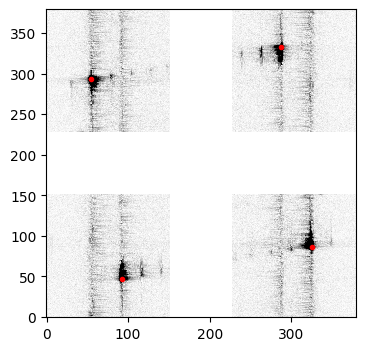

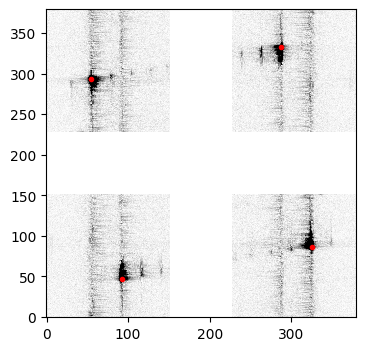

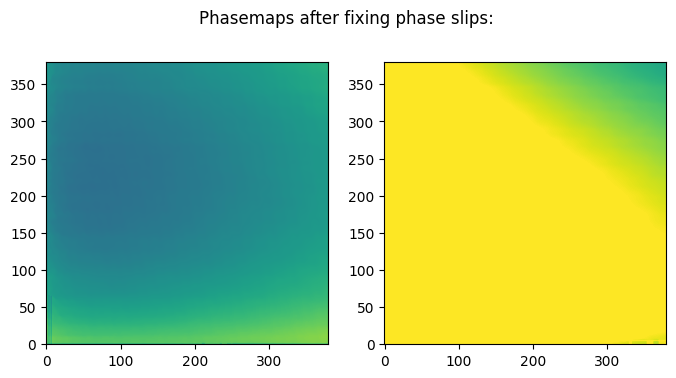

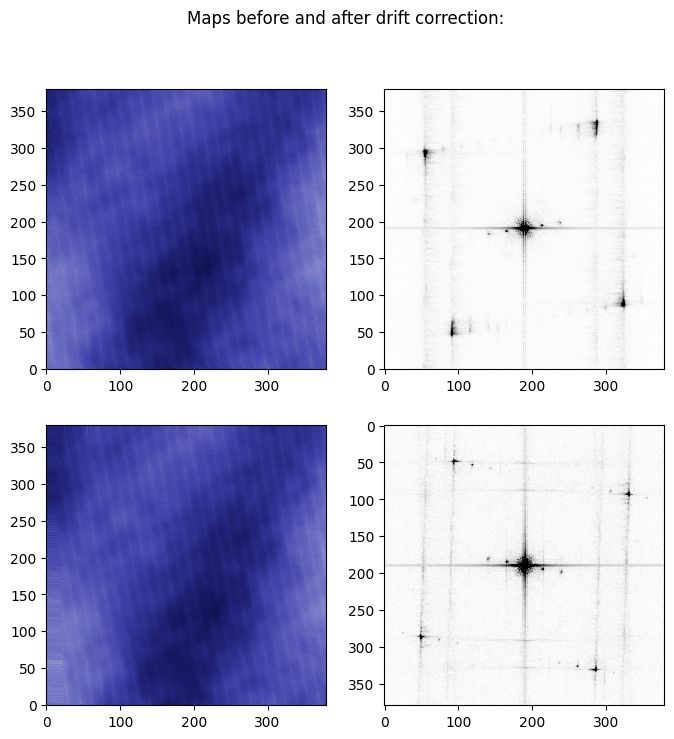

In [16]:
# Find parameters to find Bragg peaks
dfc.findBraggs(t.z, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(t.z, w=0.1, sigma=20, show=True, method='lockin')

original_mean = mean(t.z_c)
test = standardize(t.z_c)
#c2 = mean(t.z_c)
#s2 = std(t.z_c)
#imshow(t.z_c,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])
nx, ny = shape(t.z_c)

# extract small sample of signal
k = round(nx * ny * 0.50) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = test.T.flat[ri]

testsparse = zeros_like(t.z_c)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+3*s2])

# part 2
## (reconstruction then drift correction)

1.0000000659382575
Iteration 1:
  fx = 1005253719.441920, xnorm = 379.999805, gnorm = 63411.188564, step = 0.000016, k = 1, ls = 1

Iteration 2:
  fx = 188645243.384442, xnorm = 25810.191625, gnorm = 27436.648898, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 1039963.500698, xnorm = 35587.804791, gnorm = 1519.707560, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 462611.394622, xnorm = 35468.205524, gnorm = 42.342418, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 462077.062169, xnorm = 35467.495443, gnorm = 18.618289, step = 1.000000, k = 5, ls = 1

Iteration 6:
  fx = 461828.507781, xnorm = 35465.886118, gnorm = 19.593309, step = 1.000000, k = 6, ls = 1

Iteration 7:
  fx = 457690.810806, xnorm = 35430.429112, gnorm = 85.309540, step = 1.000000, k = 7, ls = 1

Iteration 8:
  fx = 456497.852573, xnorm = 35441.988562, gnorm = 106.401238, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 453401.510635, xnorm = 35408.051464, gnorm = 57.710154, step = 0.125000, k = 9, ls

Iteration 79:
  fx = 388049.633675, xnorm = 35279.126836, gnorm = 37.672141, step = 0.500000, k = 79, ls = 2

Iteration 80:
  fx = 387758.481557, xnorm = 35302.222724, gnorm = 67.456554, step = 0.500000, k = 80, ls = 2

Iteration 81:
  fx = 386396.312636, xnorm = 35282.643979, gnorm = 37.990636, step = 0.500000, k = 81, ls = 2

Iteration 82:
  fx = 386105.660857, xnorm = 35306.255450, gnorm = 67.453212, step = 0.500000, k = 82, ls = 2

Iteration 83:
  fx = 384741.166704, xnorm = 35286.688678, gnorm = 37.819080, step = 0.500000, k = 83, ls = 2

Iteration 84:
  fx = 384456.421266, xnorm = 35310.546063, gnorm = 67.403080, step = 0.500000, k = 84, ls = 2

Iteration 85:
  fx = 383092.099118, xnorm = 35291.103549, gnorm = 37.484489, step = 0.500000, k = 85, ls = 2

Iteration 86:
  fx = 382813.443524, xnorm = 35315.084198, gnorm = 67.222318, step = 0.500000, k = 86, ls = 2

Iteration 87:
  fx = 381455.186968, xnorm = 35295.793930, gnorm = 37.258658, step = 0.500000, k = 87, ls = 2

Iteration 

Iteration 159:
  fx = 328391.774868, xnorm = 35642.181302, gnorm = 33.727213, step = 0.500000, k = 159, ls = 2

Iteration 160:
  fx = 328170.465708, xnorm = 35672.049280, gnorm = 60.995243, step = 0.500000, k = 160, ls = 2

Iteration 161:
  fx = 327051.071521, xnorm = 35656.262678, gnorm = 33.428993, step = 0.500000, k = 161, ls = 2

Iteration 162:
  fx = 326832.686113, xnorm = 35686.209994, gnorm = 60.839173, step = 0.500000, k = 162, ls = 2

Iteration 163:
  fx = 325719.343810, xnorm = 35670.500002, gnorm = 33.317968, step = 0.500000, k = 163, ls = 2

Iteration 164:
  fx = 325496.801311, xnorm = 35700.472853, gnorm = 60.525394, step = 0.500000, k = 164, ls = 2

Iteration 165:
  fx = 324398.115852, xnorm = 35684.856865, gnorm = 33.489617, step = 0.500000, k = 165, ls = 2

Iteration 166:
  fx = 324172.554856, xnorm = 35715.099005, gnorm = 60.417015, step = 0.500000, k = 166, ls = 2

Iteration 167:
  fx = 323078.822417, xnorm = 35699.527811, gnorm = 33.499950, step = 0.500000, k = 167, 

Iteration 237:
  fx = 280667.111716, xnorm = 36326.070107, gnorm = 30.252025, step = 0.500000, k = 237, ls = 2

Iteration 238:
  fx = 280484.654780, xnorm = 36359.043391, gnorm = 55.571741, step = 0.500000, k = 238, ls = 2

Iteration 239:
  fx = 279557.277582, xnorm = 36346.643314, gnorm = 30.441506, step = 0.500000, k = 239, ls = 2

Iteration 240:
  fx = 279373.454317, xnorm = 36379.816102, gnorm = 55.496974, step = 0.500000, k = 240, ls = 2

Iteration 241:
  fx = 278448.608808, xnorm = 36367.422737, gnorm = 30.546100, step = 0.500000, k = 241, ls = 2

Iteration 242:
  fx = 278266.401787, xnorm = 36400.784305, gnorm = 55.430169, step = 0.500000, k = 242, ls = 2

Iteration 243:
  fx = 277340.976815, xnorm = 36388.457166, gnorm = 30.210199, step = 0.500000, k = 243, ls = 2

Iteration 244:
  fx = 277165.065101, xnorm = 36421.787923, gnorm = 55.325632, step = 0.500000, k = 244, ls = 2

Iteration 245:
  fx = 276241.736123, xnorm = 36409.609832, gnorm = 29.833721, step = 0.500000, k = 245, 

Iteration 313:
  fx = 241984.785744, xnorm = 37186.283093, gnorm = 27.881950, step = 0.500000, k = 313, ls = 2

Iteration 314:
  fx = 241829.208681, xnorm = 37220.298623, gnorm = 50.473606, step = 0.500000, k = 314, ls = 2

Iteration 315:
  fx = 241060.189075, xnorm = 37210.611065, gnorm = 27.903619, step = 0.500000, k = 315, ls = 2

Iteration 316:
  fx = 240908.227896, xnorm = 37244.720615, gnorm = 50.469035, step = 0.500000, k = 316, ls = 2

Iteration 317:
  fx = 240135.104633, xnorm = 37235.104877, gnorm = 27.488149, step = 0.500000, k = 317, ls = 2

Iteration 318:
  fx = 239989.336006, xnorm = 37269.045287, gnorm = 50.334594, step = 0.500000, k = 318, ls = 2

Iteration 319:
  fx = 239219.753998, xnorm = 37259.561670, gnorm = 27.270114, step = 0.500000, k = 319, ls = 2

Iteration 320:
  fx = 239072.984682, xnorm = 37293.351192, gnorm = 50.042591, step = 0.500000, k = 320, ls = 2

Iteration 321:
  fx = 238314.992772, xnorm = 37283.920784, gnorm = 27.543233, step = 0.500000, k = 321, 

Iteration 391:
  fx = 209028.541404, xnorm = 38174.897911, gnorm = 25.338100, step = 0.500000, k = 391, ls = 2

Iteration 392:
  fx = 208904.718741, xnorm = 38208.323730, gnorm = 45.980376, step = 0.500000, k = 392, ls = 2

Iteration 393:
  fx = 208259.918349, xnorm = 38201.132456, gnorm = 24.833546, step = 0.500000, k = 393, ls = 2

Iteration 394:
  fx = 208138.241308, xnorm = 38234.263723, gnorm = 45.700205, step = 0.500000, k = 394, ls = 2

Iteration 395:
  fx = 207501.800467, xnorm = 38227.162100, gnorm = 24.801162, step = 0.500000, k = 395, ls = 2

Iteration 396:
  fx = 207376.095165, xnorm = 38260.186255, gnorm = 45.394001, step = 0.500000, k = 396, ls = 2

Iteration 397:
  fx = 206752.672124, xnorm = 38253.124574, gnorm = 25.243031, step = 0.500000, k = 397, ls = 2

Iteration 398:
  fx = 206618.706059, xnorm = 38286.272775, gnorm = 45.176075, step = 0.500000, k = 398, ls = 2

Iteration 399:
  fx = 206002.619168, xnorm = 38279.226938, gnorm = 25.437921, step = 0.500000, k = 399, 

Iteration 469:
  fx = 182164.699633, xnorm = 39193.343489, gnorm = 22.669242, step = 0.500000, k = 469, ls = 2

Iteration 470:
  fx = 182063.616231, xnorm = 39224.370003, gnorm = 40.937647, step = 0.500000, k = 470, ls = 2

Iteration 471:
  fx = 181549.669977, xnorm = 39219.307227, gnorm = 22.346473, step = 0.500000, k = 471, ls = 2

Iteration 472:
  fx = 181451.328649, xnorm = 39250.163321, gnorm = 40.774429, step = 0.500000, k = 472, ls = 2

Iteration 473:
  fx = 180941.912194, xnorm = 39245.146387, gnorm = 22.277319, step = 0.500000, k = 473, ls = 2

Iteration 474:
  fx = 180840.347097, xnorm = 39275.823706, gnorm = 40.432599, step = 0.500000, k = 474, ls = 2

Iteration 475:
  fx = 180341.173512, xnorm = 39270.836749, gnorm = 22.544341, step = 0.500000, k = 475, ls = 2

Iteration 476:
  fx = 180237.690989, xnorm = 39301.596584, gnorm = 40.350452, step = 0.500000, k = 476, ls = 2

Iteration 477:
  fx = 179740.756039, xnorm = 39296.636623, gnorm = 22.540154, step = 0.500000, k = 477, 

Iteration 548:
  fx = 160845.443009, xnorm = 40204.750071, gnorm = 35.608129, step = 0.500000, k = 548, ls = 2

Iteration 549:
  fx = 160455.500021, xnorm = 40201.294034, gnorm = 20.082723, step = 0.500000, k = 549, ls = 2

Iteration 550:
  fx = 160368.917878, xnorm = 40228.936556, gnorm = 35.404388, step = 0.500000, k = 550, ls = 2

Iteration 551:
  fx = 159983.929655, xnorm = 40225.516697, gnorm = 20.154813, step = 0.500000, k = 551, ls = 2

Iteration 552:
  fx = 159897.974448, xnorm = 40253.153965, gnorm = 35.392266, step = 0.500000, k = 552, ls = 2

Iteration 553:
  fx = 159512.751302, xnorm = 40249.764690, gnorm = 19.999278, step = 0.500000, k = 553, ls = 2

Iteration 554:
  fx = 159430.663611, xnorm = 40277.259085, gnorm = 35.295567, step = 0.500000, k = 554, ls = 2

Iteration 555:
  fx = 159045.619817, xnorm = 40273.905442, gnorm = 19.718265, step = 0.500000, k = 555, ls = 2

Iteration 556:
  fx = 158967.740421, xnorm = 40301.244067, gnorm = 35.217602, step = 0.500000, k = 556, 

Iteration 624:
  fx = 145189.269674, xnorm = 41071.396716, gnorm = 30.386500, step = 0.500000, k = 624, ls = 2

Iteration 625:
  fx = 144902.024682, xnorm = 41069.179359, gnorm = 17.303461, step = 0.500000, k = 625, ls = 2

Iteration 626:
  fx = 144835.708202, xnorm = 41092.614903, gnorm = 30.087613, step = 0.500000, k = 626, ls = 2

Iteration 627:
  fx = 144554.951939, xnorm = 41090.410866, gnorm = 17.435662, step = 0.500000, k = 627, ls = 2

Iteration 628:
  fx = 144486.995093, xnorm = 41113.846025, gnorm = 29.954663, step = 0.500000, k = 628, ls = 2

Iteration 629:
  fx = 144209.193935, xnorm = 41111.645361, gnorm = 17.504098, step = 0.500000, k = 629, ls = 2

Iteration 630:
  fx = 144140.547359, xnorm = 41135.048102, gnorm = 29.853213, step = 0.500000, k = 630, ls = 2

Iteration 631:
  fx = 143864.828317, xnorm = 41132.867431, gnorm = 17.452173, step = 0.500000, k = 631, ls = 2

Iteration 632:
  fx = 143797.758774, xnorm = 41156.142691, gnorm = 29.732231, step = 0.500000, k = 632, 

Iteration 699:
  fx = 133855.064658, xnorm = 41797.944673, gnorm = 15.148746, step = 0.500000, k = 699, ls = 2

Iteration 700:
  fx = 133800.450765, xnorm = 41817.208592, gnorm = 24.869286, step = 0.500000, k = 700, ls = 2

Iteration 701:
  fx = 133607.444525, xnorm = 41815.838500, gnorm = 15.062958, step = 0.500000, k = 701, ls = 2

Iteration 702:
  fx = 133553.083797, xnorm = 41834.993389, gnorm = 24.716555, step = 0.500000, k = 702, ls = 2

Iteration 703:
  fx = 133362.458387, xnorm = 41833.644492, gnorm = 14.977358, step = 0.500000, k = 703, ls = 2

Iteration 704:
  fx = 133307.133427, xnorm = 41852.642158, gnorm = 24.467448, step = 0.500000, k = 704, ls = 2

Iteration 705:
  fx = 133121.079975, xnorm = 41851.305922, gnorm = 15.076878, step = 0.500000, k = 705, ls = 2

Iteration 706:
  fx = 133065.270025, xnorm = 41870.240707, gnorm = 24.315461, step = 0.500000, k = 706, ls = 2

Iteration 707:
  fx = 132880.978780, xnorm = 41868.907042, gnorm = 14.973841, step = 0.500000, k = 707, 

Iteration 774:
  fx = 126227.676683, xnorm = 42405.965902, gnorm = 19.604881, step = 0.500000, k = 774, ls = 2

Iteration 775:
  fx = 126106.546506, xnorm = 42405.153043, gnorm = 12.817844, step = 0.500000, k = 775, ls = 2

Iteration 776:
  fx = 126064.029082, xnorm = 42419.929688, gnorm = 19.511541, step = 0.500000, k = 776, ls = 2

Iteration 777:
  fx = 125943.848612, xnorm = 42419.120627, gnorm = 12.734647, step = 0.500000, k = 777, ls = 2

Iteration 778:
  fx = 125901.904546, xnorm = 42433.793505, gnorm = 19.408299, step = 0.500000, k = 778, ls = 2

Iteration 779:
  fx = 125783.046689, xnorm = 42432.990867, gnorm = 12.687244, step = 0.500000, k = 779, ls = 2

Iteration 780:
  fx = 125741.012809, xnorm = 42447.552026, gnorm = 19.264308, step = 0.500000, k = 780, ls = 2

Iteration 781:
  fx = 125623.726340, xnorm = 42446.766703, gnorm = 12.606708, step = 0.500000, k = 781, ls = 2

Iteration 782:
  fx = 125582.220627, xnorm = 42461.233083, gnorm = 19.177531, step = 0.500000, k = 782, 

Iteration 849:
  fx = 121178.212661, xnorm = 42861.301958, gnorm = 10.676921, step = 0.500000, k = 849, ls = 2

Iteration 850:
  fx = 121146.747074, xnorm = 42872.389274, gnorm = 15.245789, step = 0.500000, k = 850, ls = 2

Iteration 851:
  fx = 121072.747104, xnorm = 42871.954678, gnorm = 10.658689, step = 0.500000, k = 851, ls = 2

Iteration 852:
  fx = 121041.426437, xnorm = 42882.956285, gnorm = 15.136650, step = 0.500000, k = 852, ls = 2

Iteration 853:
  fx = 120968.346469, xnorm = 42882.531429, gnorm = 10.577304, step = 0.500000, k = 853, ls = 2

Iteration 854:
  fx = 120937.064764, xnorm = 42893.435069, gnorm = 15.017482, step = 0.500000, k = 854, ls = 2

Iteration 855:
  fx = 120865.304716, xnorm = 42893.019335, gnorm = 10.572668, step = 0.500000, k = 855, ls = 2

Iteration 856:
  fx = 120834.039614, xnorm = 42903.846245, gnorm = 14.927848, step = 0.500000, k = 856, ls = 2

Iteration 857:
  fx = 120763.152768, xnorm = 42903.437259, gnorm = 10.545037, step = 0.500000, k = 857, 

Iteration 924:
  fx = 117969.757019, xnorm = 43212.197706, gnorm = 11.787159, step = 0.500000, k = 924, ls = 2

Iteration 925:
  fx = 117925.439485, xnorm = 43211.979259, gnorm = 8.974012, step = 0.500000, k = 925, ls = 2

Iteration 926:
  fx = 117901.568468, xnorm = 43220.134752, gnorm = 11.740002, step = 0.500000, k = 926, ls = 2

Iteration 927:
  fx = 117857.409319, xnorm = 43219.916673, gnorm = 8.880709, step = 0.500000, k = 927, ls = 2

Iteration 928:
  fx = 117834.028374, xnorm = 43227.992895, gnorm = 11.643594, step = 0.500000, k = 928, ls = 2

Iteration 929:
  fx = 117790.552422, xnorm = 43227.774481, gnorm = 8.820298, step = 0.500000, k = 929, ls = 2

Iteration 930:
  fx = 117767.379615, xnorm = 43235.770875, gnorm = 11.536104, step = 0.500000, k = 930, ls = 2

Iteration 931:
  fx = 117724.662504, xnorm = 43235.552975, gnorm = 8.763195, step = 0.500000, k = 931, ls = 2

Iteration 932:
  fx = 117701.895586, xnorm = 43243.481196, gnorm = 11.476479, step = 0.500000, k = 932, ls =

Iteration 999:
  fx = 115898.003344, xnorm = 43467.592465, gnorm = 7.416140, step = 0.500000, k = 999, ls = 2

Iteration 1000:
  fx = 115880.795608, xnorm = 43473.617615, gnorm = 8.976760, step = 0.500000, k = 1000, ls = 2

Iteration 1001:
  fx = 115854.971006, xnorm = 43473.500504, gnorm = 7.422223, step = 0.500000, k = 1001, ls = 2

Iteration 1002:
  fx = 115837.798466, xnorm = 43479.491001, gnorm = 8.940295, step = 0.500000, k = 1002, ls = 2

Iteration 1003:
  fx = 115812.267251, xnorm = 43479.377929, gnorm = 7.417956, step = 0.500000, k = 1003, ls = 2

Iteration 1004:
  fx = 115795.322872, xnorm = 43485.337716, gnorm = 8.910286, step = 0.500000, k = 1004, ls = 2

Iteration 1005:
  fx = 115769.896886, xnorm = 43485.223996, gnorm = 7.357479, step = 0.500000, k = 1005, ls = 2

Iteration 1006:
  fx = 115753.202381, xnorm = 43491.137233, gnorm = 8.860620, step = 0.500000, k = 1006, ls = 2

Iteration 1007:
  fx = 115727.966093, xnorm = 43491.025367, gnorm = 7.298004, step = 0.500000, k =

Iteration 1074:
  fx = 114565.633276, xnorm = 43664.961536, gnorm = 7.262404, step = 0.500000, k = 1074, ls = 2

Iteration 1075:
  fx = 114548.624155, xnorm = 43664.910664, gnorm = 6.188920, step = 0.500000, k = 1075, ls = 2

Iteration 1076:
  fx = 114536.630020, xnorm = 43669.502443, gnorm = 7.245280, step = 0.500000, k = 1076, ls = 2

Iteration 1077:
  fx = 114519.607460, xnorm = 43669.452864, gnorm = 6.115696, step = 0.500000, k = 1077, ls = 2

Iteration 1078:
  fx = 114507.800598, xnorm = 43674.008571, gnorm = 7.197076, step = 0.500000, k = 1078, ls = 2

Iteration 1079:
  fx = 114491.137653, xnorm = 43673.961118, gnorm = 6.122769, step = 0.500000, k = 1079, ls = 2

Iteration 1080:
  fx = 114479.288882, xnorm = 43678.477395, gnorm = 7.137116, step = 0.500000, k = 1080, ls = 2

Iteration 1081:
  fx = 114462.954750, xnorm = 43678.432487, gnorm = 6.113518, step = 0.500000, k = 1081, ls = 2

Iteration 1082:
  fx = 114451.225419, xnorm = 43682.928137, gnorm = 7.095262, step = 0.500000, k

Iteration 1149:
  fx = 113663.404267, xnorm = 43814.374505, gnorm = 5.143611, step = 0.500000, k = 1149, ls = 2

Iteration 1150:
  fx = 113654.998420, xnorm = 43817.968707, gnorm = 5.891694, step = 0.500000, k = 1150, ls = 2

Iteration 1151:
  fx = 113643.733291, xnorm = 43817.962547, gnorm = 5.115334, step = 0.500000, k = 1151, ls = 2

Iteration 1152:
  fx = 113635.408355, xnorm = 43821.531599, gnorm = 5.860871, step = 0.500000, k = 1152, ls = 2

Iteration 1153:
  fx = 113624.335123, xnorm = 43821.529091, gnorm = 5.119849, step = 0.500000, k = 1153, ls = 2

Iteration 1154:
  fx = 113615.992890, xnorm = 43825.075646, gnorm = 5.824174, step = 0.500000, k = 1154, ls = 2

Iteration 1155:
  fx = 113605.053611, xnorm = 43825.074467, gnorm = 5.086693, step = 0.500000, k = 1155, ls = 2

Iteration 1156:
  fx = 113596.810698, xnorm = 43828.597321, gnorm = 5.785491, step = 0.500000, k = 1156, ls = 2

Iteration 1157:
  fx = 113585.978709, xnorm = 43828.593144, gnorm = 5.047870, step = 0.500000, k

Iteration 1224:
  fx = 113054.611009, xnorm = 43934.832331, gnorm = 4.783981, step = 0.500000, k = 1224, ls = 2

Iteration 1225:
  fx = 113047.235550, xnorm = 43934.850188, gnorm = 4.300714, step = 0.500000, k = 1225, ls = 2

Iteration 1226:
  fx = 113041.279650, xnorm = 43937.623121, gnorm = 4.761151, step = 0.500000, k = 1226, ls = 2

Iteration 1227:
  fx = 113033.948403, xnorm = 43937.646282, gnorm = 4.280608, step = 0.500000, k = 1227, ls = 2

Iteration 1228:
  fx = 113028.063754, xnorm = 43940.404973, gnorm = 4.739603, step = 0.500000, k = 1228, ls = 2

Iteration 1229:
  fx = 113020.798175, xnorm = 43940.425107, gnorm = 4.261876, step = 0.500000, k = 1229, ls = 2

Iteration 1230:
  fx = 113014.987578, xnorm = 43943.165354, gnorm = 4.716351, step = 0.500000, k = 1230, ls = 2

Iteration 1231:
  fx = 113007.766876, xnorm = 43943.183829, gnorm = 4.236141, step = 0.500000, k = 1231, ls = 2

Iteration 1232:
  fx = 113002.060354, xnorm = 43945.914804, gnorm = 4.708444, step = 0.500000, k

Iteration 1299:
  fx = 112632.027697, xnorm = 44027.764485, gnorm = 3.590797, step = 0.500000, k = 1299, ls = 2

Iteration 1300:
  fx = 112627.885215, xnorm = 44029.970165, gnorm = 4.008430, step = 0.500000, k = 1300, ls = 2

Iteration 1301:
  fx = 112622.631343, xnorm = 44030.000346, gnorm = 3.570796, step = 0.500000, k = 1301, ls = 2

Iteration 1302:
  fx = 112618.530764, xnorm = 44032.195210, gnorm = 3.988627, step = 0.500000, k = 1302, ls = 2

Iteration 1303:
  fx = 112613.340797, xnorm = 44032.225737, gnorm = 3.552682, step = 0.500000, k = 1303, ls = 2

Iteration 1304:
  fx = 112609.284099, xnorm = 44034.408454, gnorm = 3.974748, step = 0.500000, k = 1304, ls = 2

Iteration 1305:
  fx = 112604.134530, xnorm = 44034.438595, gnorm = 3.542462, step = 0.500000, k = 1305, ls = 2

Iteration 1306:
  fx = 112600.126045, xnorm = 44036.614232, gnorm = 3.974500, step = 0.500000, k = 1306, ls = 2

Iteration 1307:
  fx = 112594.971209, xnorm = 44036.646844, gnorm = 3.525280, step = 0.500000, k

Iteration 1374:
  fx = 112334.658151, xnorm = 44104.182793, gnorm = 3.360460, step = 0.500000, k = 1374, ls = 2

Iteration 1375:
  fx = 112330.946801, xnorm = 44104.218736, gnorm = 3.018258, step = 0.500000, k = 1375, ls = 2

Iteration 1376:
  fx = 112328.029411, xnorm = 44105.980387, gnorm = 3.340425, step = 0.500000, k = 1376, ls = 2

Iteration 1377:
  fx = 112324.354110, xnorm = 44106.014628, gnorm = 2.990400, step = 0.500000, k = 1377, ls = 2

Iteration 1378:
  fx = 112321.460802, xnorm = 44107.760884, gnorm = 3.312805, step = 0.500000, k = 1378, ls = 2

Iteration 1379:
  fx = 112317.843118, xnorm = 44107.794131, gnorm = 2.976875, step = 0.500000, k = 1379, ls = 2

Iteration 1380:
  fx = 112314.991929, xnorm = 44109.532244, gnorm = 3.305233, step = 0.500000, k = 1380, ls = 2

Iteration 1381:
  fx = 112311.392059, xnorm = 44109.565949, gnorm = 2.966018, step = 0.500000, k = 1381, ls = 2

Iteration 1382:
  fx = 112308.576912, xnorm = 44111.293111, gnorm = 3.293320, step = 0.500000, k

Iteration 1448:
  fx = 112123.843045, xnorm = 44164.348135, gnorm = 2.846931, step = 0.500000, k = 1448, ls = 2

Iteration 1449:
  fx = 112121.174035, xnorm = 44164.385867, gnorm = 2.582774, step = 0.500000, k = 1449, ls = 2

Iteration 1450:
  fx = 112119.009052, xnorm = 44165.812746, gnorm = 2.838040, step = 0.500000, k = 1450, ls = 2

Iteration 1451:
  fx = 112116.373861, xnorm = 44165.850022, gnorm = 2.589361, step = 0.500000, k = 1451, ls = 2

Iteration 1452:
  fx = 112114.205458, xnorm = 44167.275654, gnorm = 2.829908, step = 0.500000, k = 1452, ls = 2

Iteration 1453:
  fx = 112111.587402, xnorm = 44167.311551, gnorm = 2.586299, step = 0.500000, k = 1453, ls = 2

Iteration 1454:
  fx = 112109.435449, xnorm = 44168.734502, gnorm = 2.830793, step = 0.500000, k = 1454, ls = 2

Iteration 1455:
  fx = 112106.816790, xnorm = 44168.771174, gnorm = 2.581376, step = 0.500000, k = 1455, ls = 2

Iteration 1456:
  fx = 112104.670594, xnorm = 44170.188145, gnorm = 2.822205, step = 0.500000, k

Iteration 1521:
  fx = 111968.494796, xnorm = 44213.030651, gnorm = 2.240550, step = 0.500000, k = 1521, ls = 2

Iteration 1522:
  fx = 111966.883762, xnorm = 44214.214368, gnorm = 2.485674, step = 0.500000, k = 1522, ls = 2

Iteration 1523:
  fx = 111964.837946, xnorm = 44214.250279, gnorm = 2.227979, step = 0.500000, k = 1523, ls = 2

Iteration 1524:
  fx = 111963.244458, xnorm = 44215.426408, gnorm = 2.473109, step = 0.500000, k = 1524, ls = 2

Iteration 1525:
  fx = 111961.217604, xnorm = 44215.461687, gnorm = 2.222509, step = 0.500000, k = 1525, ls = 2

Iteration 1526:
  fx = 111959.632819, xnorm = 44216.633083, gnorm = 2.465017, step = 0.500000, k = 1526, ls = 2

Iteration 1527:
  fx = 111957.625064, xnorm = 44216.666214, gnorm = 2.214122, step = 0.500000, k = 1527, ls = 2

Iteration 1528:
  fx = 111956.046206, xnorm = 44217.833765, gnorm = 2.457163, step = 0.500000, k = 1528, ls = 2

Iteration 1529:
  fx = 111954.056813, xnorm = 44217.866330, gnorm = 2.217803, step = 0.500000, k

Iteration 1606:
  fx = 111835.076485, xnorm = 44260.268789, gnorm = 2.155655, step = 0.500000, k = 1606, ls = 2

Iteration 1607:
  fx = 111833.527534, xnorm = 44260.299003, gnorm = 1.905101, step = 0.500000, k = 1607, ls = 2

Iteration 1608:
  fx = 111832.384069, xnorm = 44261.267351, gnorm = 2.156991, step = 0.500000, k = 1608, ls = 2

Iteration 1609:
  fx = 111830.833506, xnorm = 44261.297628, gnorm = 1.892206, step = 0.500000, k = 1609, ls = 2

Iteration 1610:
  fx = 111829.701762, xnorm = 44262.257768, gnorm = 2.145104, step = 0.500000, k = 1610, ls = 2

Iteration 1611:
  fx = 111828.159731, xnorm = 44262.287935, gnorm = 1.870196, step = 0.500000, k = 1611, ls = 2

Iteration 1612:
  fx = 111827.042617, xnorm = 44263.236139, gnorm = 2.122830, step = 0.500000, k = 1612, ls = 2

Iteration 1613:
  fx = 111825.526744, xnorm = 44263.265151, gnorm = 1.857655, step = 0.500000, k = 1613, ls = 2

Iteration 1614:
  fx = 111824.422884, xnorm = 44264.207803, gnorm = 2.116253, step = 0.500000, k

Iteration 1679:
  fx = 111747.868337, xnorm = 44293.156419, gnorm = 1.644471, step = 0.500000, k = 1679, ls = 2

Iteration 1680:
  fx = 111747.003532, xnorm = 44293.959591, gnorm = 1.910663, step = 0.500000, k = 1680, ls = 2

Iteration 1681:
  fx = 111745.784041, xnorm = 44293.988963, gnorm = 1.645290, step = 0.500000, k = 1681, ls = 2

Iteration 1682:
  fx = 111744.922106, xnorm = 44294.791444, gnorm = 1.908894, step = 0.500000, k = 1682, ls = 2

Iteration 1683:
  fx = 111743.703941, xnorm = 44294.821327, gnorm = 1.645052, step = 0.500000, k = 1683, ls = 2

Iteration 1684:
  fx = 111742.844372, xnorm = 44295.622308, gnorm = 1.908966, step = 0.500000, k = 1684, ls = 2

Iteration 1685:
  fx = 111741.627817, xnorm = 44295.652469, gnorm = 1.640678, step = 0.500000, k = 1685, ls = 2

Iteration 1686:
  fx = 111740.776764, xnorm = 44296.450276, gnorm = 1.905703, step = 0.500000, k = 1686, ls = 2

Iteration 1687:
  fx = 111739.563419, xnorm = 44296.480098, gnorm = 1.635047, step = 0.500000, k

Iteration 1765:
  fx = 111667.926300, xnorm = 44326.446329, gnorm = 1.402441, step = 0.500000, k = 1765, ls = 2

Iteration 1766:
  fx = 111667.319079, xnorm = 44327.124943, gnorm = 1.730820, step = 0.500000, k = 1766, ls = 2

Iteration 1767:
  fx = 111666.307464, xnorm = 44327.153711, gnorm = 1.404374, step = 0.500000, k = 1767, ls = 2

Iteration 1768:
  fx = 111665.696613, xnorm = 44327.832144, gnorm = 1.725429, step = 0.500000, k = 1768, ls = 2

Iteration 1769:
  fx = 111664.699133, xnorm = 44327.860786, gnorm = 1.412947, step = 0.500000, k = 1769, ls = 2

Iteration 1770:
  fx = 111664.082732, xnorm = 44328.539193, gnorm = 1.720608, step = 0.500000, k = 1770, ls = 2

Iteration 1771:
  fx = 111663.090214, xnorm = 44328.567320, gnorm = 1.409885, step = 0.500000, k = 1771, ls = 2

Iteration 1772:
  fx = 111662.477354, xnorm = 44329.242767, gnorm = 1.715154, step = 0.500000, k = 1772, ls = 2

Iteration 1773:
  fx = 111661.489024, xnorm = 44329.270779, gnorm = 1.399505, step = 0.500000, k

Iteration 1849:
  fx = 111608.405190, xnorm = 44353.647846, gnorm = 1.227170, step = 0.500000, k = 1849, ls = 2

Iteration 1850:
  fx = 111607.939631, xnorm = 44354.214590, gnorm = 1.494655, step = 0.500000, k = 1850, ls = 2

Iteration 1851:
  fx = 111607.187005, xnorm = 44354.234310, gnorm = 1.218939, step = 0.500000, k = 1851, ls = 2

Iteration 1852:
  fx = 111606.726123, xnorm = 44354.797266, gnorm = 1.490147, step = 0.500000, k = 1852, ls = 2

Iteration 1853:
  fx = 111605.979425, xnorm = 44354.817656, gnorm = 1.214730, step = 0.500000, k = 1853, ls = 2

Iteration 1854:
  fx = 111605.522296, xnorm = 44355.377868, gnorm = 1.484913, step = 0.500000, k = 1854, ls = 2

Iteration 1855:
  fx = 111604.780572, xnorm = 44355.397919, gnorm = 1.213929, step = 0.500000, k = 1855, ls = 2

Iteration 1856:
  fx = 111604.324132, xnorm = 44355.956710, gnorm = 1.479771, step = 0.500000, k = 1856, ls = 2

Iteration 1857:
  fx = 111603.587502, xnorm = 44355.976696, gnorm = 1.211015, step = 0.500000, k

Iteration 1933:
  fx = 111563.317107, xnorm = 44376.277515, gnorm = 1.053393, step = 0.500000, k = 1933, ls = 2

Iteration 1934:
  fx = 111562.979654, xnorm = 44376.748615, gnorm = 1.328742, step = 0.500000, k = 1934, ls = 2

Iteration 1935:
  fx = 111562.378641, xnorm = 44376.769439, gnorm = 1.047961, step = 0.500000, k = 1935, ls = 2

Iteration 1936:
  fx = 111562.044419, xnorm = 44377.237921, gnorm = 1.325004, step = 0.500000, k = 1936, ls = 2

Iteration 1937:
  fx = 111561.449096, xnorm = 44377.258242, gnorm = 1.048791, step = 0.500000, k = 1937, ls = 2

Iteration 1938:
  fx = 111561.113565, xnorm = 44377.725886, gnorm = 1.322371, step = 0.500000, k = 1938, ls = 2

Iteration 1939:
  fx = 111560.521148, xnorm = 44377.746034, gnorm = 1.044813, step = 0.500000, k = 1939, ls = 2

Iteration 1940:
  fx = 111560.191420, xnorm = 44378.212545, gnorm = 1.323730, step = 0.500000, k = 1940, ls = 2

Iteration 1941:
  fx = 111559.595973, xnorm = 44378.232317, gnorm = 1.039391, step = 0.500000, k

Iteration 2011:
  fx = 111530.235183, xnorm = 44394.274648, gnorm = 0.924538, step = 0.500000, k = 2011, ls = 2

Iteration 2012:
  fx = 111529.985817, xnorm = 44394.688118, gnorm = 1.225011, step = 0.500000, k = 2012, ls = 2

Iteration 2013:
  fx = 111529.472445, xnorm = 44394.706598, gnorm = 0.922529, step = 0.500000, k = 2013, ls = 2

Iteration 2014:
  fx = 111529.223744, xnorm = 44395.118344, gnorm = 1.221400, step = 0.500000, k = 2014, ls = 2

Iteration 2015:
  fx = 111528.714503, xnorm = 44395.136229, gnorm = 0.922401, step = 0.500000, k = 2015, ls = 2

Iteration 2016:
  fx = 111528.465431, xnorm = 44395.547061, gnorm = 1.218877, step = 0.500000, k = 2016, ls = 2

Iteration 2017:
  fx = 111527.958750, xnorm = 44395.564673, gnorm = 0.920728, step = 0.500000, k = 2017, ls = 2

Iteration 2018:
  fx = 111527.711228, xnorm = 44395.974140, gnorm = 1.216375, step = 0.500000, k = 2018, ls = 2

Iteration 2019:
  fx = 111527.207066, xnorm = 44395.991248, gnorm = 0.917945, step = 0.500000, k

Iteration 2097:
  fx = 111500.969818, xnorm = 44411.408482, gnorm = 0.811685, step = 0.500000, k = 2097, ls = 2

Iteration 2098:
  fx = 111500.784788, xnorm = 44411.765712, gnorm = 1.122771, step = 0.500000, k = 2098, ls = 2

Iteration 2099:
  fx = 111500.354296, xnorm = 44411.781161, gnorm = 0.806633, step = 0.500000, k = 2099, ls = 2

Iteration 2100:
  fx = 111500.171042, xnorm = 44412.137204, gnorm = 1.119868, step = 0.500000, k = 2100, ls = 2

Iteration 2101:
  fx = 111499.742773, xnorm = 44412.152427, gnorm = 0.801719, step = 0.500000, k = 2101, ls = 2

Iteration 2102:
  fx = 111499.562460, xnorm = 44412.506913, gnorm = 1.118089, step = 0.500000, k = 2102, ls = 2

Iteration 2103:
  fx = 111499.134845, xnorm = 44412.522189, gnorm = 0.797173, step = 0.500000, k = 2103, ls = 2

Iteration 2104:
  fx = 111498.957410, xnorm = 44412.875198, gnorm = 1.116271, step = 0.500000, k = 2104, ls = 2

Iteration 2105:
  fx = 111498.530553, xnorm = 44412.890343, gnorm = 0.794484, step = 0.500000, k

Iteration 2170:
  fx = 111480.333520, xnorm = 44424.579576, gnorm = 1.031694, step = 0.500000, k = 2170, ls = 2

Iteration 2171:
  fx = 111479.972316, xnorm = 44424.594988, gnorm = 0.739016, step = 0.500000, k = 2171, ls = 2

Iteration 2172:
  fx = 111479.819014, xnorm = 44424.912768, gnorm = 1.029261, step = 0.500000, k = 2172, ls = 2

Iteration 2173:
  fx = 111479.459482, xnorm = 44424.928021, gnorm = 0.736372, step = 0.500000, k = 2173, ls = 2

Iteration 2174:
  fx = 111479.307673, xnorm = 44425.244175, gnorm = 1.025779, step = 0.500000, k = 2174, ls = 2

Iteration 2175:
  fx = 111478.949820, xnorm = 44425.258946, gnorm = 0.732276, step = 0.500000, k = 2175, ls = 2

Iteration 2176:
  fx = 111478.799688, xnorm = 44425.573692, gnorm = 1.023376, step = 0.500000, k = 2176, ls = 2

Iteration 2177:
  fx = 111478.443243, xnorm = 44425.588295, gnorm = 0.728651, step = 0.500000, k = 2177, ls = 2

Iteration 2178:
  fx = 111478.293189, xnorm = 44425.901213, gnorm = 1.018595, step = 0.500000, k

Iteration 2245:
  fx = 111462.639027, xnorm = 44436.157136, gnorm = 0.656140, step = 0.500000, k = 2245, ls = 2

Iteration 2246:
  fx = 111462.523853, xnorm = 44436.440096, gnorm = 0.960738, step = 0.500000, k = 2246, ls = 2

Iteration 2247:
  fx = 111462.208743, xnorm = 44436.453899, gnorm = 0.649764, step = 0.500000, k = 2247, ls = 2

Iteration 2248:
  fx = 111462.095419, xnorm = 44436.735504, gnorm = 0.957781, step = 0.500000, k = 2248, ls = 2

Iteration 2249:
  fx = 111461.782820, xnorm = 44436.748977, gnorm = 0.649144, step = 0.500000, k = 2249, ls = 2

Iteration 2250:
  fx = 111461.668348, xnorm = 44437.029840, gnorm = 0.953080, step = 0.500000, k = 2250, ls = 2

Iteration 2251:
  fx = 111461.359639, xnorm = 44437.043625, gnorm = 0.651498, step = 0.500000, k = 2251, ls = 2

Iteration 2252:
  fx = 111461.244974, xnorm = 44437.323712, gnorm = 0.950738, step = 0.500000, k = 2252, ls = 2

Iteration 2253:
  fx = 111460.937407, xnorm = 44437.337844, gnorm = 0.651033, step = 0.500000, k

Iteration 2320:
  fx = 111447.901521, xnorm = 44446.824505, gnorm = 0.890908, step = 0.500000, k = 2320, ls = 2

Iteration 2321:
  fx = 111447.631109, xnorm = 44446.835799, gnorm = 0.592358, step = 0.500000, k = 2321, ls = 2

Iteration 2322:
  fx = 111447.538773, xnorm = 44447.087659, gnorm = 0.887564, step = 0.500000, k = 2322, ls = 2

Iteration 2323:
  fx = 111447.270681, xnorm = 44447.099145, gnorm = 0.593675, step = 0.500000, k = 2323, ls = 2

Iteration 2324:
  fx = 111447.177904, xnorm = 44447.350441, gnorm = 0.884256, step = 0.500000, k = 2324, ls = 2

Iteration 2325:
  fx = 111446.911606, xnorm = 44447.361723, gnorm = 0.590447, step = 0.500000, k = 2325, ls = 2

Iteration 2326:
  fx = 111446.819847, xnorm = 44447.612188, gnorm = 0.881409, step = 0.500000, k = 2326, ls = 2

Iteration 2327:
  fx = 111446.555436, xnorm = 44447.623234, gnorm = 0.588203, step = 0.500000, k = 2327, ls = 2

Iteration 2328:
  fx = 111446.463297, xnorm = 44447.872604, gnorm = 0.876668, step = 0.500000, k

Iteration 2395:
  fx = 111435.380626, xnorm = 44456.047826, gnorm = 0.543975, step = 0.500000, k = 2395, ls = 2

Iteration 2396:
  fx = 111435.301517, xnorm = 44456.271690, gnorm = 0.807461, step = 0.500000, k = 2396, ls = 2

Iteration 2397:
  fx = 111435.079069, xnorm = 44456.282457, gnorm = 0.543089, step = 0.500000, k = 2397, ls = 2

Iteration 2398:
  fx = 111435.000673, xnorm = 44456.505620, gnorm = 0.805259, step = 0.500000, k = 2398, ls = 2

Iteration 2399:
  fx = 111434.779500, xnorm = 44456.516406, gnorm = 0.544155, step = 0.500000, k = 2399, ls = 2

Iteration 2400:
  fx = 111434.701162, xnorm = 44456.740036, gnorm = 0.804966, step = 0.500000, k = 2400, ls = 2

Iteration 2401:
  fx = 111434.480629, xnorm = 44456.750545, gnorm = 0.545024, step = 0.500000, k = 2401, ls = 2

Iteration 2402:
  fx = 111434.401121, xnorm = 44456.972885, gnorm = 0.802293, step = 0.500000, k = 2402, ls = 2

Iteration 2403:
  fx = 111434.182298, xnorm = 44456.983762, gnorm = 0.545756, step = 0.500000, k

Iteration 2471:
  fx = 111424.761960, xnorm = 44464.505303, gnorm = 0.497635, step = 0.500000, k = 2471, ls = 2

Iteration 2472:
  fx = 111424.696874, xnorm = 44464.707816, gnorm = 0.755369, step = 0.500000, k = 2472, ls = 2

Iteration 2473:
  fx = 111424.503719, xnorm = 44464.717982, gnorm = 0.498833, step = 0.500000, k = 2473, ls = 2

Iteration 2474:
  fx = 111424.439129, xnorm = 44464.920593, gnorm = 0.756168, step = 0.500000, k = 2474, ls = 2

Iteration 2475:
  fx = 111424.245506, xnorm = 44464.931025, gnorm = 0.498012, step = 0.500000, k = 2475, ls = 2

Iteration 2476:
  fx = 111424.181566, xnorm = 44465.133606, gnorm = 0.755828, step = 0.500000, k = 2476, ls = 2

Iteration 2477:
  fx = 111423.988055, xnorm = 44465.143780, gnorm = 0.496344, step = 0.500000, k = 2477, ls = 2

Iteration 2478:
  fx = 111423.924226, xnorm = 44465.346387, gnorm = 0.753719, step = 0.500000, k = 2478, ls = 2

Iteration 2479:
  fx = 111423.731431, xnorm = 44465.356055, gnorm = 0.493321, step = 0.500000, k

Iteration 2554:
  fx = 111414.871122, xnorm = 44473.013993, gnorm = 0.705522, step = 0.500000, k = 2554, ls = 2

Iteration 2555:
  fx = 111414.702899, xnorm = 44473.023600, gnorm = 0.454870, step = 0.500000, k = 2555, ls = 2

Iteration 2556:
  fx = 111414.650032, xnorm = 44473.207066, gnorm = 0.705101, step = 0.500000, k = 2556, ls = 2

Iteration 2557:
  fx = 111414.482293, xnorm = 44473.216638, gnorm = 0.454603, step = 0.500000, k = 2557, ls = 2

Iteration 2558:
  fx = 111414.429362, xnorm = 44473.399918, gnorm = 0.703190, step = 0.500000, k = 2558, ls = 2

Iteration 2559:
  fx = 111414.262364, xnorm = 44473.409209, gnorm = 0.453781, step = 0.500000, k = 2559, ls = 2

Iteration 2560:
  fx = 111414.209774, xnorm = 44473.591952, gnorm = 0.700707, step = 0.500000, k = 2560, ls = 2

Iteration 2561:
  fx = 111414.043726, xnorm = 44473.601106, gnorm = 0.453165, step = 0.500000, k = 2561, ls = 2

Iteration 2562:
  fx = 111413.991159, xnorm = 44473.783783, gnorm = 0.699229, step = 0.500000, k

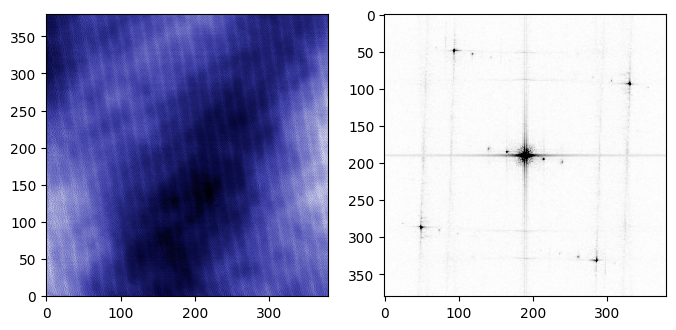

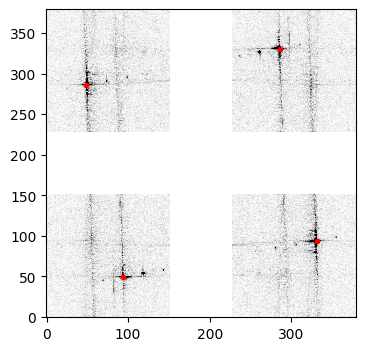

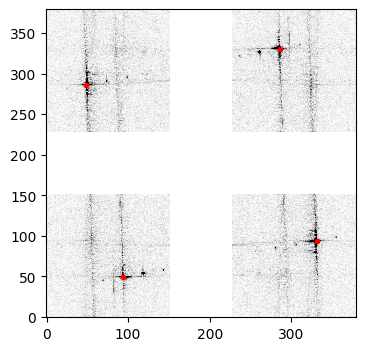

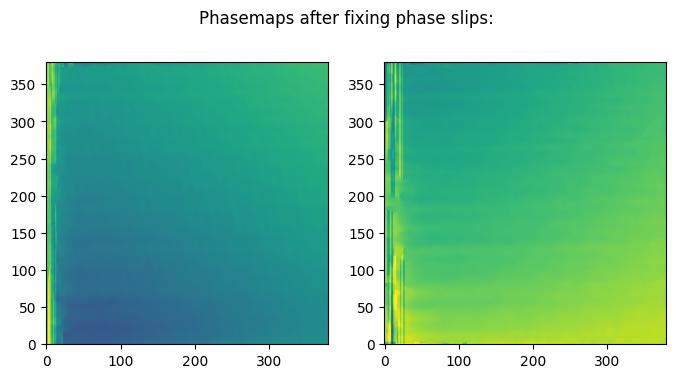

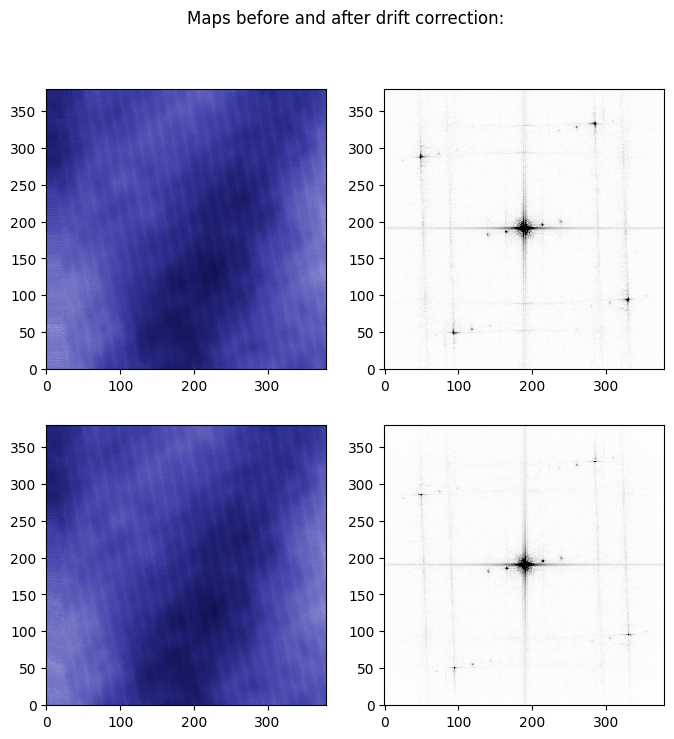

In [17]:
dfc.display(t.z)

getcontext().prec = 28  # Set the precision you need

decimal_arr = [Decimal(str(x)) for x in t.z.flatten()]
average = sum(decimal_arr) / Decimal(len(decimal_arr))
result = [x / average for x in decimal_arr]
result_arr = np.array(result, dtype=float).reshape(t.z.shape)
print(mean(result_arr))
nx, ny = shape(t.Z)
b = test.T.flat[ri] #using the same ri values defined above

testsparse = zeros_like(t.Z)
Xat2 = owlqn(nx*ny, evaluate, None, 7e-2)
# transform the output back into the spatial domain
Xat = Xat2.reshape(nx, ny).T # stack columns
testsparse = idct2(Xat) * original_mean

to_plot = stmpy.tools.fft(testsparse, zeroDC=True)
c2 = mean(to_plot)
s2 = std(to_plot)
imshow(to_plot,cmap=stmpy.cm.gray_r, clim=[0, c2+5*s2])

# Find parameters to find Bragg peaks
dfc.findBraggs(testsparse, w=0.1, show=True)

# Drift correct the topo
t.z_c, p = dfc.find_drift_parameter(testsparse, w=0.1, sigma=20, show=True, method='lockin')